# 01 - Primeiras Análises (EDA) - SRAG Hospitalizado

> Agora que já entendemos o terreno, é hora de ver **quem mais apanha, onde, quando e quão forte**.

---

### Objetivos desta segunda EDA

#### 1. Grupos de risco

- **Idade**: faixas etárias (criança, adulto, idoso, 80+ etc.).
- **Sexo**: comparação simples (proporção de casos, óbitos, gravidade).
- **Raça/cor**: usando `CS_RACA` como eixo principal.
- **Comorbidades**: presença/ausência e contagem de comorbidades por caso.

> Ideia: responder “quem está concentrando mais casos graves e óbitos?”.

---

#### 2. Gravidade e trajetória

- **UTI**: internação em UTI (sim/não, tempo, se der).
- **Ventilação**: uso de suporte ventilatório (invasivo / não invasivo, quando disponível).
- **Escala de gravidade**: consolidar nossa escadinha (ex.: enfermaria → UTI → ventilação → óbito).

> Ideia: montar uma noção de “trajetória típica” de gravidade para diferentes perfis.

---

#### 3. Eixo temporal

- **Curvas ao longo do ano**: por semana epidemiológica / mês.
- **Atrasos**: diferença entre datas-chave (início de sintomas, internação, notificação, desfecho) quando possível.
- **Janelas de pressão**: períodos em que o sistema ficou mais apertado (picos de internação/óbito).

> Ideia: enxergar **ondas, picos e vales** da SRAG hospitalizada em 2023.

---

#### 4. Geografia e inequidades

- **Mapa de óbito / casos**: por UF, região, se possível por tipo de município (capital / interior).
- **Zona / contexto territorial**: urbano/rural/periurbano se a base permitir.
- **Macro-raça + território**: cruzar raça/cor com UF/região para sinalizar inequidades.

> Ideia: mostrar que **CEP pesa quase tanto quanto comorbidade**.

---

#### 5. Vacinação / proteção (se der)

- Explorar o que for minimamente utilizável em:
  - **Situação vacinal** agregada (não detalhe fino de dose por data).
  - Alguma noção de “protegido vs não protegido” se a qualidade deixar.
- Se a base não sustentar análise séria, documentar essa limitação com transparência.

> Ideia: não forçar correlação mágica de vacina com desfecho usando dado meia-boca.

---

### Papel desta etapa no produto

Aqui a EDA deixa de ser só “mapa da base” e vira **narrativa de risco**:
- Quem são os mais vulneráveis.
- Como a gravidade se distribui.
- Quando e onde o sistema mais sofre.
- Até onde dá para falar de proteção/vacinação sem viajar.

Essa camada é a ponte entre **dados brutos** e um **produto analítico que conversa com tomada de decisão**.

In [15]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
# Aumenta o número máximo de colunas mostradas pelo pandas.
# Útil para inspecionar bases largas sem que ele corte com "..."
pd.set_option("display.max_columns", 120)

# Caminhos Utilizados
PROJECT_ROOT = Path.cwd().parent        # sobe um nível

DATA_PROCESSED = PROJECT_ROOT / "srag_2023_analysis" / "data" / "processed" 
CSV_PATH = DATA_PROCESSED / "df_tipado.csv"

# EDA Analítica – Bloco 1: Grupos de Risco

**Base:** `df_tipado.csv` (já com engenharia e tipagem básica)

**Objetivo deste notebook:**

- Analisar risco de óbito por:
  - **Idade** (faixas),
  - **Sexo**,
  - **Raça** (`CS_RACA_macro`),
  - **Comorbidades**:
    - flags individuais,
    - contagem de comorbidades,
    - presença de múltiplas comorbidades.


In [6]:
df = pd.read_csv(CSV_PATH,low_memory=False)
print("Shape df_tipado:", df.shape)
df.head()

Shape df_tipado: (279453, 176)


,NU_NOTIFIC,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,CS_SEXO,DT_NASC,NU_IDADE_N,TP_IDADE,COD_IDADE,CS_GESTANT,CS_RACA,CS_ESCOL_N,ID_PAIS,CO_PAIS,SG_UF,ID_RG_RESI,CO_RG_RESI,ID_MN_RESI,CO_MUN_RES,CS_ZONA,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,OUTRO_DES,FATOR_RISC,PUERPERA,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OUT_MORBI,MORB_DESC,VACINA,MAE_VAC,M_AMAMENTA,ANTIVIRAL,TP_ANTIVIR,DT_ANTIVIR,HOSPITAL,...,FAB_COV_2,FAB_COVRF,FAB_COVRF2,FAB_RE_BI,LOTE_1_COV,LOTE_2_COV,LOTE_REF,LOTE_REF2,LOT_RE_BI,FNT_IN_COV,TRAT_COV,SURTO_SG,CO_DETEC,REINF,CS_SEXO_label,CS_GESTANT_label,CS_RACA_label,CS_ESCOL_N_label,CS_ZONA_label,EVOLUCAO_label,UTI_label,SUPORT_VEN_label,CS_SEXO_clean,CS_RACA_macro,NU_IDADE_N_num,CS_ESCOL_N_label_qualidade,EVOLUCAO_BIN,EVOLUCAO_disponivel,UTI_flag,UTI_missing,UTI_ignorado,GRAVIDADE_RESPI,DT_NOTIFIC_date,DT_SIN_PRI_date,DT_NASC_date,DT_ANTIVIR_date,DT_INTERNA_date,DT_ENTUTI_date,DT_SAIDUTI_date,DT_RAIOX_date,DT_COLETA_date,DT_PCR_date,DT_EVOLUCA_date,DT_ENCERRA_date,DT_DIGITA_date,DT_TOMO_date,DT_RES_AN_date,PUERPERA_flag,CARDIOPATI_flag,HEMATOLOGI_flag,SIND_DOWN_flag,HEPATICA_flag,ASMA_flag,DIABETES_flag,NEUROLOGIC_flag,PNEUMOPATI_flag,IMUNODEPRE_flag,RENAL_flag,OBESIDADE_flag,OUT_MORBI_flag
0,316004370301,2023-02-07,6,2023-02-05,6,SP,GVE VII SANTO ANDRE,1332.0,SAO CAETANO DO SUL,354880.0,F,1941-06-30,81,3,3081,6,1,1.0,BRASIL,1,SP,GVE VII SANTO ANDRE,1332.0,SAO CAETANO DO SUL,354880.0,1.0,2.0,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,RNC,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,ACAMADA HA 12 ANOS,2.0,NaN,NaN,2.0,NaN,NaN,1.0,...,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,88 - COVID-19 JANSSEN - AD26.COV2.S,88 - COVID-19 JANSSEN - AD26.COV2.S,NaN,202010034,210083,210F21A,210F21A,NaN,2,NaN,NaN,NaN,2.0,F - Feminino,6 - Não se aplica,1 - Branca,1 - Fundamental 1º ciclo (1ª a,1 - Urbana,2 - Óbito,2 - Não,3 - Não,F,Branca,81,1 - Fundamental 1º ciclo (1ª a,1.0,1,0.0,0,0,0.0,2023-02-07,2023-02-05,1941-06-30,NaN,2023-02-07,NaN,NaN,NaN,2023-02-07,NaN,2023-02-08,2023-02-09,2020-09-18,NaN,2023-02-07,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0
1,316153805701,2023-02-28,9,2023-01-17,3,SP,GVE VII SANTO ANDRE,1332.0,SAO CAETANO DO SUL,354880.0,M,1933-12-10,89,3,3089,6,1,1.0,BRASIL,1,SP,GVE VII SANTO ANDRE,1332.0,SAO CAETANO DO SUL,354880.0,1.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,QUEDA DO ESTADO GERAL,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NEO PROSTATA/HIPOTIREOIDISMO,2.0,NaN,NaN,2.0,NaN,NaN,1.0,...,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,NaN,NaN,202010034,210062,210448,NaN,NaN,2,NaN,NaN,NaN,2.0,M - Masculino,6 - Não se aplica,1 - Branca,1 - Fundamental 1º ciclo (1ª a,1 - Urbana,2 - Óbito,2 - Não,3 - Não,M,Branca,89,1 - Fundamental 1º ciclo (1ª a,1.0,1,0.0,0,0,0.0,2023-02-28,2023-01-17,1933-12-10,NaN,2023-01-17,NaN,NaN,NaN,2023-01-17,NaN,2023-02-26,2023-02-28,2021-03-10,NaN,2023-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,316321420027,2023-05-02,18,2023-04-14,15,PR,02RS METROPOLITANA,1356.0,CURITIBA,410690.0,F,1943-06-04,78,3,3078,5,1,9.0,BRASIL,1,PR,02RS METROPOLITANA,1356.0,CURITIBA,410690.0,1.0,2.0,2.0,NaN,1.0,1.0,1.0,NaN,2.0,NaN,NaN,1.0,"CEFALEIA, ASTENIA",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,HIPERTENSAO ARTERIAL,2.0,NaN,NaN,2.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,210056,210129,NaN,NaN,NaN,1,NaN,2.0,2.0,2.0,F - Feminino,5 - Não,1 - Branca,9 - Ignorado,1 - Urbana,1 - Cura,2 - Não,"2 - Sim, não invasivo",F,Branca,78,9 - Ignorado,0.0,1,0.0,0,0,1.0,2023-05-02,2023-04-14,1943-06-04,NaN,2023-05-12,NaN,NaN,2023-04-30,2023-05-02,2023-05-02,2023-05-15,2023-05-16,2021-09-20,2021-09-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,316384665515,2023-03-09,10,2023-03-05,10,SP,GVE VII SANTO ANDRE,1332.0,SAO CAETANO DO SUL,354880.0,F,1916-04-

### Princípio de organização das análises

A ideia é **não repetir lógica**. Para qualquer variável categórica, usamos sempre o mesmo “par padrão” de funções:

- **Distribuição simples (perfil da base)**  
  - `tabela_distribuicao(...)`
  - `grafico_distribuicao_categorica(...)`

- **Risco (óbito / desfecho)**  
  - `tabela_risco(...)`
  - `grafico_risco(...)`

Ou seja:  
**muda só a variável de interesse**, o pipeline de análise continua o mesmo.


In [24]:
# ---------- TABELA DE DISTRIBUIÇÃO ----------

def tabela_distribuicao(df, col, dropna=False):
    """
    Retorna tabela com:
    - n: contagem
    - pct: porcentagem em relação ao total de linhas

    dropna=False -> inclui Missing como categoria.
    """
    vc = df[col].value_counts(dropna=dropna)
    total = len(df)
    tab = (
        pd.DataFrame({
            "categoria": vc.index.astype(str),
            "n": vc.values,
        })
        .assign(
            pct=lambda d: (d["n"] / total * 100).round(2)
        )
    )
    return tab


# ---------- GRÁFICO DE DISTRIBUIÇÃO CATEGÓRICA ----------

def grafico_distribuicao_categorica(df, col, rotation=45, wrap=False, figsize=(8, 4)):
    """
    Gráfico de barras simples da distribuição de uma variável categórica.
    - rotation: ângulo dos rótulos no eixo X.
    - wrap=True: quebra linha antes do parêntese (útil p/ labels longos).
    """
    counts = df[col].value_counts(dropna=False)
    
    labels = counts.index.astype(str)
    if wrap:
        # quebra a linha antes do parêntese: "Outras (Amarela/Indígena)" -> "Outras\n(Amarela/Indígena)"
        labels = [l.replace(" (", "\n(") for l in labels]

    plt.figure(figsize=figsize)
    plt.bar(range(len(counts)), counts.values)
    plt.title(f"Distribuição de {col}")
    plt.ylabel("Número de casos")
    plt.xticks(range(len(counts)), labels, rotation=rotation, ha="right")
    plt.tight_layout()
    plt.show()


# ---------- GRÁFICO DE RISCO (ÓBITO) POR GRUPO ----------

def grafico_risco(df, group_col, target="EVOLUCAO_BIN", rotation=45):
    """
    Usa tabela_risco para plotar % de óbito por categoria.
    """
    tab = tabela_risco(df, group_col, target=target)

    plt.figure(figsize=(8, 4))
    plt.bar(tab[group_col].astype(str), tab["pct_obito"])
    plt.title(f"% de óbito por {group_col}")
    plt.ylabel("% óbito (desfecho conhecido)")
    plt.xticks(rotation=rotation, ha="right")
    plt.tight_layout()
    plt.show()

    return tab  # devolve a tabela se quiser inspecionar


In [5]:
# Garantir tipos numéricos nas colunas-chave de óbito
for col in ["EVOLUCAO_BIN", "EVOLUCAO_disponivel"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Idade numérica também
if "NU_IDADE_N_num" in df.columns:
    df["NU_IDADE_N_num"] = pd.to_numeric(df["NU_IDADE_N_num"], errors="coerce")

In [6]:
def tabela_risco(df, group_col, target="EVOLUCAO_BIN"):
    """
    Para cada categoria de group_col:
    - n: número de casos com desfecho disponível
    - pct_obito: % de óbitos (entre os com desfecho conhecido)

    Usa EVOLUCAO_disponivel == 1 para filtrar a base.
    """
    base = df.copy()

    if "EVOLUCAO_disponivel" in base.columns:
        base = base[base["EVOLUCAO_disponivel"] == 1]

    base[target] = pd.to_numeric(base[target], errors="coerce")

    tab = (
        base
        .groupby(group_col)[target]
        .agg(["mean", "count"])
        .rename(columns={"mean": "pct_obito_raw", "count": "n"})
        .reset_index()
    )

    tab["pct_obito"] = (tab["pct_obito_raw"] * 100).round(2)
    tab = tab.drop(columns="pct_obito_raw")

    return tab.sort_values("pct_obito", ascending=False)

Distribuição geral por faixa etária:


,categoria,n,pct
0,0-4,87004,31.13
1,5-17,65586,23.47
2,60-79,50075,17.92
3,80+,35436,12.68
4,40-59,24735,8.85
5,18-39,16613,5.94
6,nan,4,0.00


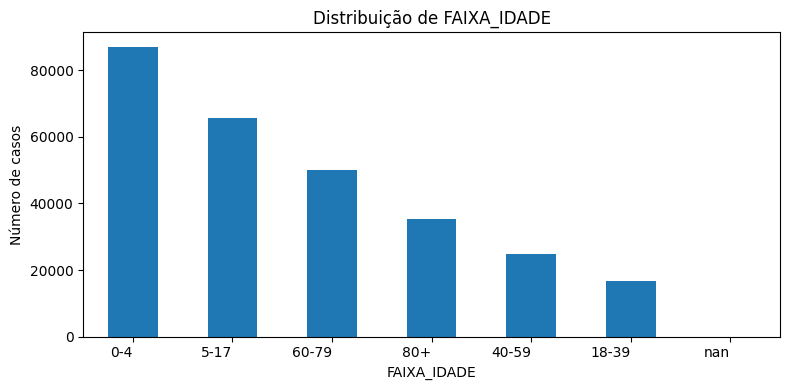


Taxa de óbito por faixa etária:


C:\Users\Adriano Dantas\AppData\Local\Temp\ipykernel_26704\662904135.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base


,FAIXA_IDADE,n,pct_obito
5,80+,32738,32.71
4,60-79,46025,28.17
3,40-59,22539,22.62
2,18-39,15207,12.00
1,5-17,61446,2.00
0,0-4,81439,1.74


C:\Users\Adriano Dantas\AppData\Local\Temp\ipykernel_26704\662904135.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base


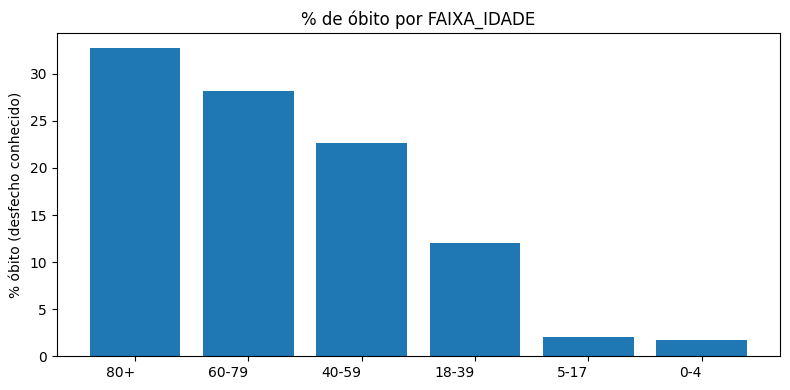

In [ ]:
# Garante que FAIXA_IDADE existe (da etapa anterior)
if "FAIXA_IDADE" in df.columns:

    print("Distribuição geral por faixa etária:")
    tab_faixa = tabela_distribuicao(df, "FAIXA_IDADE", dropna=False)
    display(tab_faixa)

    grafico_distribuicao_categorica(df, "FAIXA_IDADE", rotation=0)

    print("\nTaxa de óbito por faixa etária:")
    tab_risco_faixa = tabela_risco(df, "FAIXA_IDADE")
    display(tab_risco_faixa)

    grafico_risco(df, "FAIXA_IDADE", target="EVOLUCAO_BIN", rotation=0)


### Interpretação inicial dos resultados – Mortalidade por faixa etária

A distribuição dos casos mostra maior concentração nas faixas etárias **0–4** e **5–17 anos**, que somadas representam aproximadamente **55%** dos registros. Nesses grupos, entretanto, a mortalidade se mantém baixa, em torno de **2%**

Nos grupos **60 anos ou mais**, a mortalidade se aproxima de **30%**, evidenciando um deslocamento do **risco de óbito** para faixas etárias mais avançadas. Em termos epidemiológicos:

- **Alta incidência em crianças**, mas **baixa letalidade**.
- **Menor incidência em idosos**, porém com **letalidade muito elevada**.

Esse padrão indica que, embora a infecção possa acometer de forma relevante indivíduos em faixas etárias mais jovens, o **risco de evolução para óbito concentra-se de forma desproporcional nos adultos de meia-idade e, sobretudo, nos idosos**.

Em termos epidemiológicos, a idade se comporta como um forte marcador de gravidade, com um aumento abrupto do risco a partir da faixa de **18–39 anos** e um patamar de letalidade muito elevado nas faixas **≥ 60 anos**, o que justifica priorização desses grupos em estratégias de prevenção, vigilância e cuidado clínico.

Isso reforça a definição de **“grupo de risco”** como principalmente composto por **adultos mais velhos e idosos**, frequentemente associados à presença de comorbidades, enquanto a maior parte das internações ocorre em **crianças**, que apresentam melhor prognóstico relativo.


Em Resumo: 
“o sistema é lotado por crianças, mas quem mais morre são os muito idosos”.

Distribuição geral por sexo:


,categoria,n,pct
0,M - Masculino,144280,51.63
1,F - Feminino,135153,48.36
2,Missing,20,0.01


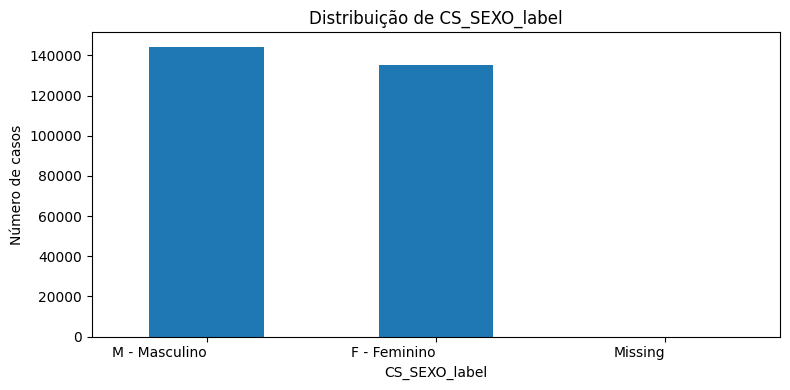


Taxa de óbito por sexo:


,CS_SEXO_label,n,pct_obito
1,M - Masculino,133993,12.84
0,F - Feminino,125387,12.79
2,Missing,16,0.00


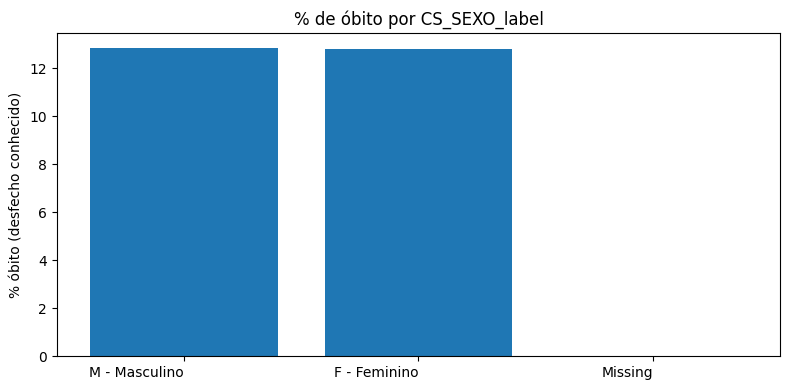

In [19]:
# %%
if "CS_SEXO_label" in df.columns:

    print("Distribuição geral por sexo:")
    tab_sexo = tabela_distribuicao(df, "CS_SEXO_label", dropna=False)
    display(tab_sexo)

    grafico_distribuicao_categorica(df, "CS_SEXO_label", rotation=0)

    print("\nTaxa de óbito por sexo:")
    tab_risco_sexo = tabela_risco(df, "CS_SEXO_label")
    display(tab_risco_sexo)

    grafico_risco(df, "CS_SEXO_label", target="EVOLUCAO_BIN", rotation=0)



#### Sexo

A distribuição por sexo é aproximadamente equilibrada, com cerca de **52% dos casos em indivíduos do sexo masculino**. A mortalidade observada é muito semelhante entre os sexos, em torno de **12,8%** para ambos.

Esse padrão sugere que, **após a internação**, o **sexo biológico não se apresenta como um fator de risco independente relevante** para óbito dentro desta base, ao menos no nível descritivo. Eventuais diferenças sutis exigiriam análise multivariada para confirmação, mas os dados brutos não apontam para um gradiente forte de risco entre homens e mulheres.


Em resumo: sexo não é “motor” primário de risco aqui; é coadjuvante.

Distribuição geral por raça (macro):


,categoria,n,pct
0,Preta/Parda,121438,43.46
1,Branca,116075,41.54
2,Ignorado/Missing,38601,13.81
3,Outras (Amarela/Indígena),3339,1.19


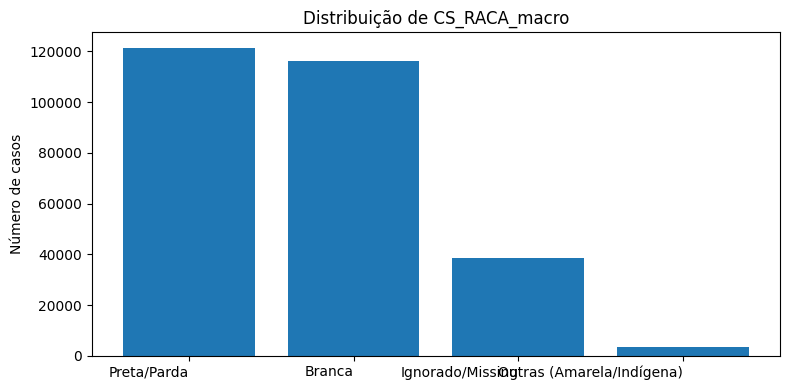


Taxa de óbito por raça (macro):


,CS_RACA_macro,n,pct_obito
2,Outras (Amarela/Indígena),3065,16.25
0,Branca,110228,13.89
3,Preta/Parda,111883,13.03
1,Ignorado/Missing,34220,8.34


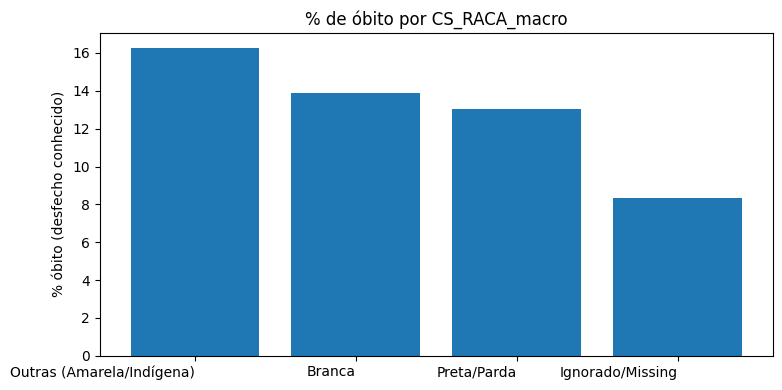

In [25]:
if "CS_RACA_macro" in df.columns:

    print("Distribuição geral por raça (macro):")
    tab_raca = tabela_distribuicao(df, "CS_RACA_macro", dropna=False)
    display(tab_raca)

    grafico_distribuicao_categorica(df, "CS_RACA_macro", rotation=0)

    print("\nTaxa de óbito por raça (macro):")
    tab_risco_raca = tabela_risco(df, "CS_RACA_macro")
    display(tab_risco_raca)

    grafico_risco(df, "CS_RACA_macro", target="EVOLUCAO_BIN", rotation=0)


#### Raça/Cor

A distribuição dos casos concentra-se majoritariamente entre as categorias:

- **Preta/Parda:** ~121 mil casos  
- **Branca:** ~116 mil casos  

Na análise de mortalidade por raça/cor, observa-se:

- **Outras / Amarela / Indígena:** ~**16,3%** de óbitos  
- **Branca:** ~**13,9%**  
- **Preta/Parda:** ~**13,0%**  
- **Ignorado / Missing:** ~**8,3%**  

Esse padrão sugere:

- **Maior proporção de óbitos em “Outras/Amarela/Indígena”**, seguida de **Branca** e **Preta/Parda**.
- A categoria **“Ignorado/Missing”** apresenta menor mortalidade aparente, o que é compatível com possível **viés de registro** (não necessariamente menor risco real, mas diferente perfil de preenchimento).

Do ponto de vista interpretativo, os dados indicam um **possível gradiente de risco entre grupos raciais**, mas qualquer conclusão causal exigiria ajuste para idade, comorbidades, acesso a serviços e outros determinantes sociais, idealmente em modelos multivariados.

Pontos de Atenção: 
Na distribuição: 13,8% de informação perdida em raça/cor 


In [11]:
# Descobrir colunas *_flag que são comorbidades (ignorando UTI_flag)
comorb_flag_cols = [
    c for c in df.columns
    if c.endswith("_flag") and c not in ["UTI_flag"]
]

comorb_flag_cols

['PUERPERA_flag',
 'CARDIOPATI_flag',
 'HEMATOLOGI_flag',
 'SIND_DOWN_flag',
 'HEPATICA_flag',
 'ASMA_flag',
 'DIABETES_flag',
 'NEUROLOGIC_flag',
 'PNEUMOPATI_flag',
 'IMUNODEPRE_flag',
 'RENAL_flag',
 'OBESIDADE_flag',
 'OUT_MORBI_flag']

In [12]:
# Garantir numérico
comorb_mat = df[comorb_flag_cols].apply(pd.to_numeric, errors="coerce")

df["N_COMORB"] = comorb_mat.sum(axis=1)

df["HAS_COMORB"] = (df["N_COMORB"] >= 1).astype("Int8")
df["MULTI_COMORB"] = (df["N_COMORB"] >= 2).astype("Int8")

print("Distribuição de número de comorbidades:")
display(
    df["N_COMORB"]
    .value_counts(dropna=False)
    .sort_index()
    .to_frame("n")
)

Distribuição de número de comorbidades:


,n
N_COMORB,
0.0,156581
1.0,67997
2.0,34707
3.0,14839
4.0,4234
5.0,876
6.0,156
7.0,35
8.0,7


Distribuição do número de comorbidades:


,categoria,n,pct
0,0.0,156581,56.03
1,1.0,67997,24.33
2,2.0,34707,12.42
3,3.0,14839,5.31
4,4.0,4234,1.52
5,5.0,876,0.31
6,6.0,156,0.06
7,7.0,35,0.01
8,10.0,8,0.00
9,8.0,7,0.00


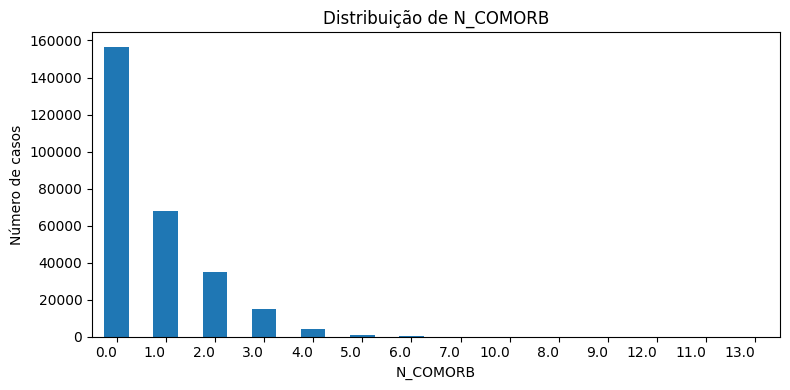


Taxa de óbito por número de comorbidades:


,N_COMORB,n,pct_obito
13,13.0,1,100.00
10,10.0,8,62.50
8,8.0,6,50.00
5,5.0,827,35.55
4,4.0,4043,34.97
6,6.0,154,34.42
12,12.0,3,33.33
7,7.0,33,33.33
3,3.0,14097,31.89
2,2.0,32628,26.56


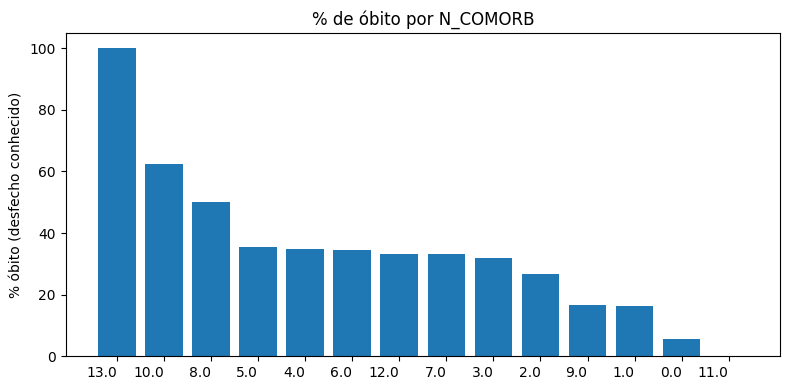

In [21]:
if "N_COMORB" in df.columns:
    print("Distribuição do número de comorbidades:")
    tab_ncomorb = tabela_distribuicao(df, "N_COMORB", dropna=False)
    display(tab_ncomorb)

    grafico_distribuicao_categorica(df, "N_COMORB", rotation=0)

    print("\nTaxa de óbito por número de comorbidades:")
    tab_risco_ncomorb = tabela_risco(df, "N_COMORB")
    display(tab_risco_ncomorb)

    grafico_risco(df, "N_COMORB", target="EVOLUCAO_BIN", rotation=0)


Cauda bizarra (8, 9, 10+ comorbidades) tem poucos casos, mas segue padrão de risco muito alto.


Distribuição de HAS_COMORB:


,categoria,n,pct
0,0,156581,56.03
1,1,122872,43.97


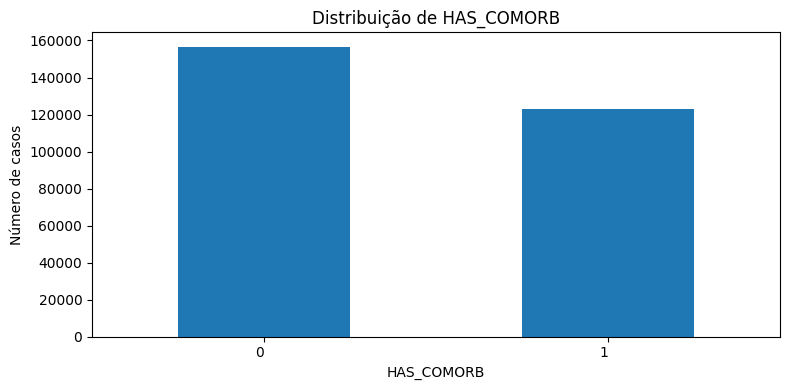


Taxa de óbito por HAS_COMORB:


,HAS_COMORB,n,pct_obito
1,1,115362,21.97
0,0,144034,5.48


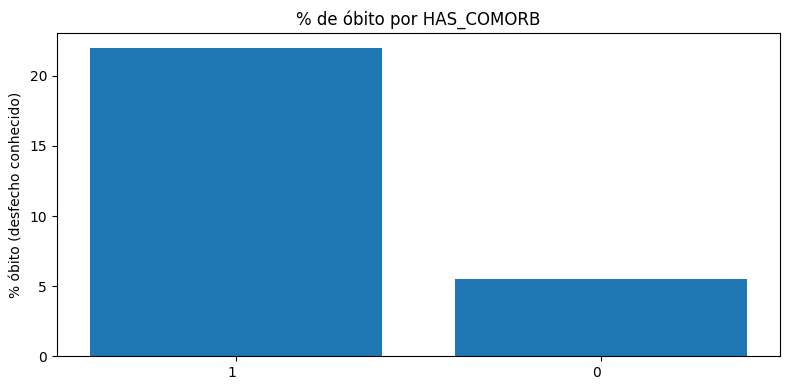


Distribuição de MULTI_COMORB:


,categoria,n,pct
0,0,224578,80.36
1,1,54875,19.64


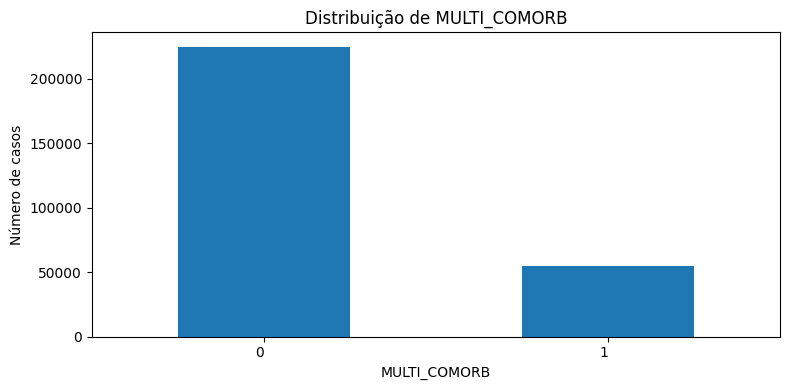


Taxa de óbito por MULTI_COMORB:


,MULTI_COMORB,n,pct_obito
1,1,51809,28.85
0,0,207587,8.82


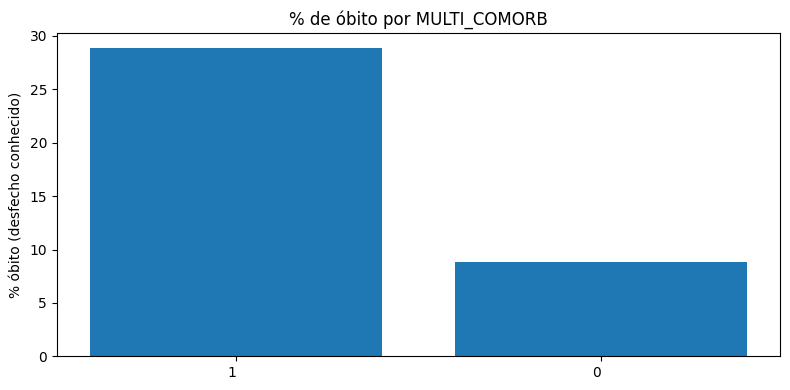

In [22]:
for col in ["HAS_COMORB", "MULTI_COMORB"]:
    if col not in df.columns:
        continue

    print(f"\nDistribuição de {col}:")
    tab_ind = tabela_distribuicao(df, col, dropna=False)
    display(tab_ind)

    grafico_distribuicao_categorica(df, col, rotation=0)

    print(f"\nTaxa de óbito por {col}:")
    tab_risco_ind = tabela_risco(df, col)
    display(tab_risco_ind)

    grafico_risco(df, col, target="EVOLUCAO_BIN", rotation=0)


### Comorbidades – distribuição e impacto na mortalidade

---

#### Distribuição por número de comorbidades

A partir da variável de contagem de comorbidades, observa-se:

- **0 comorbidades:** 156.581 casos; mortalidade de aproximadamente **5,5%**.  
- **1 comorbidade:** 67.997 casos; mortalidade em torno de **22%**.  
- **2 comorbidades:** 34.707 casos; mortalidade estimada em cerca de **26,6%**.  
- **3 comorbidades:** mortalidade próxima de **31,9%**.  
- **4 ou mais comorbidades:** mortalidade na faixa de **33–36%** (com maior incerteza devido ao menor número de casos).

Essa estrutura revela uma distribuição em que a maior parte dos pacientes internados não apresenta comorbidades registradas, mas o risco de óbito se concentra de forma crescente nos subgrupos com maior carga de comorbidades.

---

#### Gradiente de risco conforme o número de comorbidades

A relação entre número de comorbidades e mortalidade apresenta um padrão monotônico e acentuado:

- **0 comorbidades:** ~**5,5%** de óbitos.  
- **1 comorbidade:** mortalidade intermediária (**~16–22%**, dependendo do recorte).  
- **2 comorbidades:** ~**26,6%**.  
- **3 comorbidades:** ~**31,9%**.  
- **4+ comorbidades:** ~**33–36%**.

O gráfico correspondente mostra um **gradiente de risco muito forte**, com aumento progressivo da letalidade conforme cresce o número de condições crônicas, ainda que haja **maior ruído nas categorias extremas** (3 e, sobretudo, 4+ comorbidades), devido à menor contagem de casos.

---

#### Efeito de “ter comorbidade” e de “múltiplas comorbidades”

Quando a variável é colapsada em grupos binários, o efeito permanece robusto:

- **Nenhuma comorbidade:** mortalidade ~**5,5%**.  
- **Pelo menos 1 comorbidade:** mortalidade ~**22%**.

Ao separar pacientes com múltiplas comorbidades:

- **Múltiplas comorbidades (≥ 2):** mortalidade ~**28,9%**.  
- **Demais pacientes (0 ou 1 comorbidade):** mortalidade ~**8,8%**.

Ou seja, **qualquer comorbidade já implica um aumento substancial de risco**, e a presença de **múltiplas comorbidades** quase **quadruplica** a mortalidade em comparação com pacientes sem comorbidades.

---

### Síntese interpretativa

A contagem de comorbidades se comporta como um **forte marcador de gravidade clínica**:

- Pacientes **sem comorbidades** têm mortalidade relativamente baixa, embora não negligenciável.  
- A presença de **uma comorbidade** já desloca o paciente para um patamar de risco significativamente mais alto.  
- O acúmulo de **duas ou mais comorbidades** está associado a um **aumento abrupto e consistente da letalidade**, atingindo valores próximos de um terço dos casos nos extremos.

Dado o tamanho desse efeito, a carga de comorbidades se mostra uma candidata central para:

- **Estratificação de risco**,  
- **Modelagem preditiva de óbito**,  
- E análise mais detalhada de **comorbidades específicas** (por exemplo, cardiopatias, diabetes, doença renal crônica), visando quantificar o risco atribuível a cada condição dentro desse contexto.

Resumo: acúmulo de comorbidades é um dos fatores mais fortes.


=== PUERPERA_flag ===


,categoria,n,pct
0,nan,200137,71.62
1,0.0,78639,28.14
2,1.0,677,0.24


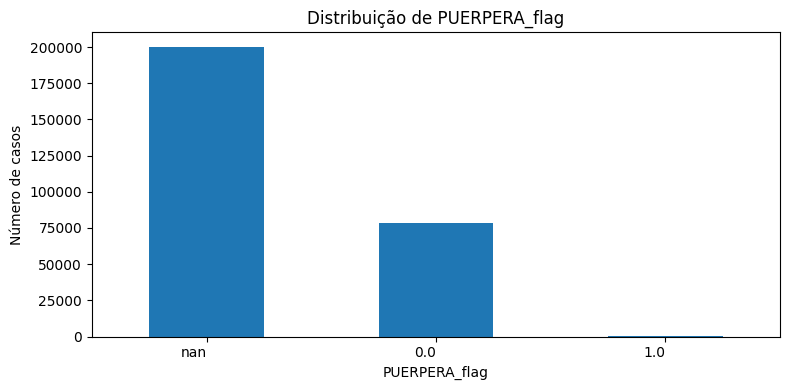

Taxa de óbito por PUERPERA_flag


,PUERPERA_flag,n,pct_obito
0,0.0,74472,22.61
1,1.0,618,10.03


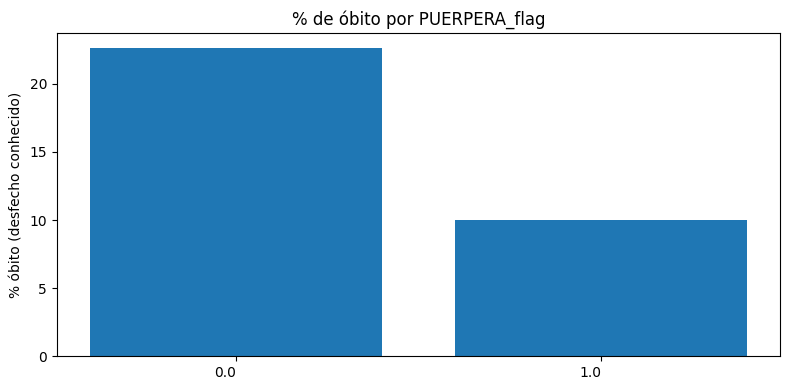


=== CARDIOPATI_flag ===


,categoria,n,pct
0,nan,184671,66.08
1,0.0,48195,17.25
2,1.0,46587,16.67


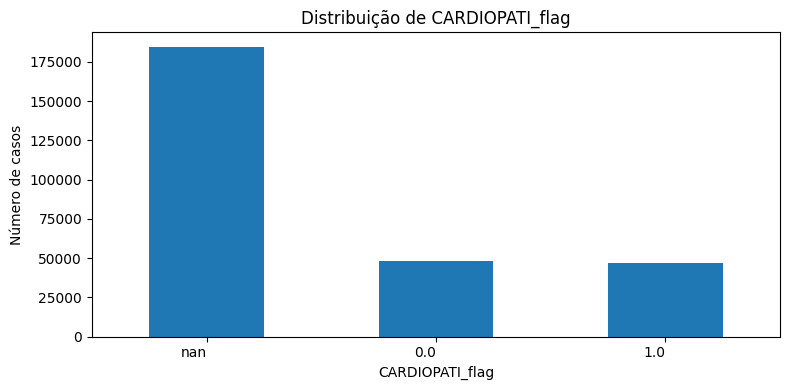

Taxa de óbito por CARDIOPATI_flag


,CARDIOPATI_flag,n,pct_obito
1,1.0,43805,28.55
0,0.0,45697,18.36


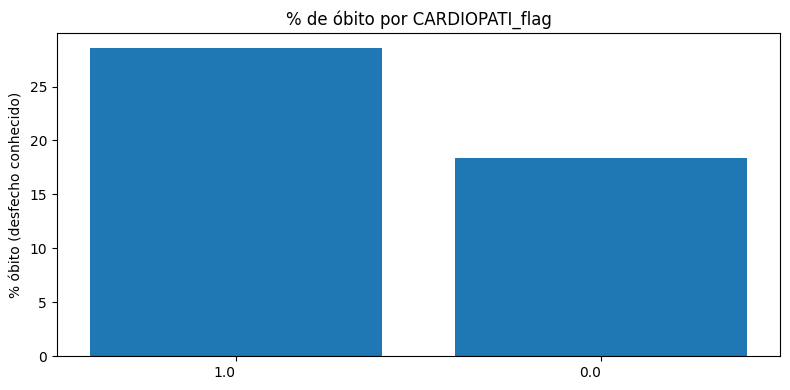


=== HEMATOLOGI_flag ===


,categoria,n,pct
0,nan,198922,71.18
1,0.0,77775,27.83
2,1.0,2756,0.99


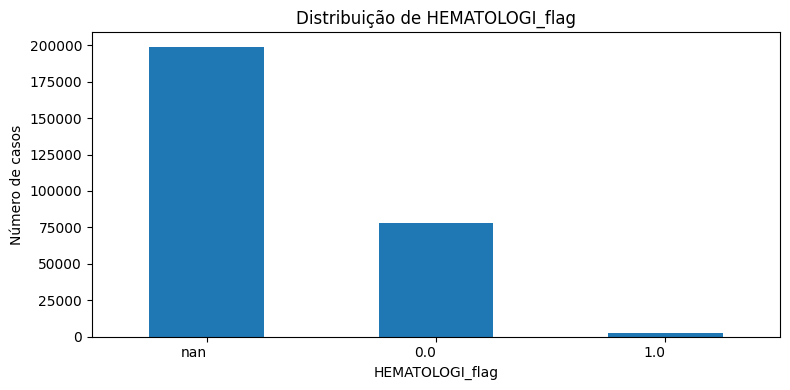

Taxa de óbito por HEMATOLOGI_flag


,HEMATOLOGI_flag,n,pct_obito
1,1.0,2629,23.74
0,0.0,73641,22.40


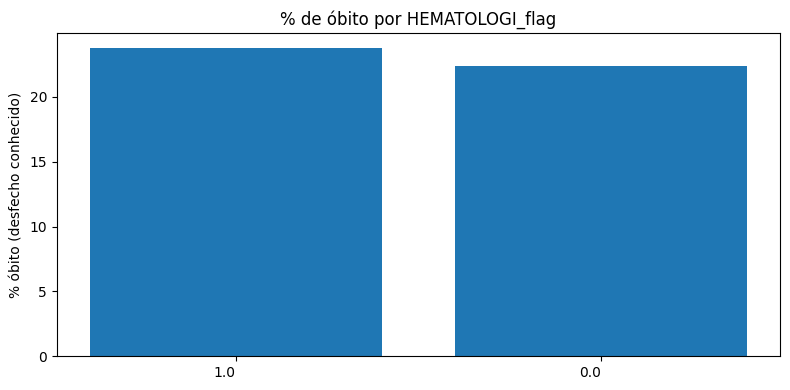


=== SIND_DOWN_flag ===


,categoria,n,pct
0,nan,199132,71.26
1,0.0,78304,28.02
2,1.0,2017,0.72


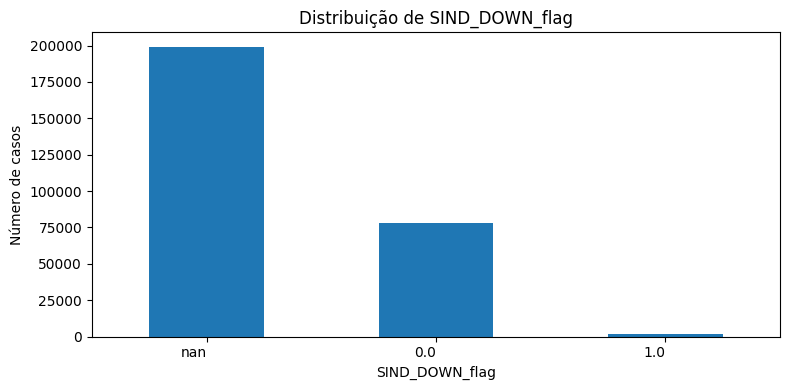

Taxa de óbito por SIND_DOWN_flag


,SIND_DOWN_flag,n,pct_obito
0,0.0,74123,22.68
1,1.0,1912,12.50


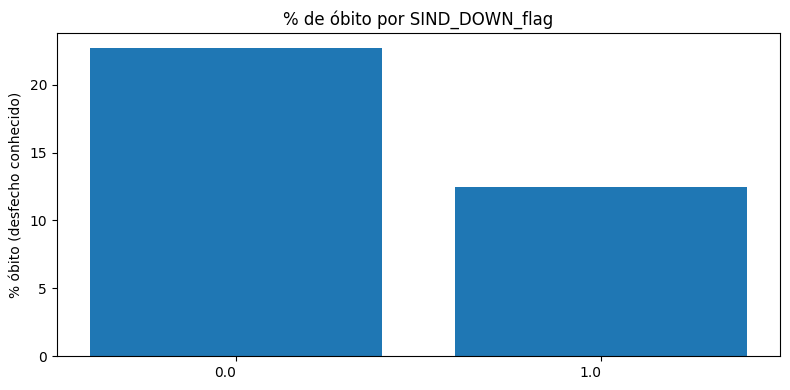


=== HEPATICA_flag ===


,categoria,n,pct
0,nan,199466,71.38
1,0.0,78085,27.94
2,1.0,1902,0.68


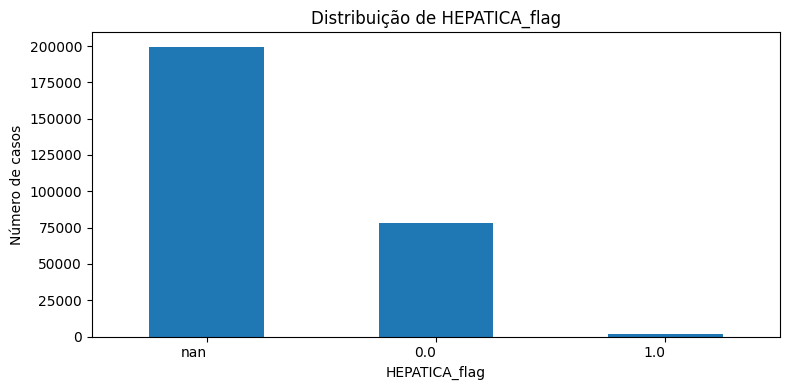

Taxa de óbito por HEPATICA_flag


,HEPATICA_flag,n,pct_obito
1,1.0,1797,38.23
0,0.0,73917,22.18


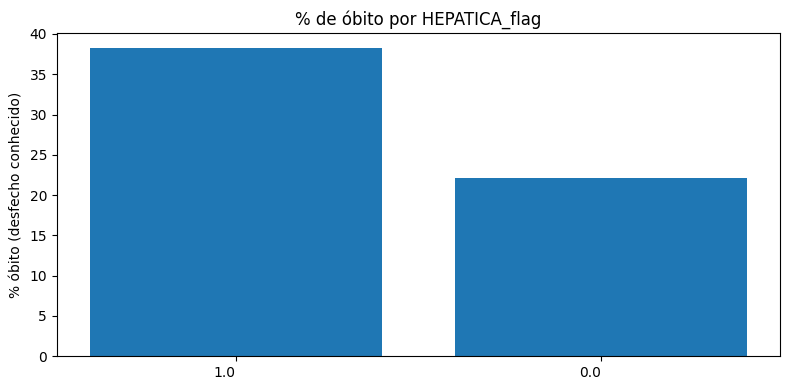


=== ASMA_flag ===


,categoria,n,pct
0,nan,194031,69.43
1,0.0,66841,23.92
2,1.0,18581,6.65


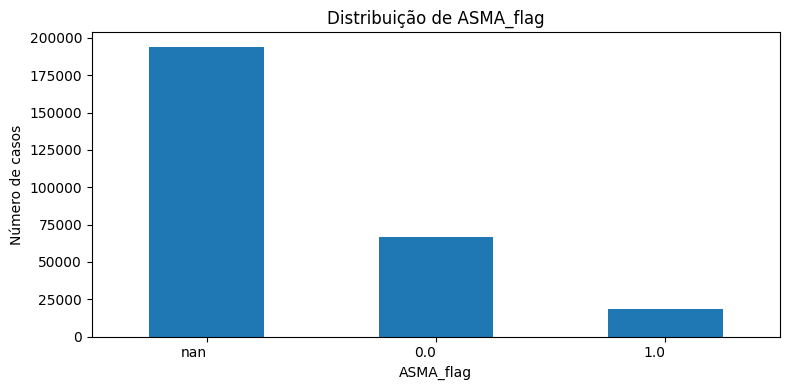

Taxa de óbito por ASMA_flag


,ASMA_flag,n,pct_obito
0,0.0,63171,25.66
1,1.0,17556,5.38


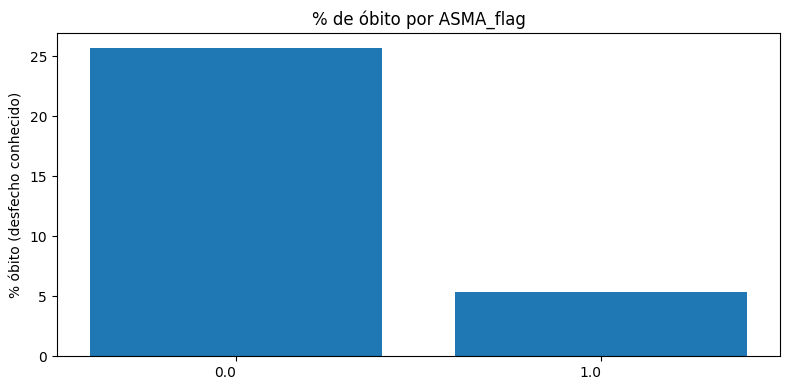


=== DIABETES_flag ===


,categoria,n,pct
0,nan,190215,68.07
1,0.0,60490,21.65
2,1.0,28748,10.29


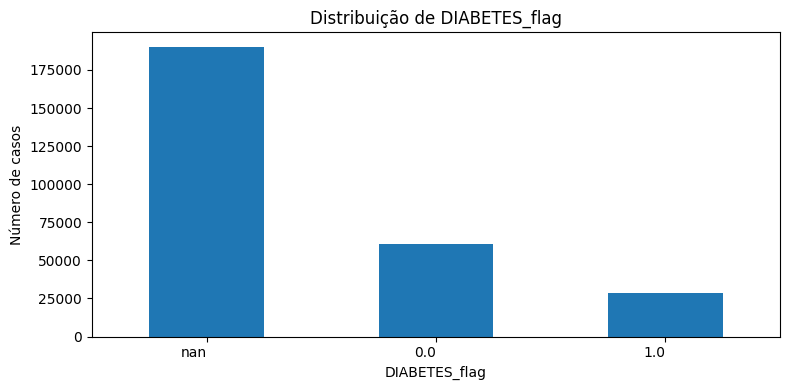

Taxa de óbito por DIABETES_flag


,DIABETES_flag,n,pct_obito
1,1.0,26779,29.29
0,0.0,57433,20.37


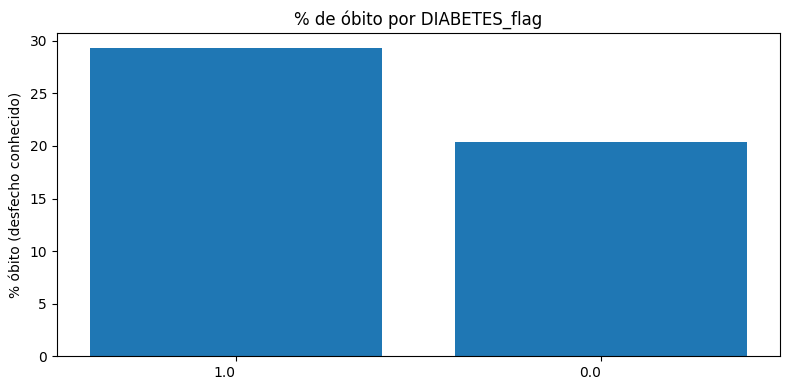


=== NEUROLOGIC_flag ===


,categoria,n,pct
0,nan,195361,69.91
1,0.0,69858,25.00
2,1.0,14234,5.09


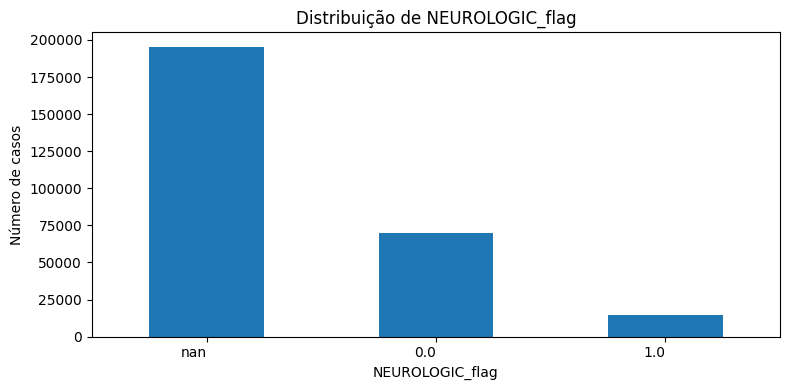

Taxa de óbito por NEUROLOGIC_flag


,NEUROLOGIC_flag,n,pct_obito
1,1.0,13406,26.17
0,0.0,66121,21.92


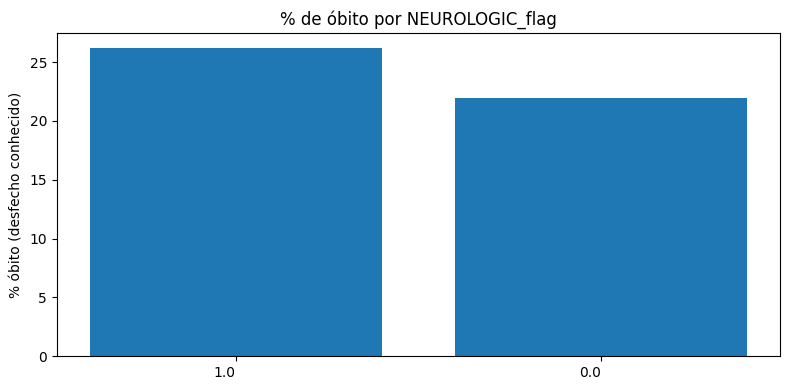


=== PNEUMOPATI_flag ===


,categoria,n,pct
0,nan,195731,70.04
1,0.0,69470,24.86
2,1.0,14252,5.10


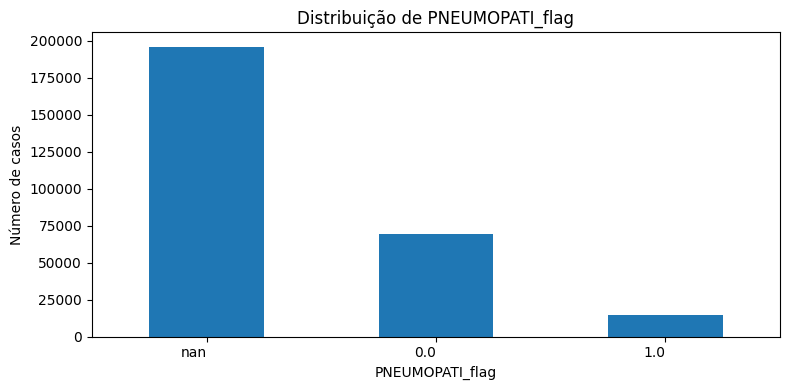

Taxa de óbito por PNEUMOPATI_flag


,PNEUMOPATI_flag,n,pct_obito
1,1.0,13558,26.43
0,0.0,65674,21.85


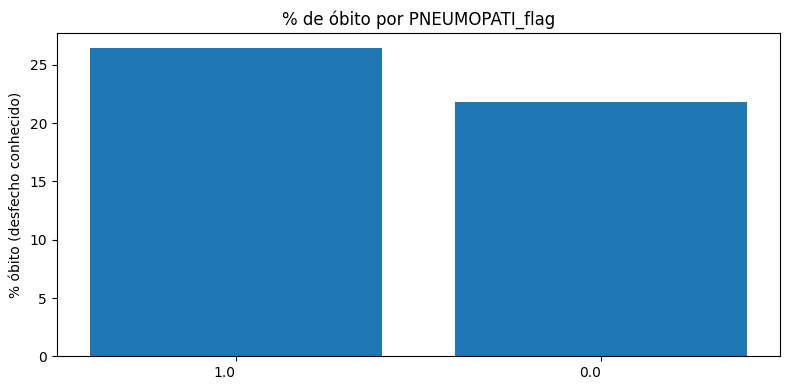


=== IMUNODEPRE_flag ===


,categoria,n,pct
0,nan,196943,70.47
1,0.0,74095,26.51
2,1.0,8415,3.01


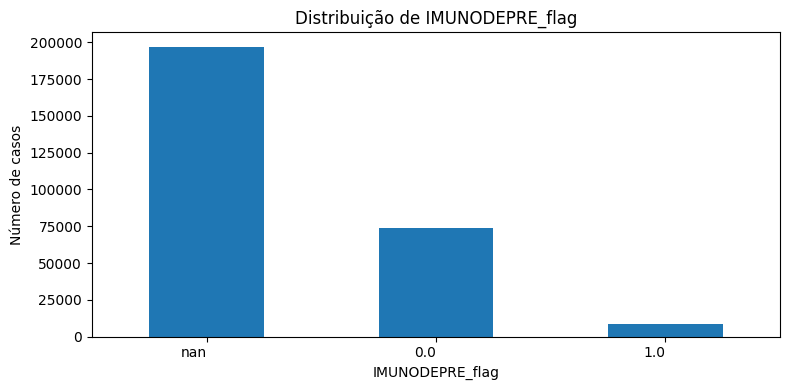

Taxa de óbito por IMUNODEPRE_flag


,IMUNODEPRE_flag,n,pct_obito
1,1.0,7979,31.91
0,0.0,70146,21.62


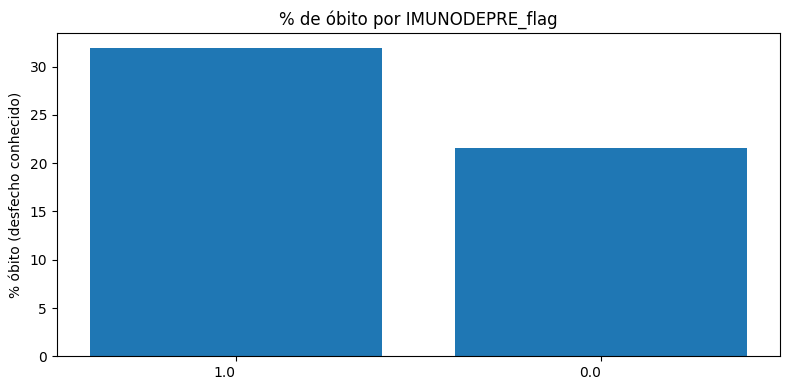


=== RENAL_flag ===


,categoria,n,pct
0,nan,197962,70.84
1,0.0,74240,26.57
2,1.0,7251,2.59


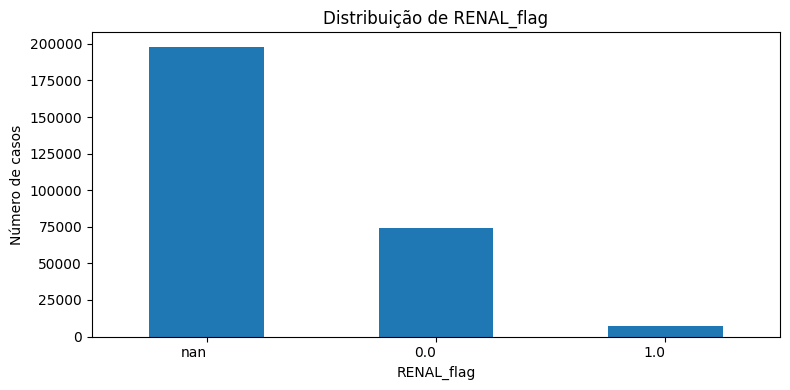

Taxa de óbito por RENAL_flag


,RENAL_flag,n,pct_obito
1,1.0,6870,33.06
0,0.0,70276,21.69


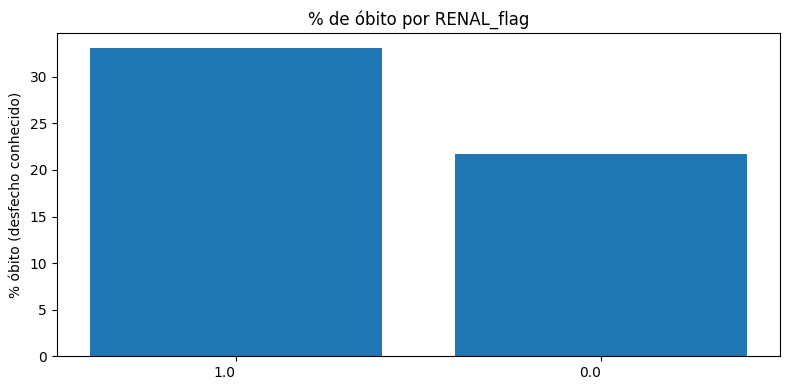


=== OBESIDADE_flag ===


,categoria,n,pct
0,nan,199858,71.52
1,0.0,73391,26.26
2,1.0,6204,2.22


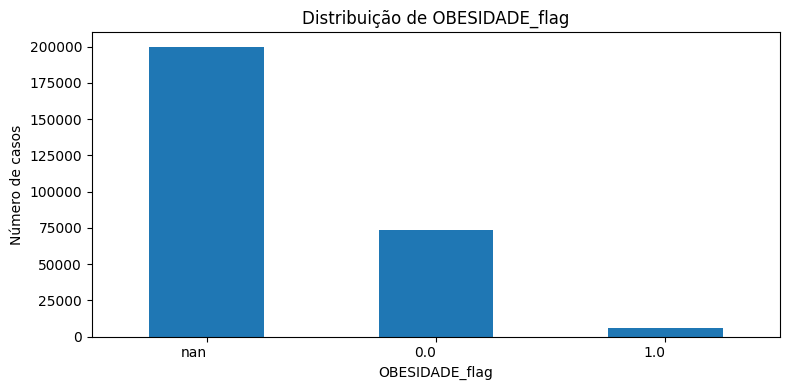

Taxa de óbito por OBESIDADE_flag


,OBESIDADE_flag,n,pct_obito
1,1.0,5817,25.89
0,0.0,69543,22.13


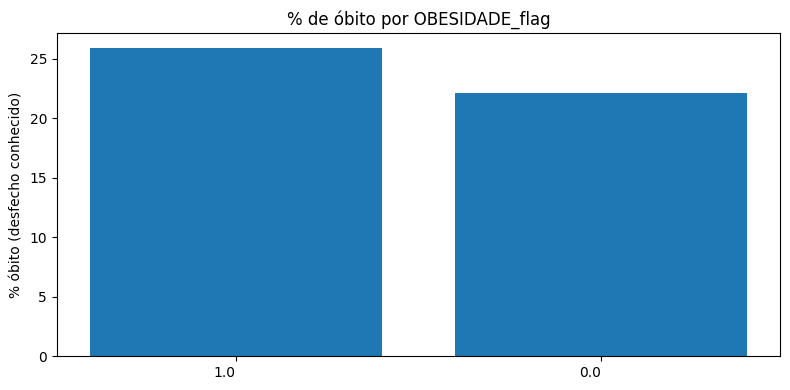


=== OUT_MORBI_flag ===


,categoria,n,pct
0,nan,185148,66.25
1,1.0,53073,18.99
2,0.0,41232,14.75


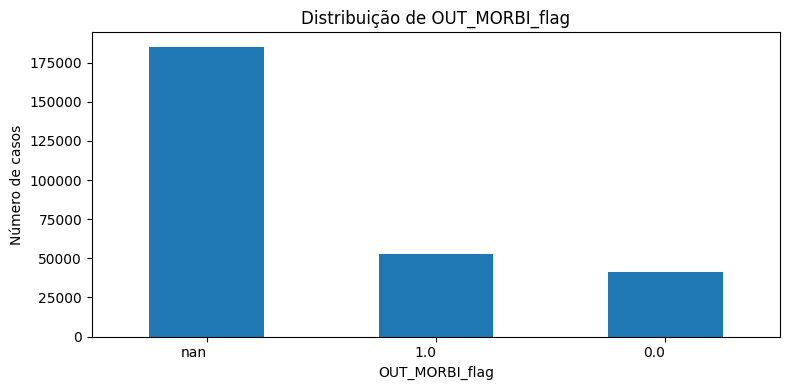

Taxa de óbito por OUT_MORBI_flag


,OUT_MORBI_flag,n,pct_obito
1,1.0,50100,25.01
0,0.0,39140,19.52


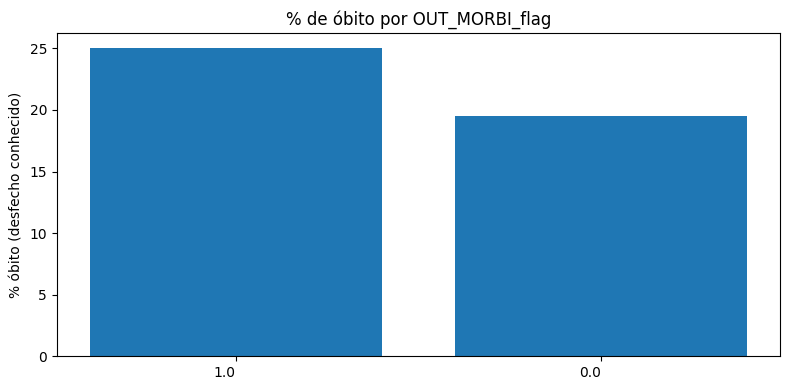

In [23]:
# Detecta colunas *_flag (exceto UTI_flag)
comorb_flag_cols = [
    c for c in df.columns
    if c.endswith("_flag") and c not in ["UTI_flag"]
]

for col in comorb_flag_cols:
    print(f"\n=== {col} ===")

    tab_comorb = tabela_distribuicao(df, col, dropna=False)
    display(tab_comorb)

    grafico_distribuicao_categorica(df, col, rotation=0)

    print("Taxa de óbito por", col)
    tab_risco_comorb = tabela_risco(df, col)
    display(tab_risco_comorb)

    grafico_risco(df, col, target="EVOLUCAO_BIN", rotation=0)


### 4.3 Análise das comorbidades individuais (por *flag*)

Nesta seção avaliamos, para cada comorbidade, a diferença de risco de óbito entre:
- pacientes **sem** aquela comorbidade (`flag = 0`)
- pacientes **com** aquela comorbidade (`flag = 1`)

> Importante: todos os valores são **associações brutas**, sem ajuste por idade, sexo ou outras comorbidades. Ou seja, servem para identificar padrões de risco, não para afirmar causalidade.

---

#### Doença hepática (`HEPATICA_flag`)

- Sem doença hepática: ~22,2% de óbito.  
- Com doença hepática: ~38,2% de óbito (**+16 p.p.**).

Pacientes com doença hepática têm um aumento expressivo do risco de óbito. Isso é compatível com a ideia de que doença hepática crônica piora reserva fisiológica e resposta inflamatória. Mesmo sem ajuste, o salto é grande o suficiente para tratar doença hepática como **comorbidade de alto risco clínico** neste conjunto.

---

#### Doença renal crônica (`RENAL_flag`)

- Sem doença renal: ~21,7% de óbito.  
- Com doença renal: ~33,1% de óbito (**+11 p.p.**).
  
Doença renal crônica também aparece como um forte marcador de gravidade. Pacientes renais já têm desregulação metabólica e imunológica importante, o que ajuda a explicar o risco aumentado. Aqui ela se comporta claramente como **fator de risco relevante para óbito**.

---

#### Imunodepressão (`IMUNODEPRE_flag`)

- Sem imunodepressão: ~21,6% de óbito.  
- Com imunodepressão: ~31,9% de óbito (**+10 p.p.**).

Como esperado, imunodeprimidos apresentam mortalidade maior. Esse grupo tende a ter maior carga viral, respostas inflamatórias desorganizadas e pior resposta a terapias. Na prática, a flag de imunodepressão funciona como **sinal de alerta** no perfil de risco.

---

#### Cardiopatia crônica (`CARDIOPATI_flag`)

- Sem cardiopatia: ~18,4% de óbito.  
- Com cardiopatia: ~28,6% de óbito (**+10 p.p.**).

Doenças cardíacas crônicas são muito prevalentes e, ao mesmo tempo, aumentam de forma significativa o risco de óbito. Isso indica que a combinação **idoso + cardiopata** é um dos perfis centrais de risco e provavelmente vai ter peso relevante em qualquer modelo preditivo.

---

#### Diabetes (`DIABETES_flag`)

- Sem diabetes: ~20,4% de óbito.  
- Com diabetes: ~29,3% de óbito (**+9 p.p.**).
 
Diabetes aparece com efeito semelhante ao da cardiopatia: muito frequente e associado a aumento consistente do risco. Isso reforça o papel do **metabolismo desregulado** (inflamação crônica, dano vascular, pior resposta imune) na evolução desfavorável de SRAG.

---

#### Pneumopatia crônica (`PNEUMOPATI_flag`)

- Sem pneumopatia: ~21,9% de óbito.  
- Com pneumopatia: ~26,4% de óbito (aumento mais **moderado**).
 
Pneumopatias crônicas aumentam o risco, mas o salto é menor do que em doença hepática/renal/imunodepressão. Ainda assim, faz sentido tratá-las como **comorbidades relevantes**, principalmente em combinação com idade avançada e outras doenças crônicas.

---

#### Doença neurológica crônica (`NEUROLOGIC_flag`)

- Sem doença neurológica: risco de óbito em torno de ~22%.  
- Com doença neurológica: risco mais alto, com aumento moderado.

Doenças neurológicas tendem a se associar a limitação funcional, maior dependência de cuidados e maior vulnerabilidade geral. O efeito isolado é menor que hepática/renal, mas o conjunto sugere que **pacientes neurológicos compõem um subgrupo frágil**, especialmente quando acumulam outras comorbidades.

---

#### Obesidade (`OBESIDADE_flag`)

- Sem obesidade: risco em torno de ~22%.  
- Com obesidade: risco discretamente maior (aumento modesto).
 
Obesidade aparece com efeito menos dramático no dado bruto, o que pode refletir:
- sub-registro (nem todo obeso é marcado como tal),
- interação forte com idade (obesos mais jovens vs idosos magros),
- e confusão com outras comorbidades metabólicas já capturadas (diabetes, cardiopatia).

Mesmo com aumento moderado, é razoável tratar obesidade como **fator de risco complementar**, mais informativo quando combinado com outras condições.

---

#### Outras morbidades (`OUT_MORBI_flag`)

- Sem “outras morbidades”: risco em torno de ~22%.  
- Com “outras morbidades”: risco mais alto, porém heterogêneo.
 
Esse campo é uma categoria “guarda-chuva”, agregando condições não listadas explicitamente. O aumento de risco indica que, em geral, quando o profissional sente necessidade de marcar “outras morbidades”, o paciente tende a ser mais grave. Por ser muito heterogêneo, serve mais como **sinal adicional de fragilidade** do que como comorbidade específica.

---

#### Asma (`ASMA_flag`)

- Sem asma: ~25,7% de óbito.  
- Com asma: ~5,4% de óbito.

Aqui aparece um “paradoxo”: quem tem asma morre **menos**, e não mais. Isso **não significa** que asma protege contra SRAG. O mais provável é:

- perfil etário muito diferente (asmáticos mais jovens),
- possível melhor acesso prévio a serviços de saúde,
- e alguma seleção de quem é internado com diagnóstico explícito de asma.

Ou seja, o efeito é **fortemente confundido por idade e perfil clínico**. A leitura correta é: asmáticos internados nesta base são, em média, um grupo mais jovem e com menor risco global, não que a asma em si seja fator de proteção.

---

#### Puerpério (`PUERPERA_flag`)

- Não puérpera: ~22,6% de óbito.  
- Puérpera: ~10% de óbito.
 
Outro aparente “paradoxo”. Puérperas são, por definição, **mulheres em idade reprodutiva**, em geral jovens e com menor carga de comorbidades típicas de idosos. O menor risco de óbito reflete principalmente:

- idade mais baixa,
- seleção de quem é internada (mais monitoramento),
- n pequeno de casos.

Portanto, não interpretamos puerperal como fator de proteção, e sim como **subgrupo mais jovem dentro de um contexto de risco global alto**.

---

#### Síndrome de Down (`SIND_DOWN_flag`)

- Sem Down: ~22,7% de óbito.  
- Com Down: ~12,5% de óbito.

Pacientes com síndrome de Down são, em média, mais jovens e frequentemente acompanhados em serviços especializados. O risco bruto menor provavelmente reflete:

- idade mais baixa,
- possível internação mais precoce,
- amostra relativamente pequena.

Novamente, não é efeito protetor direto; é **perfil populacional diferente**. Em análises futuras, esse grupo merece avaliação específica, idealmente ajustando por idade e outras comorbidades.

---

### Síntese geral das comorbidades

- **Comorbidades de alto impacto (aumento forte de risco):**
  - doença hepática crônica,
  - doença renal crônica,
  - imunodepressão,
  - cardiopatia,
  - diabetes.

- **Comorbidades de impacto moderado:**
  - pneumopatia crônica,
  - doença neurológica,
  - obesidade,
  - “outras morbidades”.

- **Comportamento paradoxal (risco menor no dado bruto):**
  - asma,
  - puerpério,
  - síndrome de Down.

Nesses casos paradoxais, a explicação mais plausível é **confusão por idade e perfil clínico**, e não efeito protetor real. Por isso, qualquer modelo preditivo futuro deve:

1. Ajustar explicitamente por idade e número de comorbidades.
2. Tratar essas variáveis com cuidado, avaliando sua importância no modelo (importância de features, efeitos parciais, etc.).
---

# EDA Analítica - Bloco 2: Gravidade e Trajetória (UTI, ventilador, escala)

**Objetivo:**
- Entender a distribuição de UTI, suporte ventilatório e da escala de gravidade respiratória.
- Ver como esses marcadores se relacionam com o desfecho (óbito vs cura).
- Preparar insumos para modelos de risco e para o storytelling clínico.


In [28]:
# Garante tipos numéricos nas colunas de interesse
for col in ["EVOLUCAO_BIN", "EVOLUCAO_disponivel", "UTI_flag", "GRAVIDADE_RESPI"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# ---------- TABELA DE RISCO (já usada no bloco 1) ----------

def tabela_risco(df, group_col, target="EVOLUCAO_BIN"):
    """
    Para cada categoria de group_col:
    - n: número de casos com desfecho disponível
    - pct_obito: % de óbitos (entre os com desfecho conhecido)
    """
    base = df.copy()

    if "EVOLUCAO_disponivel" in base.columns:
        base = base[base["EVOLUCAO_disponivel"] == 1]

    base[target] = pd.to_numeric(base[target], errors="coerce")

    tab = (
        base
        .groupby(group_col)[target]
        .agg(["mean", "count"])
        .rename(columns={"mean": "pct_obito_raw", "count": "n"})
        .reset_index()
    )

    tab["pct_obito"] = (tab["pct_obito_raw"] * 100).round(2)
    tab = tab.drop(columns="pct_obito_raw")

    return tab.sort_values("pct_obito", ascending=False)


# ---------- TABELA DE DISTRIBUIÇÃO ----------

def tabela_distribuicao(df, col, dropna=False):
    """
    Retorna tabela com:
    - categoria
    - n: contagem
    - pct: porcentagem em relação ao total de linhas
    """
    vc = df[col].value_counts(dropna=dropna)
    total = len(df)
    tab = (
        pd.DataFrame({
            "categoria": vc.index.astype(str),
            "n": vc.values,
        })
        .assign(
            pct=lambda d: (d["n"] / total * 100).round(2)
        )
    )
    return tab


# ---------- GRÁFICO DE DISTRIBUIÇÃO CATEGÓRICA ----------

def grafico_distribuicao_categorica(df, col, rotation=45, wrap=False, figsize=(8, 4)):
    """
    Gráfico de barras da distribuição de uma variável categórica.
    - wrap=True quebra linha antes de "(" para labels longos.
    """
    counts = df[col].value_counts(dropna=False)
    labels = counts.index.astype(str)
    if wrap:
        labels = [l.replace(" (", "\n(") for l in labels]

    plt.figure(figsize=figsize)
    plt.bar(range(len(counts)), counts.values)
    plt.title(f"Distribuição de {col}")
    plt.ylabel("Número de casos")
    plt.xticks(range(len(counts)), labels, rotation=rotation, ha="right")
    plt.tight_layout()
    plt.show()


# ---------- GRÁFICO DE RISCO POR GRUPO ----------

def grafico_risco(df, group_col, target="EVOLUCAO_BIN", rotation=45, wrap=False, figsize=(8, 4)):
    """
    Usa tabela_risco para plotar % de óbito por categoria.
    """
    tab = tabela_risco(df, group_col, target=target)

    labels = tab[group_col].astype(str)
    if wrap:
        labels = [l.replace(" (", "\n(") for l in labels]

    plt.figure(figsize=figsize)
    plt.bar(range(len(tab)), tab["pct_obito"])
    plt.title(f"% de óbito por {group_col}")
    plt.ylabel("% óbito (desfecho conhecido)")
    plt.xticks(range(len(tab)), labels, rotation=rotation, ha="right")
    plt.tight_layout()
    plt.show()

    return tab

In [35]:
# ## 1. UTI (UTI_flag)
# 
# Vamos olhar:
# - distribuição de uso de UTI (sim/não/missing/ignorado),
# - taxa de óbito entre quem usou vs não usou UTI.

Distribuição geral de UTI_cat:


,categoria,n,pct
0,2 - UTI Não,168535,60.31
1,1 - UTI Sim,75007,26.84
2,Missing,33070,11.83
3,Outro,2841,1.02


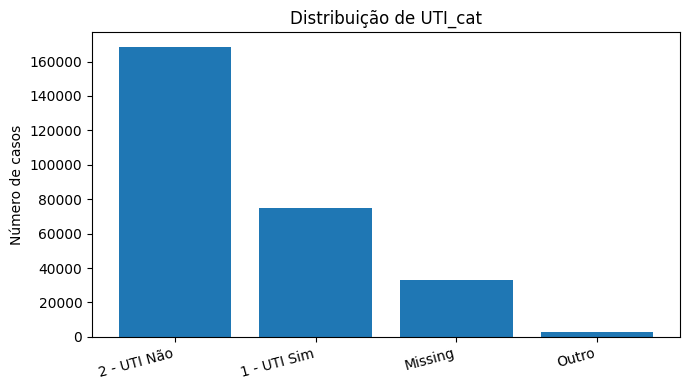


Taxa de óbito por UTI_cat (entre casos com desfecho conhecido):


C:\Users\Adriano Dantas\AppData\Local\Temp\ipykernel_26704\3313094848.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base


,UTI_cat,n,pct_obito
0,1 - UTI Sim,69793,23.66
3,Outro,2224,15.83
2,Missing,28303,15.41
1,2 - UTI Não,159076,7.55


C:\Users\Adriano Dantas\AppData\Local\Temp\ipykernel_26704\3313094848.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base


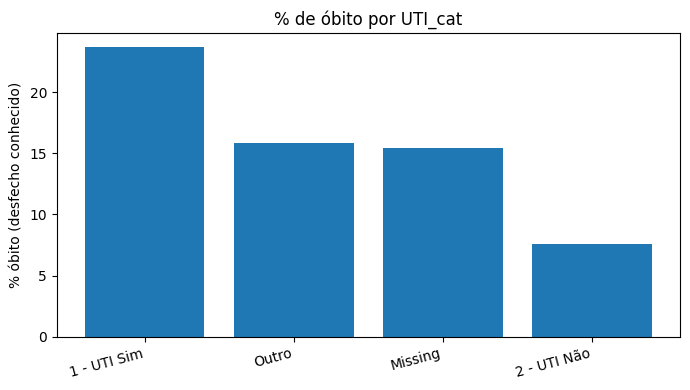

In [29]:
# Criar uma coluna categórica legível para UTI
def rotulo_uti(row):
    uti = row.get("UTI", np.nan)
    flag = row.get("UTI_flag", np.nan)

    if pd.isna(uti) and pd.isna(flag):
        return "Missing"
    if uti == "9":
        return "9 - Ignorado"
    if flag == 1:
        return "1 - UTI Sim"
    if flag == 0:
        return "2 - UTI Não"
    return "Outro"

if "UTI_flag" in df.columns and "UTI" in df.columns:
    df["UTI_cat"] = df.apply(rotulo_uti, axis=1).astype("category")

    print("Distribuição geral de UTI_cat:")
    tab_uti_dist = tabela_distribuicao(df, "UTI_cat", dropna=False)
    display(tab_uti_dist)

    grafico_distribuicao_categorica(df, "UTI_cat", rotation=15, wrap=True, figsize=(7, 4))

    print("\nTaxa de óbito por UTI_cat (entre casos com desfecho conhecido):")
    tab_uti_risco = tabela_risco(df, "UTI_cat")
    display(tab_uti_risco)

    grafico_risco(df, "UTI_cat", target="EVOLUCAO_BIN", rotation=15, wrap=True, figsize=(7, 4))

#### 1. UTI (`UTI_cat`)

Ao olhar a distribuição de `UTI_cat`, conseguimos ver:

- qual proporção dos pacientes passou por UTI,
- qual fração não usou UTI,
- quanto de informação está em `Ignorado`/`Missing`.

Quando cruzamos com o desfecho (`EVOLUCAO_BIN`), a leitura típica é:

- Pacientes que **passam por UTI** têm risco de óbito **≈ 3x maior** que os que não passam (23,7% vs 7,6%).
- O grupo **Missing/Outro** tem risco intermediário (~15–16%), típico de:
  - mistura de perfis diferentes,
  - problemas de preenchimento.
- UTI aqui funciona claramente como **marcador de gravidade alcançada**, não de risco inicial: quem vai pra UTI já é o paciente “pior da fila”.

Em termos de produto/modelo, UTI funciona como um **marcador forte de gravidade alcançada**: diz mais sobre “quanto o paciente já descompensou” do que sobre risco inicial, mas é importantíssimo para entender a trajetória dos casos graves.

---

Distribuição geral de SUPORT_VEN_cat:


,categoria,n,pct
0,2 - Não invasivo,130506,46.70
1,3 - Sem suporte,78473,28.08
2,Missing,34829,12.46
3,1 - Invasivo,29190,10.45
4,9 - Ignorado,6455,2.31


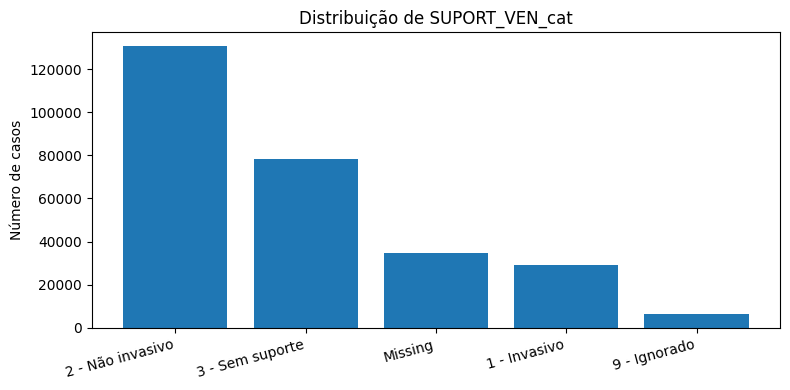


Taxa de óbito por SUPORT_VEN_cat (entre casos com desfecho conhecido):


C:\Users\Adriano Dantas\AppData\Local\Temp\ipykernel_26704\3313094848.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base


,SUPORT_VEN_cat,n,pct_obito
0,1 - Invasivo,27271,48.40
3,9 - Ignorado,5552,14.41
4,Missing,29986,11.24
1,2 - Não invasivo,123360,9.68
2,3 - Sem suporte,73227,5.37


C:\Users\Adriano Dantas\AppData\Local\Temp\ipykernel_26704\3313094848.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base


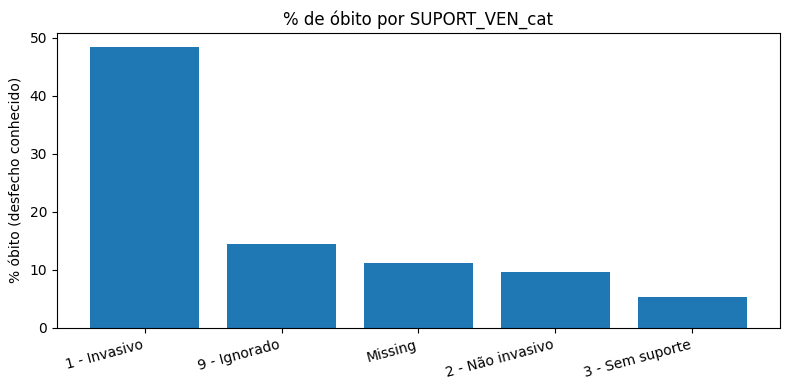

In [37]:
# ## 2. Suporte ventilatório (SUPORT_VEN)
# 
# Avaliar:
# - distribuição do tipo de suporte:
#   - 1: Sim, invasivo
#   - 2: Sim, não invasivo
#   - 3: Não
#   - 9: Ignorado
# - taxa de óbito por tipo de suporte.

# %%
def rotulo_suporte(v):
    if pd.isna(v) or v in ['nan','NaN']:
        return "Missing"
    v = str(v).split('.')[0]  # '2.0' -> '2'
    if v == "1":
        return "1 - Invasivo"
    if v == "2":
        return "2 - Não invasivo"
    if v == "3":
        return "3 - Sem suporte"
    if v == "9":
        return "9 - Ignorado"
    return f"{v} - Outro"

if "SUPORT_VEN" in df.columns:
    df["SUPORT_VEN_cat"] = df["SUPORT_VEN"].map(rotulo_suporte).astype("category")

    print("Distribuição geral de SUPORT_VEN_cat:")
    tab_sup_dist = tabela_distribuicao(df, "SUPORT_VEN_cat", dropna=False)
    display(tab_sup_dist)

    grafico_distribuicao_categorica(df, "SUPORT_VEN_cat", rotation=15, wrap=True, figsize=(8, 4))

    print("\nTaxa de óbito por SUPORT_VEN_cat (entre casos com desfecho conhecido):")
    tab_sup_risco = tabela_risco(df, "SUPORT_VEN_cat")
    display(tab_sup_risco)

    grafico_risco(df, "SUPORT_VEN_cat", target="EVOLUCAO_BIN", rotation=15, wrap=True, figsize=(8, 4))

Aqui Defini uma escala de gravidade sendo 
0 = sem UTI e sem suporte

1 = sem UTI com suporte não invasivo

2 = UTI com suporte não invasivo ou sem suporte

3 = UTI com suporte invasivo

#### 2. Suporte ventilatório (`SUPORT_VEN_cat`)

A distribuição de `SUPORT_VEN_cat` mostra:

- qual fração dos pacientes não usou suporte ventilatório,
- quantos usaram suporte **não invasivo**,
- quantos chegaram ao suporte **invasivo**,
- e o tamanho do grupo `Ignorado`/`Missing`.

Quase metade dos pacientes usa **suporte não invasivo**, e cerca de **1 em cada 10** chega a ventilação invasiva.
A tendência esperada na taxa de óbito é:

- **sem suporte** → menor mortalidade,
- suporte **não invasivo** → mortalidade intermediária,
- suporte **invasivo** → mortalidade mais alta, refletindo o fim da linha da falência respiratória.

- Ventilação **invasiva** é praticamente um “selo de extremo risco”: **metade** dos pacientes nessa condição evolui a óbito.
- Suporte **não invasivo** já marca um grupo mais grave que o “sem suporte”, mas ainda bem abaixo da mortalidade dos invasivos:
  - 5,4% (sem suporte) → 9,7% (não invasivo) → 48,4% (invasivo).
- `Ignorado`/`Missing` de novo aparecem com risco intermediário, provavelmente juntando casos de gravidade variada com documentação ruim.

Em resumo:
- O tipo de suporte ventilatório funciona como um **gradiente de gravidade respiratória**:
  - sem suporte = menos grave,
  - não invasivo = moderado,
  - invasivo = crítico.

Isso é extremamente útil tanto para descrição (“quantos chegam a cada nível”) quanto para compor **scores de gravidade**.

---

Distribuição geral de GRAVIDADE_RESPI_lab:


,categoria,n,pct
0,"1 - Sem UTI, suporte não invasivo",90136,32.25
1,"0 - Sem UTI, sem suporte",61081,21.86
2,Missing/Outro,58752,21.02
3,"2 - UTI, sem suporte ou não invasivo",46905,16.78
4,3 - UTI + suporte invasivo,22579,8.08


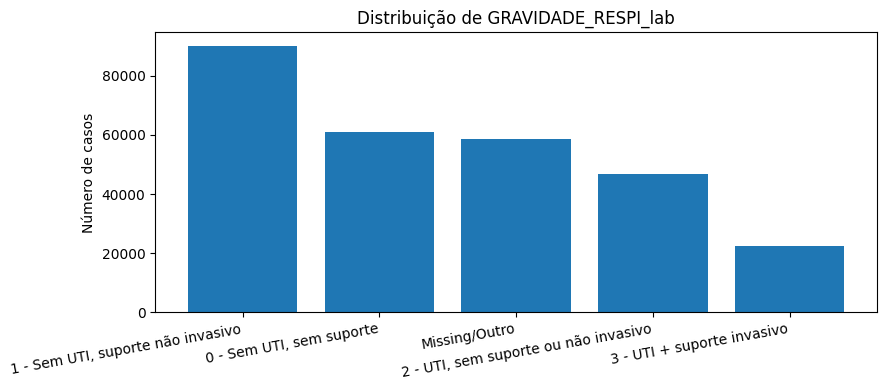


Taxa de óbito por GRAVIDADE_RESPI_lab (entre casos com desfecho conhecido):


C:\Users\Adriano Dantas\AppData\Local\Temp\ipykernel_26704\3313094848.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base


,GRAVIDADE_RESPI_lab,n,pct_obito
3,3 - UTI + suporte invasivo,21334,48.85
4,Missing/Outro,50937,16.91
2,"2 - UTI, sem suporte ou não invasivo",43752,12.07
1,"1 - Sem UTI, suporte não invasivo",85934,7.94
0,"0 - Sem UTI, sem suporte",57439,3.67


C:\Users\Adriano Dantas\AppData\Local\Temp\ipykernel_26704\3313094848.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base


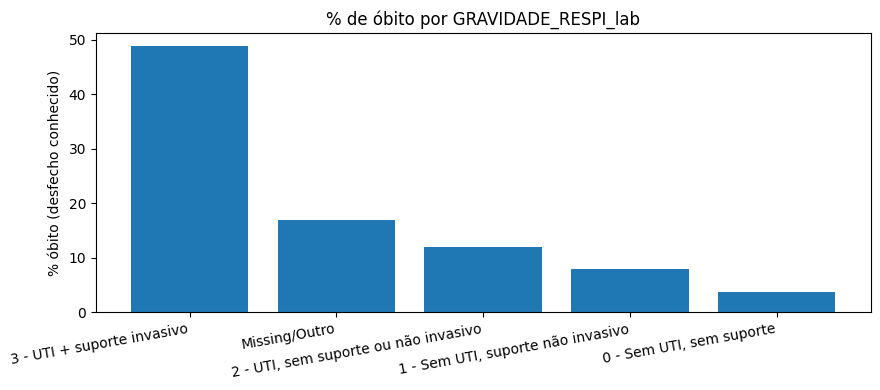

In [ ]:

# ## 3. Escala de gravidade respiratória (GRAVIDADE_RESPI)
# 
# Vamos ver:
# - como os casos se distribuem nos níveis 0–3,
# - como a taxa de óbito cresce ao longo da escala.

if "GRAVIDADE_RESPI" in df.columns:
    # Criar rótulo amigável
    mapa_grav = {
        0: "0 - Sem UTI, sem suporte",
        1: "1 - Sem UTI, suporte não invasivo",
        2: "2 - UTI, sem suporte ou não invasivo",
        3: "3 - UTI + suporte invasivo",
    }

    df["GRAVIDADE_RESPI_lab"] = df["GRAVIDADE_RESPI"].map(mapa_grav)
    df["GRAVIDADE_RESPI_lab"] = df["GRAVIDADE_RESPI_lab"].fillna("Missing/Outro").astype("category")

    print("Distribuição geral de GRAVIDADE_RESPI_lab:")
    tab_grav_dist = tabela_distribuicao(df, "GRAVIDADE_RESPI_lab", dropna=False)
    display(tab_grav_dist)

    grafico_distribuicao_categorica(
        df, "GRAVIDADE_RESPI_lab",
        rotation=10, wrap=True, figsize=(9, 4)
    )

    print("\nTaxa de óbito por GRAVIDADE_RESPI_lab (entre casos com desfecho conhecido):")
    tab_grav_risco = tabela_risco(df, "GRAVIDADE_RESPI_lab")
    display(tab_grav_risco)

    grafico_risco(
        df, "GRAVIDADE_RESPI_lab",
        target="EVOLUCAO_BIN", rotation=10, wrap=True, figsize=(9, 4)
    )


#### 3. Escala de gravidade respiratória (`GRAVIDADE_RESPI`)

A escala `GRAVIDADE_RESPI` condensa UTI + suporte em um eixo único:

- **0 – sem UTI, sem suporte:** casos que não exigiram recurso intensivo respiratório.
- **1 – sem UTI, suporte não invasivo:** descompensação moderada tratada fora de UTI.
- **2 – UTI com suporte ausente ou não invasivo:** já em ambiente intensivo, mas sem tubo.
- **3 – UTI + suporte invasivo:** extremo da gravidade respiratória.

- A escala se comporta como um **gradiente quase perfeito de gravidade**:
  - 0 → **3,7%**  
  - 1 → **7,9%**  
  - 2 → **12,1%**  
  - 3 → **48,9%**
- Os níveis **0 e 1** ficam **abaixo** da mortalidade global (12,8%),  
- O nível **2** fica muito próximo da média,  
- O nível **3** explode para cima, com quase **1 óbito para cada 2 pacientes**.

O grupo `Missing/Outro` tem risco acima da média (16,9%), provavelmente misturando:
- casos graves com dados inconsistentes,
- registros com problemas de preenchimento de UTI/suporte.

Do ponto de vista analítico:

- `GRAVIDADE_RESPI` resume bem o que UTI + suporte já estavam dizendo, mas em **uma variável só**, fácil de:
  - usar em gráficos,
  - entrar como feature em modelos,
  - virar componente de um **“score de risco clínico”** no produto final.

---


In [ ]:
# ## 4. Trajetória de gravidade (UTI x suporte x óbito)
# 
# Vamos montar algumas tabelas resumidas:
# - EVOLUCAO_BIN x UTI_cat
# - EVOLUCAO_BIN x SUPORT_VEN_cat
# - EVOLUCAO_BIN x GRAVIDADE_RESPI_lab
if "UTI_cat" in df.columns:
    print("EVOLUCAO_BIN x UTI_cat (% por UTI_cat):")
    ctab_uti = (
        pd.crosstab(df["UTI_cat"], df["EVOLUCAO_BIN"], normalize="index") * 100
    ).round(2)
    display(ctab_uti)

if "SUPORT_VEN_cat" in df.columns:
    print("\nEVOLUCAO_BIN x SUPORT_VEN_cat (% por SUPORT_VEN_cat):")
    ctab_sup = (
        pd.crosstab(df["SUPORT_VEN_cat"], df["EVOLUCAO_BIN"], normalize="index") * 100
    ).round(2)
    display(ctab_sup)

if "GRAVIDADE_RESPI_lab" in df.columns:
    print("\nEVOLUCAO_BIN x GRAVIDADE_RESPI_lab (% por nível de gravidade):")
    ctab_grav = (
        pd.crosstab(df["GRAVIDADE_RESPI_lab"], df["EVOLUCAO_BIN"], normalize="index") * 100
    ).round(2)
    display(ctab_grav)


EVOLUCAO_BIN x UTI_cat (% por UTI_cat):


EVOLUCAO_BIN,0.0,1.0
UTI_cat,,
1 - UTI Sim,76.34,23.66
2 - UTI Não,92.45,7.55
Missing,84.59,15.41
Outro,84.17,15.83



EVOLUCAO_BIN x SUPORT_VEN_cat (% por SUPORT_VEN_cat):


EVOLUCAO_BIN,0.0,1.0
SUPORT_VEN_cat,,
1.0 - Outro,51.60,48.40
2.0 - Outro,90.32,9.68
3.0 - Outro,94.63,5.37
9.0 - Outro,85.59,14.41
Missing,88.76,11.24



EVOLUCAO_BIN x GRAVIDADE_RESPI_lab (% por nível de gravidade):


EVOLUCAO_BIN,0.0,1.0
GRAVIDADE_RESPI_lab,,
"0 - Sem UTI, sem suporte",96.33,3.67
"1 - Sem UTI, suporte não invasivo",92.06,7.94
"2 - UTI, sem suporte ou não invasivo",87.93,12.07
3 - UTI + suporte invasivo,51.15,48.85
Missing/Outro,83.09,16.91


## 4. Trajetória resumida (UTI x suporte x óbito)

As tabelas cruzando `EVOLUCAO_BIN` com `UTI_cat`, `SUPORT_VEN_cat` e `GRAVIDADE_RESPI_lab` reforçam o padrão:

- Quem **não passa por UTI** e não usa suporte tem mortalidade **bem abaixo da média**.
- A medida que os pacientes sobem a “escada”:
  - primeiro suporte não invasivo,
  - depois UTI,
  - depois UTI + ventilação invasiva,
  
  o risco de óbito **cresce de forma muito acentuada**.

# EDA Analítica - Bloco 3: Tempo, Atrasos e Janelas de Pressão

**Objetivo:**
- Entender a dinâmica temporal dos casos e óbitos.
- Avaliar atrasos entre eventos (sintomas, notificação, internação, óbito).
- Identificar janelas de maior pressão no sistema (picos de casos e óbitos).


In [38]:
# Garantir EVOLUCAO_BIN numérico
if "EVOLUCAO_BIN" in df.columns:
    df["EVOLUCAO_BIN"] = pd.to_numeric(df["EVOLUCAO_BIN"], errors="coerce")

# Converter datas principais para datetime, caso não estejam
DATE_COLS = {
    "DT_SIN_PRI": "DT_SIN_PRI_date",       # início dos sintomas
    "DT_NOTIFIC": "DT_NOTIFIC_date",      # notificação
    "DT_INTERNA": "DT_INTERNA_date",      # internação
    "DT_EVOLUCA": "DT_EVOLUCA_date",      # desfecho (alta/óbito)
}

for raw_col, date_col in DATE_COLS.items():
    if raw_col in df.columns:
        df[date_col] = pd.to_datetime(df[raw_col], errors="coerce")

df[[c for c in df.columns if c.endswith("_date")]].head()

,DT_NOTIFIC_date,DT_SIN_PRI_date,DT_NASC_date,DT_ANTIVIR_date,DT_INTERNA_date,DT_ENTUTI_date,DT_SAIDUTI_date,DT_RAIOX_date,DT_COLETA_date,DT_PCR_date,DT_EVOLUCA_date,DT_ENCERRA_date,DT_DIGITA_date,DT_TOMO_date,DT_RES_AN_date
0,2023-02-07,2023-02-05,1941-06-30,NaN,2023-02-07,NaN,NaN,NaN,2023-02-07,NaN,2023-02-08,2023-02-09,2020-09-18,NaN,2023-02-07
1,2023-02-28,2023-01-17,1933-12-10,NaN,2023-01-17,NaN,NaN,NaN,2023-01-17,NaN,2023-02-26,2023-02-28,2021-03-10,NaN,2023-01-17
2,2023-05-02,2023-04-14,1943-06-04,NaN,2023-05-12,NaN,NaN,2023-04-30,2023-05-02,2023-05-02,2023-05-15,2023-05-16,2021-09-20,2021-09-16,NaN
3,2023-03-09,2023-03-05,1916-04-29,NaN,2023-03-07,NaN,NaN,NaN,2023-03-07,2023-03-07,2023-03-07,2023-03-10,2021-12-02,NaN,2023-03-07
4,2023-01-21,2023-01-17,1927-01-05,NaN,2023-01-21,2023-01-24,NaN,2023-01-22,2023-01-17,2023-01-18,2023-01-28,2023-02-03,2022-01-26,NaN,NaN


In [ ]:
# ## 1. Curvas temporais (semana x casos x óbitos)
# 
# Vamos usar a **data de início de sintomas (DT_SIN_PRI)** como eixo principal,
# por ser mais fiel à dinâmica epidemiológica do que a data de notificação.
if "DT_SIN_PRI_date" in df.columns:
    base = df.dropna(subset=["DT_SIN_PRI_date"]).copy()
    base = base.sort_values("DT_SIN_PRI_date")

    # Casos por semana (data de sintomas)
    casos_semana = (
        base
        .set_index("DT_SIN_PRI_date")
        .resample("W")
        .size()
        .rename("casos")
    )

    # Óbitos por semana (data de sintomas, entre quem evoluiu a óbito)
    obitos_semana = (
        base[base["EVOLUCAO_BIN"] == 1]
        .set_index("DT_SIN_PRI_date")
        .resample("W")
        .size()
        .rename("obitos")
    )

    # Junta em um único DataFrame
    tempo_semana = pd.concat([casos_semana, obitos_semana], axis=1).fillna(0)
    tempo_semana.head()

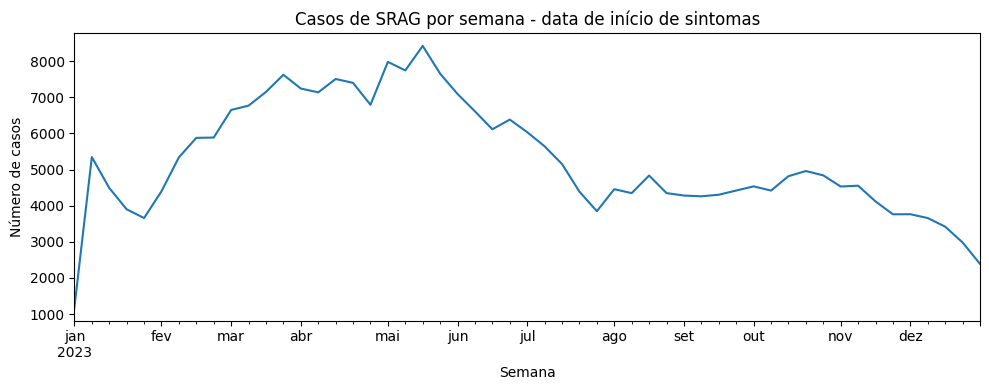

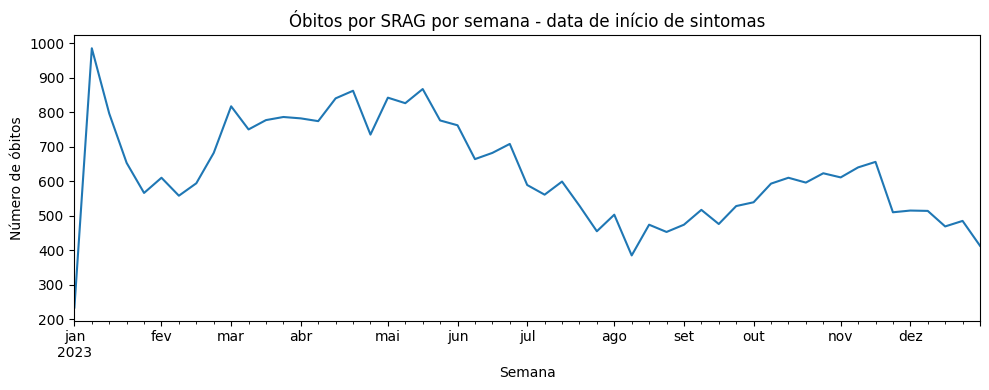

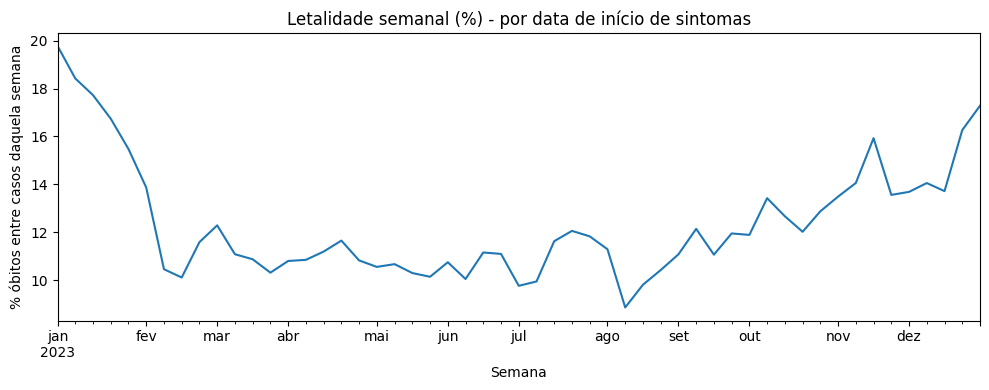

In [40]:
# Curva de casos por semana
plt.figure(figsize=(10, 4))
tempo_semana["casos"].plot()
plt.title("Casos de SRAG por semana - data de início de sintomas")
plt.ylabel("Número de casos")
plt.xlabel("Semana")
plt.tight_layout()
plt.show()

# Curva de óbitos por semana
plt.figure(figsize=(10, 4))
tempo_semana["obitos"].plot()
plt.title("Óbitos por SRAG por semana - data de início de sintomas")
plt.ylabel("Número de óbitos")
plt.xlabel("Semana")
plt.tight_layout()
plt.show()

# Letalidade bruta da semana (% óbitos / casos)
tempo_semana["letalidade_pct"] = (tempo_semana["obitos"] / tempo_semana["casos"] * 100).replace([np.inf, -np.inf], np.nan)

plt.figure(figsize=(10, 4))
tempo_semana["letalidade_pct"].plot()
plt.title("Letalidade semanal (%) - por data de início de sintomas")
plt.ylabel("% óbitos entre casos daquela semana")
plt.xlabel("Semana")
plt.tight_layout()
plt.show()


#### 1. Curvas por data de início de sintomas

As curvas semanais por `DT_SIN_PRI` mostram a **dinâmica real da circulação** dos casos de SRAG:

- os picos de casos indicam quando a transmissão estava mais intensa;
- a curva de óbitos acompanha com algum atraso ou com formato diferente, dependendo do perfil de gravidade e disponibilidade de leitos.

Além disso, a letalidade semanal (`óbitos / casos da semana`) ajuda a ver se há:

- períodos onde a doença pareceu **mais letal** (ex.: variantes mais agressivas, colapso de sistema),
- ou períodos com muita detecção de casos leves (letalidade mais baixa).

Essa visão é útil para responder perguntas do tipo:

- *“Em que momento do ano o sistema esteve mais pressionado em termos de ocorrência de casos?”*
- *“Houve períodos em que, mesmo com menos casos, a proporção de óbitos foi maior?”*

---

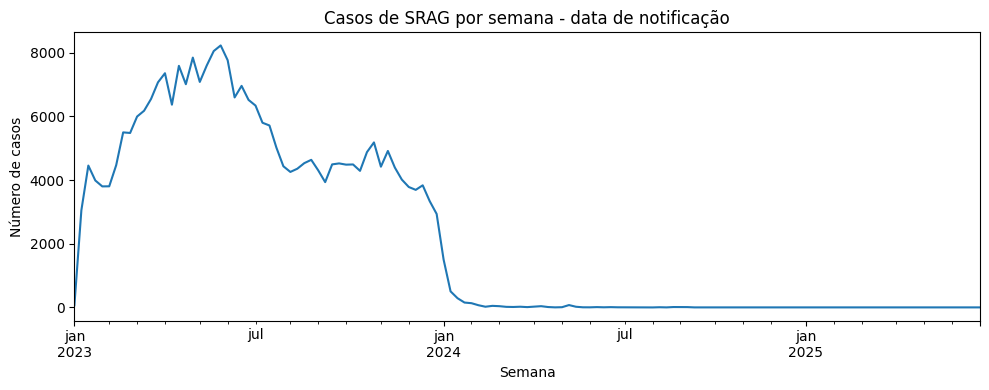

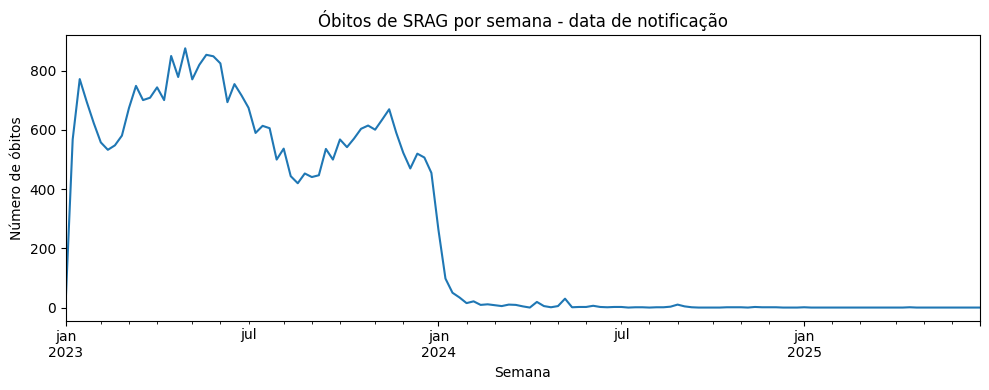

In [ ]:
# ## 2. Curvas por data de notificação (visão de pressão no sistema)
# 
# Aqui olhamos **DT_NOTIFIC** para ver quando o sistema de vigilância/hospitais receberam a carga de casos.

if "DT_NOTIFIC_date" in df.columns:
    base_not = df.dropna(subset=["DT_NOTIFIC_date"]).copy()
    base_not = base_not.sort_values("DT_NOTIFIC_date")

    casos_not_semana = (
        base_not
        .set_index("DT_NOTIFIC_date")
        .resample("W")
        .size()
        .rename("casos_not")
    )

    obitos_not_semana = (
        base_not[base_not["EVOLUCAO_BIN"] == 1]
        .set_index("DT_NOTIFIC_date")
        .resample("W")
        .size()
        .rename("obitos_not")
    )

    tempo_not_semana = pd.concat([casos_not_semana, obitos_not_semana], axis=1).fillna(0)

    plt.figure(figsize=(10, 4))
    tempo_not_semana["casos_not"].plot()
    plt.title("Casos de SRAG por semana - data de notificação")
    plt.ylabel("Número de casos")
    plt.xlabel("Semana")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    tempo_not_semana["obitos_not"].plot()
    plt.title("Óbitos de SRAG por semana - data de notificação")
    plt.ylabel("Número de óbitos")
    plt.xlabel("Semana")
    plt.tight_layout()
    plt.show()


#### 2. Curvas por data de notificação

As curvas por `DT_NOTIFIC` não contam tão bem a história da **transmissão**, mas contam a história da **carga sobre sistema de vigilância/hospital**:

- mostram quando o sistema recebeu mais notificações de uma vez;
- ajudam a identificar picos de demanda sobre a digitação, investigação e resposta.

Comparar sintomas x notificação permite enxergar:

- diferenças sistemáticas (atrasos) entre quando os casos começaram a adoecer e quando de fato foram registrados,
- possíveis períodos de acúmulo e liberação de notificações (picos artificiais por “represamento” de digitação).

---

In [ ]:
# ## 3. Atrasos entre eventos (em dias)
# 
# Vamos calcular:
# - atraso entre sintomas e notificação,
# - atraso entre sintomas e internação,
# - atraso entre sintomas e desfecho,
# - atraso entre internação e desfecho.


# Geração das colunas de atraso (mantém igual)
if {"DT_SIN_PRI_date", "DT_NOTIFIC_date"}.issubset(df.columns):
    df["ATRASO_NOTIF_SIN"] = (df["DT_NOTIFIC_date"] - df["DT_SIN_PRI_date"]).dt.days

if {"DT_SIN_PRI_date", "DT_INTERNA_date"}.issubset(df.columns):
    df["ATRASO_INTERNA_SIN"] = (df["DT_INTERNA_date"] - df["DT_SIN_PRI_date"]).dt.days

if {"DT_SIN_PRI_date", "DT_EVOLUCA_date"}.issubset(df.columns):
    df["ATRASO_EVOL_SIN"] = (df["DT_EVOLUCA_date"] - df["DT_SIN_PRI_date"]).dt.days

if {"DT_INTERNA_date", "DT_EVOLUCA_date"}.issubset(df.columns):
    df["ATRASO_EVOL_INTERNA"] = (df["DT_EVOLUCA_date"] - df["DT_INTERNA_date"]).dt.days

cols_atraso = [
    c for c in ["ATRASO_NOTIF_SIN", "ATRASO_INTERNA_SIN", "ATRASO_EVOL_SIN", "ATRASO_EVOL_INTERNA"]
    if c in df.columns
]

# Resumo robusto: mediana + P10, P25, P75, P90
resumo_atrasos = []

for col in cols_atraso:
    s = df[col].dropna()
    if s.empty:
        continue

    med = s.median()
    p10, p25, p75, p90 = s.quantile([0.10, 0.25, 0.75, 0.90])

    resumo_atrasos.append({
        "variavel": col,
        "n": len(s),
        "mediana": med,
        "p10": p10,
        "p25": p25,
        "p75": p75,
        "p90": p90,
    })

resumo_atrasos = pd.DataFrame(resumo_atrasos)
display(resumo_atrasos)


,variavel,n,mediana,p10,p25,p75,p90
0,ATRASO_NOTIF_SIN,279453,4.0,1.0,2.0,7.0,12.0
1,ATRASO_INTERNA_SIN,263176,2.0,0.0,1.0,5.0,7.0
2,ATRASO_EVOL_SIN,246182,9.0,3.0,5.0,15.0,25.0
3,ATRASO_EVOL_INTERNA,235784,5.0,2.0,3.0,10.0,21.0


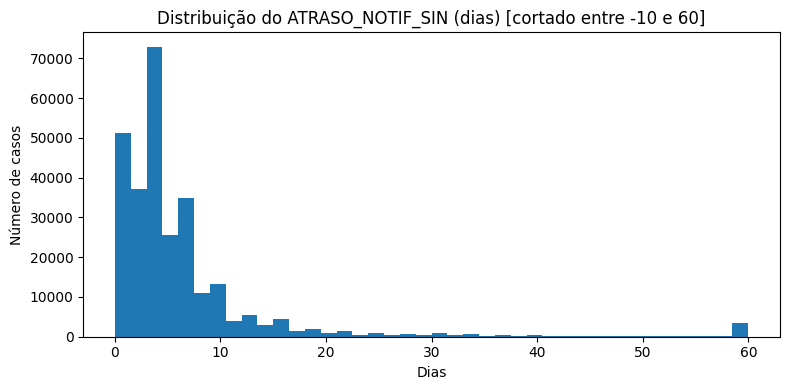

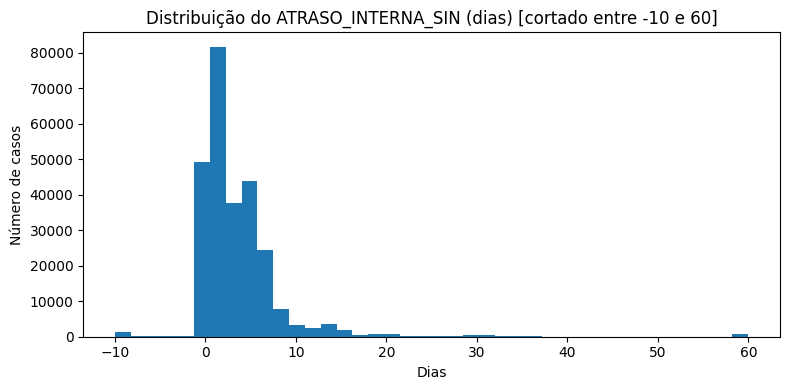

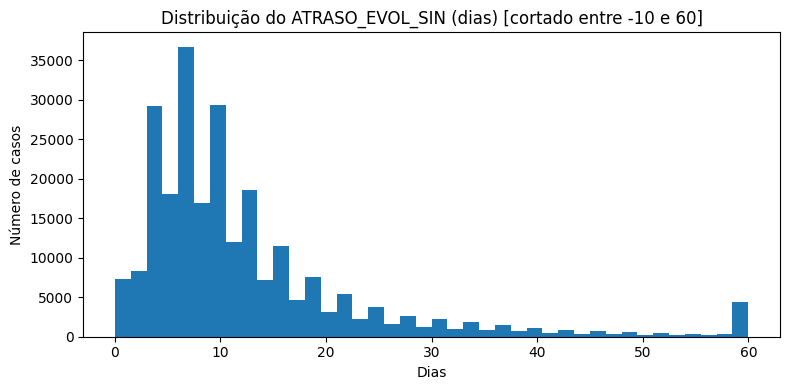

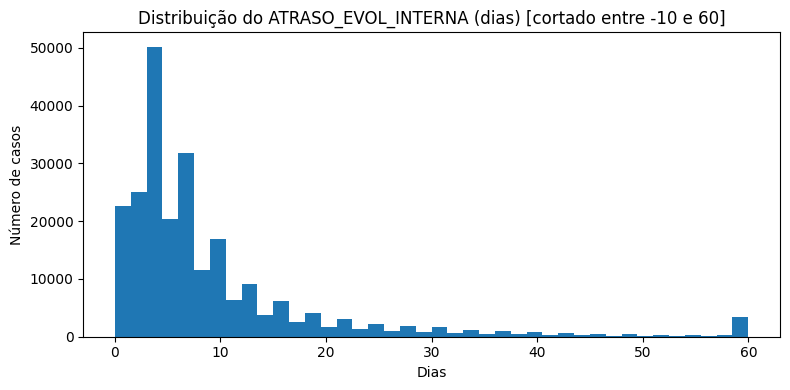

In [47]:
for col in cols_atraso:
    plt.figure(figsize=(8, 4))
    df[col].dropna().clip(-10, 60).plot(kind="hist", bins=40)
    plt.title(f"Distribuição do {col} (dias) [cortado entre -10 e 60]")
    plt.xlabel("Dias")
    plt.ylabel("Número de casos")
    plt.tight_layout()
    plt.show()


#### 3. Atrasos entre sintomas, notificação, internação e desfecho

Os atrasos em dias (mediana, percentis) respondem perguntas como:

- *“Em média, quantos dias o paciente leva para ser notificado após o início dos sintomas?”*  
  (`ATRASO_NOTIF_SIN`)
- *“Quanto tempo demora até a internação?”*  
  (`ATRASO_INTERNA_SIN`)
- *“Qual o intervalo típico entre sintomas e óbito/alta?”*  
  (`ATRASO_EVOL_SIN`)
- *“Depois que interna, em quanto tempo em média ocorre o desfecho?”*  
  (`ATRASO_EVOL_INTERNA`)

Padrões que valem atenção:

- atrasos muito longos entre sintomas e internação podem sugerir **acesso tardio** ou subvalorização inicial dos sintomas;
- atrasos muito curtos entre internação e óbito podem indicar pacientes chegando **tarde e já graves** ao hospital;
- distribuições muito assimétricas (cauda longa à direita) indicam que há subgrupos de pacientes que “fogem do padrão” e ficam muito tempo em internação antes do desfecho.

---

In [ ]:
# ## 4. Janelas de maior pressão (picos semanais)
# 
# Vamos identificar as semanas com maior:
# - número de casos,
# - número de óbitos.

if "tempo_semana" in locals():
    top_casos = tempo_semana.sort_values("casos", ascending=False).head(10)
    top_obitos = tempo_semana.sort_values("obitos", ascending=False).head(10)

    print("Top 10 semanas por número de casos (data de sintomas):")
    display(top_casos)

    print("\nTop 10 semanas por número de óbitos (data de sintomas):")
    display(top_obitos)


Top 10 semanas por número de casos (data de sintomas):


,casos,obitos,letalidade_pct
DT_SIN_PRI_date,,,
2023-05-21,8424,867,10.292023
2023-05-07,7982,842,10.548735
2023-05-14,7746,826,10.663568
2023-05-28,7656,776,10.135841
2023-03-26,7625,786,10.308197
2023-04-16,7508,840,11.188066
2023-04-23,7401,862,11.647075
2023-04-02,7244,782,10.795141
2023-03-19,7150,777,10.867133



Top 10 semanas por número de óbitos (data de sintomas):


,casos,obitos,letalidade_pct
DT_SIN_PRI_date,,,
2023-01-08,5347,985,18.421545
2023-05-21,8424,867,10.292023
2023-04-23,7401,862,11.647075
2023-05-07,7982,842,10.548735
2023-04-16,7508,840,11.188066
2023-05-14,7746,826,10.663568
2023-03-05,6651,817,12.283867
2023-01-15,4491,796,17.724338
2023-03-26,7625,786,10.308197


In [45]:
# %%
if "tempo_semana" in locals():
    top_letalidade = (
        tempo_semana[tempo_semana["casos"] >= 100]  # filtra semanas com volume mínimo
        .sort_values("letalidade_pct", ascending=False)
        .head(10)
    )
    print("Top 10 semanas por letalidade (%) entre semanas com >=100 casos:")
    display(top_letalidade)


Top 10 semanas por letalidade (%) entre semanas com >=100 casos:


,casos,obitos,letalidade_pct
DT_SIN_PRI_date,,,
2023-01-01,1183,234,19.780220
2023-01-08,5347,985,18.421545
2023-01-15,4491,796,17.724338
2023-12-31,2390,413,17.280335
2023-01-22,3901,653,16.739298
2023-12-24,2982,485,16.264252
2023-11-19,4119,656,15.926196
2023-01-29,3658,566,15.472936
2023-11-12,4554,640,14.053579


### 4. Atrasos entre eventos – por que usar mediana em vez de média?

Os atrasos em dias (entre sintomas, notificação, internação e desfecho) não seguem uma distribuição “bonitinha” e sim:

- têm **cauda longa à direita** (alguns casos com atrasos muito grandes),
- podem ter até valores negativos (datas invertidas/erro de digitação),
- e em geral são bem assimétricos.

Nessas condições, **média e desvio-padrão** ficam pouco informativos:

- a média é puxada por poucos casos com atraso extremo,
- o desvio-padrão explode e deixa de representar a “variação típica”.

Por isso, nesta análise de tempo optamos por descrever os atrasos com:

- **mediana** (valor “típico”, onde metade dos casos está abaixo e metade acima),
- **P10 e P90** (percentis 10 e 90 → onde estão os 10% mais rápidos e os 10% mais lentos),
- **P25 e P75** (quartis → definem o intervalo interquartil, onde está a massa central dos casos).

Essa escolha é mais robusta a outliers e permite interpretações do tipo:

- "Em metade dos pacientes, o atraso entre sintomas e internação é de **X dias ou menos**."
- "90% dos pacientes são internados em até **Y dias** após o início dos sintomas."
- "O grosso dos casos (P25–P75) se concentra entre **A e B dias**, os demais são cauda."

Com isso, conseguimos descrever a dinâmica temporal de forma mais fiel à realidade da base, sem deixar que alguns poucos valores extremos distorçam a leitura.

In [50]:
def plot_semana_com_referencia(serie, titulo, ylabel):
    """
    Plota série semanal com:
    - valores semanais originais
    - média móvel 2 semanas
    - média móvel 4 semanas
    - linha horizontal da média do período
    - linha horizontal da mediana do período
    """
    s = serie.dropna()

    if s.empty:
        print(f"Série vazia para: {titulo}")
        return

    mean_val = s.mean()
    median_val = s.median()

    # média móvel em janelas de 2 e 4 semanas (sobre série semanal)
    mm_2 = s.rolling(window=2, min_periods=1).mean()
    mm_4 = s.rolling(window=4, min_periods=1).mean()

    plt.figure(figsize=(10, 4))

    # série bruta
    plt.plot(s.index, s.values, label="Valor semanal", alpha=0.4)

    # médias móveis
    plt.plot(mm_2.index, mm_2.values, label="Média móvel 2 semanas")
    plt.plot(mm_4.index, mm_4.values, label="Média móvel 4 semanas")

    # média e mediana do período
    plt.axhline(mean_val, linestyle="--", label=f"Média período ({mean_val:.1f})")
    plt.axhline(median_val, linestyle=":", label=f"Mediana período ({median_val:.1f})")

    plt.title(titulo)
    plt.ylabel(ylabel)
    plt.xlabel("Semana")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [51]:
# base por DT_SIN_PRI_date
base = df.dropna(subset=["DT_SIN_PRI_date"]).copy()
base = base.sort_values("DT_SIN_PRI_date")

casos_semana = (
    base
    .set_index("DT_SIN_PRI_date")
    .resample("W")
    .size()
    .rename("casos")
)

obitos_semana = (
    base[base["EVOLUCAO_BIN"] == 1]
    .set_index("DT_SIN_PRI_date")
    .resample("W")
    .size()
    .rename("obitos")
)

tempo_semana = pd.concat([casos_semana, obitos_semana], axis=1).fillna(0)
tempo_semana["letalidade_pct"] = (
    tempo_semana["obitos"] / tempo_semana["casos"] * 100
).replace([np.inf, -np.inf], np.nan)


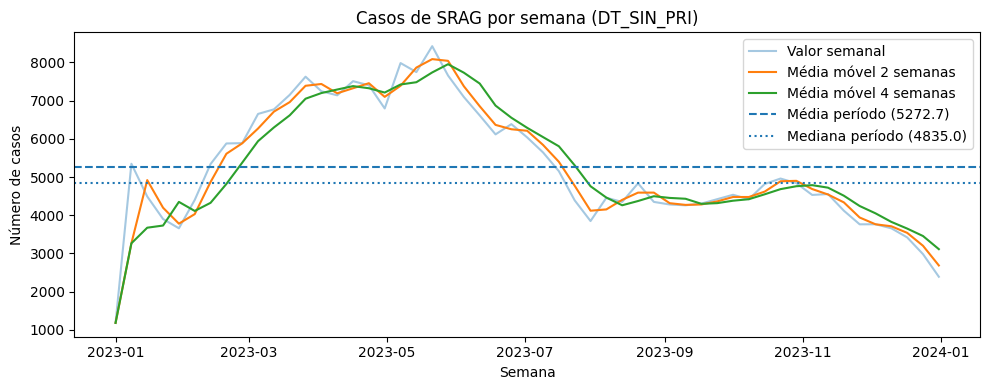

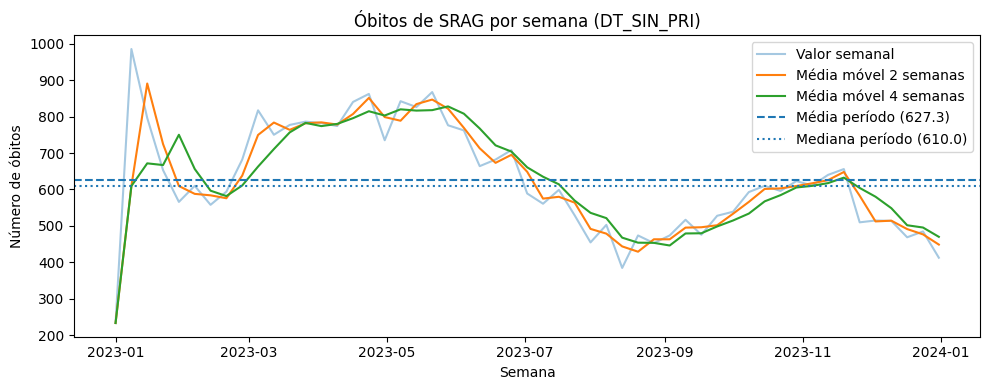

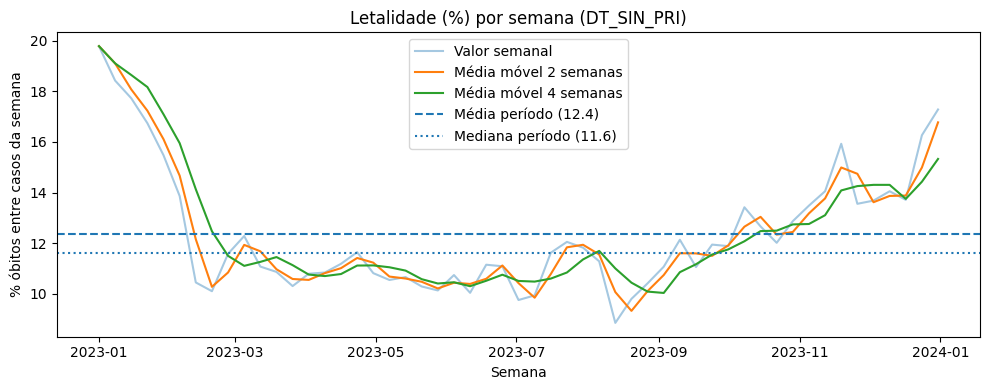

In [52]:
# Casos por semana (DT_SIN_PRI)
plot_semana_com_referencia(
    tempo_semana["casos"],
    titulo="Casos de SRAG por semana (DT_SIN_PRI)",
    ylabel="Número de casos"
)

# Óbitos por semana (DT_SIN_PRI)
plot_semana_com_referencia(
    tempo_semana["obitos"],
    titulo="Óbitos de SRAG por semana (DT_SIN_PRI)",
    ylabel="Número de óbitos"
)

# Letalidade semanal (%), com séries possivelmente mais ruidosas
plot_semana_com_referencia(
    tempo_semana["letalidade_pct"],
    titulo="Letalidade (%) por semana (DT_SIN_PRI)",
    ylabel="% óbitos entre casos da semana"
)


In [53]:
if "DT_NOTIFIC_date" in df.columns:
    base_not = df.dropna(subset=["DT_NOTIFIC_date"]).copy()
    base_not = base_not.sort_values("DT_NOTIFIC_date")

    casos_not_semana = (
        base_not
        .set_index("DT_NOTIFIC_date")
        .resample("W")
        .size()
        .rename("casos_not")
    )

    obitos_not_semana = (
        base_not[base_not["EVOLUCAO_BIN"] == 1]
        .set_index("DT_NOTIFIC_date")
        .resample("W")
        .size()
        .rename("obitos_not")
    )

    tempo_not_semana = pd.concat([casos_not_semana, obitos_not_semana], axis=1).fillna(0)
    tempo_not_semana["letalidade_pct"] = (
        tempo_not_semana["obitos_not"] / tempo_not_semana["casos_not"] * 100
    ).replace([np.inf, -np.inf], np.nan)


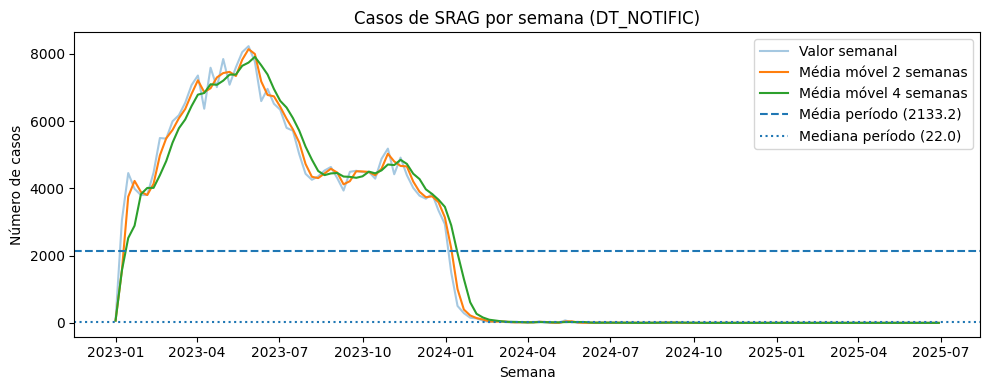

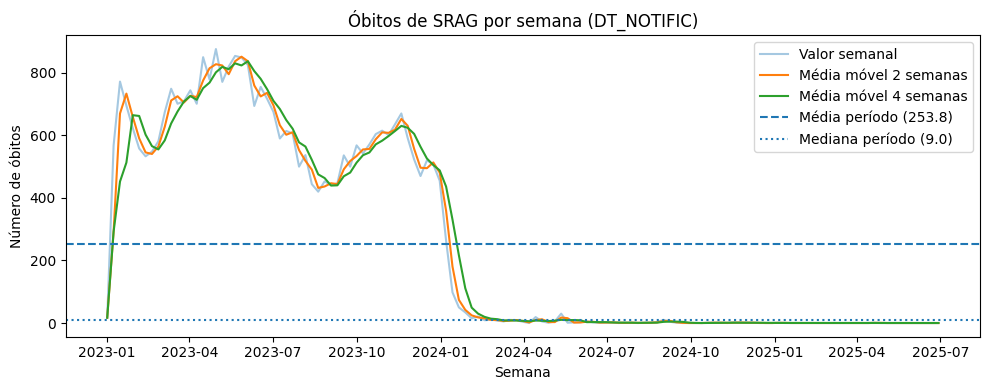

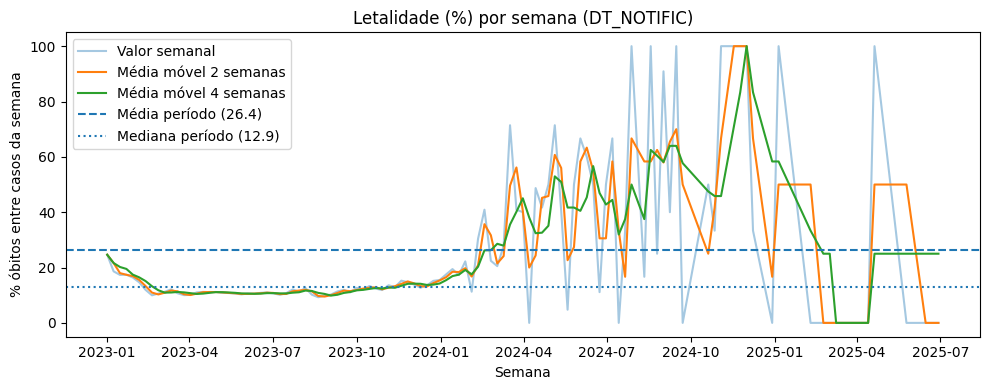

In [54]:
# Casos por semana (DT_NOTIFIC)
plot_semana_com_referencia(
    tempo_not_semana["casos_not"],
    titulo="Casos de SRAG por semana (DT_NOTIFIC)",
    ylabel="Número de casos"
)

# Óbitos por semana (DT_NOTIFIC)
plot_semana_com_referencia(
    tempo_not_semana["obitos_not"],
    titulo="Óbitos de SRAG por semana (DT_NOTIFIC)",
    ylabel="Número de óbitos"
)

# Letalidade semanal (%) por DT_NOTIFIC
plot_semana_com_referencia(
    tempo_not_semana["letalidade_pct"],
    titulo="Letalidade (%) por semana (DT_NOTIFIC)",
    ylabel="% óbitos entre casos da semana"
)


#### Linhas de referência e médias móveis nos gráficos semanais

Nos gráficos semanais de casos, óbitos e letalidade, incluímos quatro camadas de informação:

1. **Valor semanal bruto**  
   A linha original representa o número de casos/óbitos ou a letalidade calculada em cada semana.

2. **Linha horizontal da média do período**  
   Mostra o valor médio ao longo de todo o intervalo analisado.  
   Serve como “nível de referência”: semanas acima dessa linha estão acima do padrão médio do período.

3. **Linha horizontal da mediana do período**  
   A mediana é menos sensível a semanas extremas.  
   Ela indica o “valor típico”: metade das semanas está abaixo, metade acima.

4. **Médias móveis em janelas de 2 e 4 semanas**  
   Como já estamos trabalhando com séries agregadas por semana, usamos janelas de:
   - **2 semanas** → suaviza variação pontual, mas ainda reage rápido às mudanças.
   - **4 semanas** → suavização mais forte, capturando a tendência de médio prazo.

Essas médias móveis ajudam a:

- enxergar a tendência geral sem ser enganado por alta/baixa isolada numa semana,
- comparar picos locais com o “patamar” médio/mediano,
- identificar períodos em que a tendência de casos, óbitos ou letalidade está claramente subindo ou caindo.

Em resumo:  
a linha semanal mostra o “ruído real”,  
a mediana/média mostram o “nível de fundo”,  
e as médias móveis mostram “para onde a curva está indo”.


In [55]:
def plot_diaria_com_referencia(serie, titulo, ylabel):
    """
    Série diária com:
    - valor diário bruto
    - média móvel 7 dias
    - média móvel 14 dias
    - linha horizontal da média do período
    - linha horizontal da mediana do período
    """
    s = serie.dropna()

    if s.empty:
        print(f"Série vazia para: {titulo}")
        return

    mean_val = s.mean()
    median_val = s.median()

    mm_7 = s.rolling(window=7, min_periods=1).mean()
    mm_14 = s.rolling(window=14, min_periods=1).mean()

    plt.figure(figsize=(12, 4))

    plt.plot(s.index, s.values, label="Valor diário", alpha=0.3)
    plt.plot(mm_7.index, mm_7.values, label="Média móvel 7 dias")
    plt.plot(mm_14.index, mm_14.values, label="Média móvel 14 dias")

    plt.axhline(mean_val, linestyle="--", label=f"Média período ({mean_val:.1f})")
    plt.axhline(median_val, linestyle=":", label=f"Mediana período ({median_val:.1f})")

    plt.title(titulo)
    plt.ylabel(ylabel)
    plt.xlabel("Data")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [56]:
# Garantir datetime e EVOLUCAO_BIN
df["EVOLUCAO_BIN"] = pd.to_numeric(df["EVOLUCAO_BIN"], errors="coerce")
df["DT_SIN_PRI_date"] = pd.to_datetime(df["DT_SIN_PRI"], errors="coerce")

base_sin = df.dropna(subset=["DT_SIN_PRI_date"]).copy()
base_sin = base_sin.sort_values("DT_SIN_PRI_date")

# Casos diários (por data de sintomas)
casos_sin_dia = (
    base_sin
    .set_index("DT_SIN_PRI_date")
    .resample("D")
    .size()
    .rename("casos")
)

# Óbitos diários (por data de sintomas)
obitos_sin_dia = (
    base_sin[base_sin["EVOLUCAO_BIN"] == 1]
    .set_index("DT_SIN_PRI_date")
    .resample("D")
    .size()
    .rename("obitos")
)

tempo_sin_dia = pd.concat([casos_sin_dia, obitos_sin_dia], axis=1).fillna(0)

# Letalidade diária: só calcula onde há pelo menos 1 caso
tempo_sin_dia["letalidade_pct"] = np.where(
    tempo_sin_dia["casos"] > 0,
    tempo_sin_dia["obitos"] / tempo_sin_dia["casos"] * 100,
    np.nan
)

tempo_sin_dia.head()


,casos,obitos,letalidade_pct
DT_SIN_PRI_date,,,
2023-01-01,1183,234,19.780220
2023-01-02,973,179,18.396711
2023-01-03,823,146,17.739976
2023-01-04,720,121,16.805556
2023-01-05,745,141,18.926174


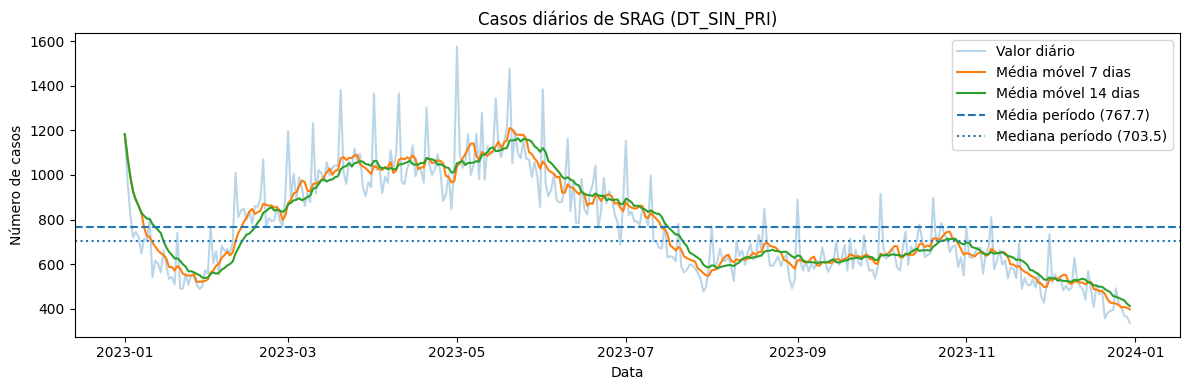

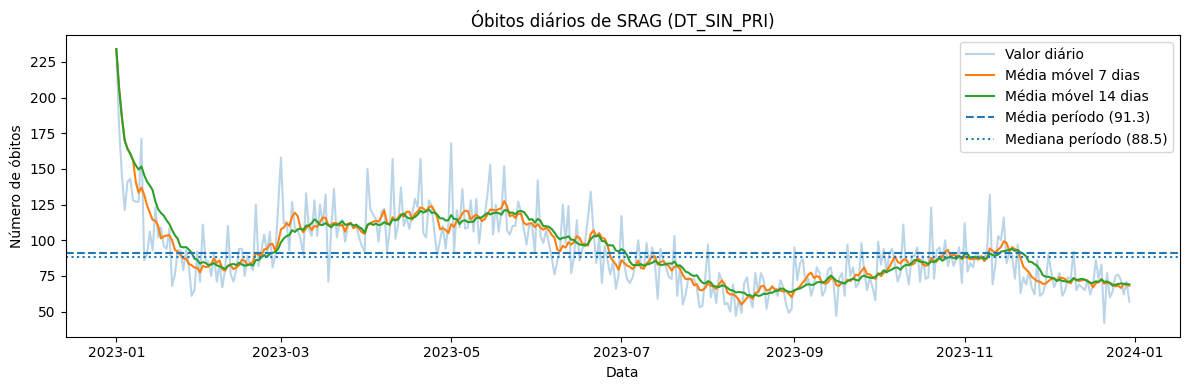

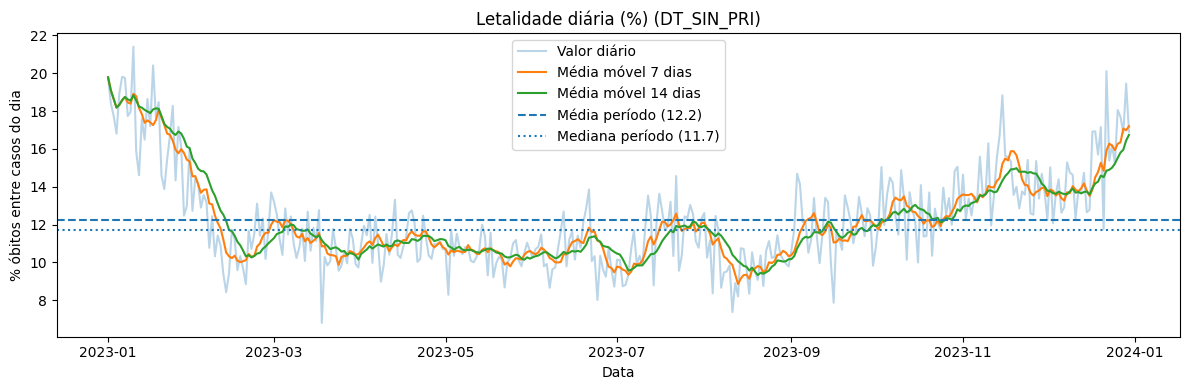

In [57]:
# Casos diários por DT_SIN_PRI
plot_diaria_com_referencia(
    tempo_sin_dia["casos"],
    titulo="Casos diários de SRAG (DT_SIN_PRI)",
    ylabel="Número de casos"
)

# Óbitos diários por DT_SIN_PRI
plot_diaria_com_referencia(
    tempo_sin_dia["obitos"],
    titulo="Óbitos diários de SRAG (DT_SIN_PRI)",
    ylabel="Número de óbitos"
)

# Letalidade diária por DT_SIN_PRI
plot_diaria_com_referencia(
    tempo_sin_dia["letalidade_pct"],
    titulo="Letalidade diária (%) (DT_SIN_PRI)",
    ylabel="% óbitos entre casos do dia"
)


In [58]:
df["DT_NOTIFIC_date"] = pd.to_datetime(df["DT_NOTIFIC"], errors="coerce")

base_not = df.dropna(subset=["DT_NOTIFIC_date"]).copy()
base_not = base_not.sort_values("DT_NOTIFIC_date")

# Casos diários (por data de notificação)
casos_not_dia = (
    base_not
    .set_index("DT_NOTIFIC_date")
    .resample("D")
    .size()
    .rename("casos_not")
)

# Óbitos diários (por data de notificação)
obitos_not_dia = (
    base_not[base_not["EVOLUCAO_BIN"] == 1]
    .set_index("DT_NOTIFIC_date")
    .resample("D")
    .size()
    .rename("obitos_not")
)

tempo_not_dia = pd.concat([casos_not_dia, obitos_not_dia], axis=1).fillna(0)

tempo_not_dia["letalidade_pct"] = np.where(
    tempo_not_dia["casos_not"] > 0,
    tempo_not_dia["obitos_not"] / tempo_not_dia["casos_not"] * 100,
    np.nan
)

tempo_not_dia.head()


,casos_not,obitos_not,letalidade_pct
DT_NOTIFIC_date,,,
2023-01-01,69,17.0,24.637681
2023-01-02,233,51.0,21.888412
2023-01-03,407,79.0,19.410319
2023-01-04,502,94.0,18.725100
2023-01-05,626,114.0,18.210863


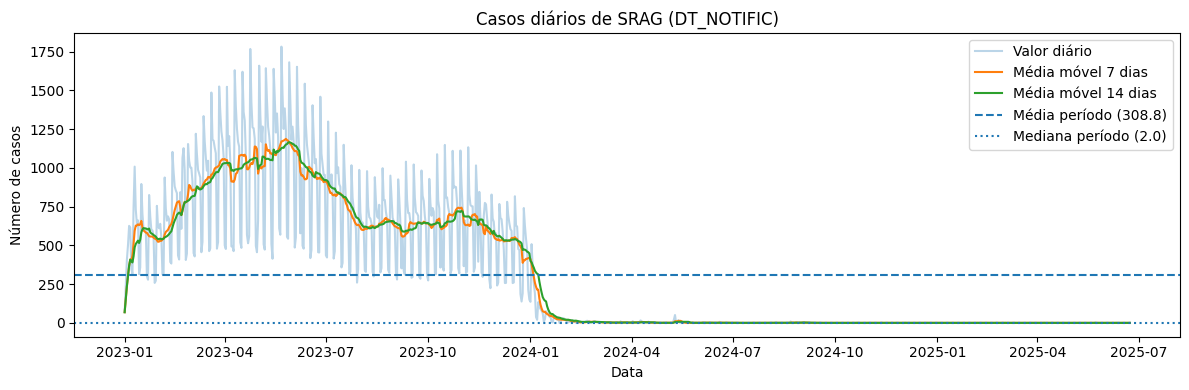

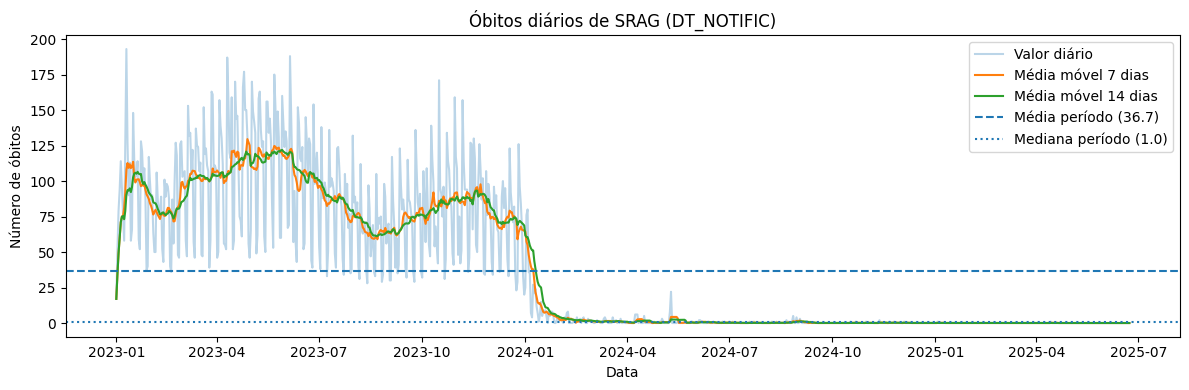

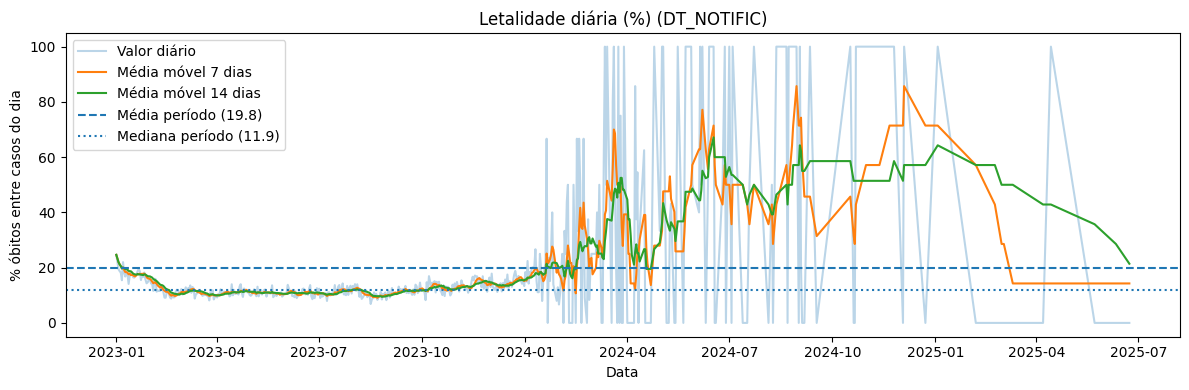

In [59]:
# Casos diários por DT_NOTIFIC
plot_diaria_com_referencia(
    tempo_not_dia["casos_not"],
    titulo="Casos diários de SRAG (DT_NOTIFIC)",
    ylabel="Número de casos"
)

# Óbitos diários por DT_NOTIFIC
plot_diaria_com_referencia(
    tempo_not_dia["obitos_not"],
    titulo="Óbitos diários de SRAG (DT_NOTIFIC)",
    ylabel="Número de óbitos"
)

# Letalidade diária por DT_NOTIFIC
plot_diaria_com_referencia(
    tempo_not_dia["letalidade_pct"],
    titulo="Letalidade diária (%) (DT_NOTIFIC)",
    ylabel="% óbitos entre casos do dia"
)


#### Versão diária: suavização de 7 e 14 dias

Além da visão semanal, construímos séries **diárias** de casos, óbitos e letalidade, tanto por:
- data de início de sintomas (`DT_SIN_PRI`),
- quanto por data de notificação (`DT_NOTIFIC`).

Para reduzir o ruído natural do dia a dia, usamos:
- **média móvel de 7 dias** → suaviza variações de fim de semana e picos pontuais;
- **média móvel de 14 dias** → tendência mais lenta, mostrando a direção geral da curva.

As linhas horizontais de **média** e **mediana** do período ajudam a comparar cada dia com o “nível típico” da série:
- acima da mediana/média → dias de carga acima do normal,
- abaixo → dias relativamente mais tranquilos.

Essa visão diária é útil para:
- detectar viradas rápidas na curva (início de subida/queda),
- enxergar efeitos de sazonalidade de curto prazo (ex.: padrões de notificação por dia da semana),
- e alinhar com eventos pontuais (feriados, mudanças de política, etc.).


In [63]:
# Garantir tipos
df["DT_SIN_PRI_date"] = pd.to_datetime(df["DT_SIN_PRI_date"], errors="coerce")
df["EVOLUCAO_BIN"] = pd.to_numeric(df["EVOLUCAO_BIN"], errors="coerce")

base_sin = df.dropna(subset=["DT_SIN_PRI_date"]).copy()
base_sin = base_sin.sort_values("DT_SIN_PRI_date")

# ---------- Séries diárias ----------
casos_dia = (
    base_sin
    .set_index("DT_SIN_PRI_date")
    .resample("D")
    .size()
    .rename("casos")
)

obitos_dia = (
    base_sin[base_sin["EVOLUCAO_BIN"] == 1]
    .set_index("DT_SIN_PRI_date")
    .resample("D")
    .size()
    .rename("obitos")
)

tempo_dia = pd.concat([casos_dia, obitos_dia], axis=1).fillna(0)
tempo_dia["letalidade_pct"] = np.where(
    tempo_dia["casos"] > 0,
    tempo_dia["obitos"] / tempo_dia["casos"] * 100,
    np.nan
)

# ---------- Séries semanais ----------
casos_sem = (
    base_sin
    .set_index("DT_SIN_PRI_date")
    .resample("W")
    .size()
    .rename("casos")
)

obitos_sem = (
    base_sin[base_sin["EVOLUCAO_BIN"] == 1]
    .set_index("DT_SIN_PRI_date")
    .resample("W")
    .size()
    .rename("obitos")
)

tempo_sem = pd.concat([casos_sem, obitos_sem], axis=1).fillna(0)
tempo_sem["letalidade_pct"] = np.where(
    tempo_sem["casos"] > 0,
    tempo_sem["obitos"] / tempo_sem["casos"] * 100,
    np.nan
)

# ---------- Séries mensais ----------
casos_mes = (
    base_sin
    .set_index("DT_SIN_PRI_date")
    .resample("M")
    .size()
    .rename("casos")
)

obitos_mes = (
    base_sin[base_sin["EVOLUCAO_BIN"] == 1]
    .set_index("DT_SIN_PRI_date")
    .resample("M")
    .size()
    .rename("obitos")
)

tempo_mes = pd.concat([casos_mes, obitos_mes], axis=1).fillna(0)
tempo_mes["letalidade_pct"] = np.where(
    tempo_mes["casos"] > 0,
    tempo_mes["obitos"] / tempo_mes["casos"] * 100,
    np.nan
)

tempo_dia.head(), tempo_sem.head(), tempo_mes.head()

C:\Users\Adriano Dantas\AppData\Local\Temp\ipykernel_26704\3685878084.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  base_sin
C:\Users\Adriano Dantas\AppData\Local\Temp\ipykernel_26704\3685878084.py:66: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  base_sin[base_sin["EVOLUCAO_BIN"] == 1]


(                 casos  obitos  letalidade_pct
 DT_SIN_PRI_date                               
 2023-01-01        1183     234       19.780220
 2023-01-02         973     179       18.396711
 2023-01-03         823     146       17.739976
 2023-01-04         720     121       16.805556
 2023-01-05         745     141       18.926174,
                  casos  obitos  letalidade_pct
 DT_SIN_PRI_date                               
 2023-01-01        1183     234       19.780220
 2023-01-08        5347     985       18.421545
 2023-01-15        4491     796       17.724338
 2023-01-22        3901     653       16.739298
 2023-01-29        3658     566       15.472936,
                  casos  obitos  letalidade_pct
 DT_SIN_PRI_date                               
 2023-01-31       19711    3397       17.234032
 2023-02-28       22047    2495       11.316732
 2023-03-31       31379    3426       10.918130
 2023-04-30       31228    3483       11.153452
 2023-05-31       34719    3623       

In [64]:
def kpi_temporal(tempo, min_cases_for_letalidade=0):
    """
    tempo: DataFrame com index = data e colunas [casos, obitos, letalidade_pct]
    min_cases_for_letalidade: mínimo de casos para considerar na busca da maior letalidade
                              (para evitar dias com 1 caso e 100% de letalidade)
    """
    out = {}

    # pico de casos
    idx_c = tempo["casos"].idxmax()
    row_c = tempo.loc[idx_c]

    # pico de óbitos
    idx_o = tempo["obitos"].idxmax()
    row_o = tempo.loc[idx_o]

    # pico de letalidade (com filtro de volume)
    tmp = tempo[tempo["casos"] >= min_cases_for_letalidade].copy()
    if not tmp.empty:
        idx_l = tmp["letalidade_pct"].idxmax()
        row_l = tmp.loc[idx_l]
    else:
        idx_l, row_l = None, None

    # resumo
    out["data_max_casos"] = idx_c
    out["casos_max_casos"] = row_c["casos"]
    out["obitos_no_dia_da_max_casos"] = row_c["obitos"]
    out["letalidade_no_dia_da_max_casos"] = row_c["letalidade_pct"]

    out["data_max_obitos"] = idx_o
    out["casos_no_dia_da_max_obitos"] = row_o["casos"]
    out["obitos_max_obitos"] = row_o["obitos"]
    out["letalidade_no_dia_da_max_obitos"] = row_o["letalidade_pct"]

    if idx_l is not None:
        out["data_max_letalidade"] = idx_l
        out["casos_no_dia_da_max_letalidade"] = row_l["casos"]
        out["obitos_no_dia_da_max_letalidade"] = row_l["obitos"]
        out["letalidade_max_letalidade"] = row_l["letalidade_pct"]
    else:
        out["data_max_letalidade"] = None

    # estatísticas de base
    out["media_casos"] = tempo["casos"].mean()
    out["mediana_casos"] = tempo["casos"].median()
    out["media_obitos"] = tempo["obitos"].mean()
    out["mediana_obitos"] = tempo["obitos"].median()
    out["media_letalidade"] = tempo["letalidade_pct"].mean(skipna=True)
    out["mediana_letalidade"] = tempo["letalidade_pct"].median(skipna=True)

    # concentração nos picos
    total_cases = tempo["casos"].sum()
    total_deaths = tempo["obitos"].sum()
    out["share_cases_max_casos"] = row_c["casos"] / total_cases if total_cases > 0 else np.nan
    out["share_deaths_max_obitos"] = row_o["obitos"] / total_deaths if total_deaths > 0 else np.nan

    return out


In [65]:
kpi_dia    = kpi_temporal(tempo_dia, min_cases_for_letalidade=500)
kpi_semana = kpi_temporal(tempo_sem, min_cases_for_letalidade=2000)
kpi_mes    = kpi_temporal(tempo_mes, min_cases_for_letalidade=15000)

kpi_dia, kpi_semana, kpi_mes


({'data_max_casos': Timestamp('2023-05-01 00:00:00'),
  'casos_max_casos': np.float64(1575.0),
  'obitos_no_dia_da_max_casos': np.float64(168.0),
  'letalidade_no_dia_da_max_casos': np.float64(10.666666666666668),
  'data_max_obitos': Timestamp('2023-01-01 00:00:00'),
  'casos_no_dia_da_max_obitos': np.float64(1183.0),
  'obitos_max_obitos': np.float64(234.0),
  'letalidade_no_dia_da_max_obitos': np.float64(19.78021978021978),
  'data_max_letalidade': Timestamp('2023-01-10 00:00:00'),
  'casos_no_dia_da_max_letalidade': np.float64(799.0),
  'obitos_no_dia_da_max_letalidade': np.float64(171.0),
  'letalidade_max_letalidade': np.float64(21.401752190237797),
  'media_casos': np.float64(767.728021978022),
  'mediana_casos': np.float64(703.5),
  'media_obitos': np.float64(91.33241758241758),
  'mediana_obitos': np.float64(88.5),
  'media_letalidade': np.float64(12.227728436964409),
  'mediana_letalidade': np.float64(11.712741006449832),
  'share_cases_max_casos': np.float64(0.00563601034878

In [66]:
def kpi_dict_to_series(kpi_dict, nivel):
    s = pd.Series(kpi_dict)
    s.name = nivel
    return s

kpis_temporais = pd.concat([
    kpi_dict_to_series(kpi_dia, "dia"),
    kpi_dict_to_series(kpi_semana, "semana"),
    kpi_dict_to_series(kpi_mes, "mes"),
], axis=1)

kpis_temporais


,dia,semana,mes
data_max_casos,2023-05-01 00:00:00,2023-05-21 00:00:00,2023-05-31 00:00:00
casos_max_casos,1575.0,8424.0,34719.0
obitos_no_dia_da_max_casos,168.0,867.0,3623.0
letalidade_no_dia_da_max_casos,10.666667,10.292023,10.435208
data_max_obitos,2023-01-01 00:00:00,2023-01-08 00:00:00,2023-05-31 00:00:00
casos_no_dia_da_max_obitos,1183.0,5347.0,34719.0
obitos_max_obitos,234.0,985.0,3623.0
letalidade_no_dia_da_max_obitos,19.78022,18.421545,10.435208
data_max_letalidade,2023-01-10 00:00:00,2023-01-08 00:00:00,2023-01-31 00:00:00
casos_no_dia_da_max_letalidade,799.0,5347.0,19711.0


In [67]:
def kpi_pressao(tempo):
    s = tempo["casos"]
    return {
        "n_periodos": len(s),
        "total_casos": int(s.sum()),
        "total_obitos": int(tempo["obitos"].sum()),
        "limiar_q3_casos": float(s.quantile(0.75)),
        "n_periodos_acima_q3": int((s > s.quantile(0.75)).sum()),
        "n_periodos_acima_mediana": int((s > s.median()).sum()),
        "n_periodos_sem_casos": int((s == 0).sum()),
        "n_periodos_>2x_media": int((s > 2 * s.mean()).sum()),
        "n_periodos_>2x_mediana": int((s > 2 * s.median()).sum()),
    }

pressao_dia    = kpi_pressao(tempo_dia)
pressao_semana = kpi_pressao(tempo_sem)
pressao_mes    = kpi_pressao(tempo_mes)

pressao_dia, pressao_semana, pressao_mes


({'n_periodos': 364,
  'total_casos': 279453,
  'total_obitos': 33245,
  'limiar_q3_casos': 959.25,
  'n_periodos_acima_q3': 91,
  'n_periodos_acima_mediana': 182,
  'n_periodos_sem_casos': 0,
  'n_periodos_>2x_media': 1,
  'n_periodos_>2x_mediana': 2},
 {'n_periodos': 53,
  'total_casos': 279453,
  'total_obitos': 33245,
  'limiar_q3_casos': 6651.0,
  'n_periodos_acima_q3': 13,
  'n_periodos_acima_mediana': 26,
  'n_periodos_sem_casos': 0,
  'n_periodos_>2x_media': 0,
  'n_periodos_>2x_mediana': 0},
 {'n_periodos': 12,
  'total_casos': 279453,
  'total_obitos': 33245,
  'limiar_q3_casos': 28324.75,
  'n_periodos_acima_q3': 3,
  'n_periodos_acima_mediana': 6,
  'n_periodos_sem_casos': 0,
  'n_periodos_>2x_media': 0,
  'n_periodos_>2x_mediana': 0})

### KPIs temporais – por data de início de sintomas (DT_SIN_PRI)

#### 1. Visão diária

- **Dia com maior número de casos**  
  - Data: **2023-05-01**  
  - Casos: **1.575**  
  - Óbitos: **168**  
  - Letalidade no dia: **10,7%**  
  - Esse único dia concentra cerca de **0,6%** de todos os casos do ano.

- **Dia com maior número de óbitos**  
  - Data: **2023-01-01**  
  - Casos: **1.183**  
  - Óbitos: **234**  
  - Letalidade no dia: **19,8%**  
  - Esse dia concentra cerca de **0,7%** de todas as mortes do período.

- **Dia com maior letalidade (entre dias com ≥ 500 casos)**  
  - Data: **2023-01-10**  
  - Casos: **799**  
  - Óbitos: **171**  
  - Letalidade: **21,4%**  

- **Níveis típicos diários**  
  - Casos diários – média ≈ **768**, mediana ≈ **704**  
  - Óbitos diários – média ≈ **91**, mediana ≈ **89**  
  - Letalidade diária – média ≈ **12,2%**, mediana ≈ **11,7%**

- **Concentração / extremos**  
  - Total de dias com casos: **364**  
  - Dias com casos > 2× média diária: **1** (pico muito pontual)  
  - Dias com casos > 2× mediana: **2**  
  - Dias com zero casos: **0**

---

#### 2. Visão semanal

> Semanas aqui são agregadas com término no domingo (freq = `W-SUN`).

- **Semana com maior número de casos**  
  - Semana encerrada em **2023-05-21**  
  - Casos: **8.424**  
  - Óbitos: **867**  
  - Letalidade na semana: **10,3%**  
  - Essa semana concentra cerca de **3,0%** de todos os casos do ano.

- **Semana com maior número de óbitos**  
  - Semana encerrada em **2023-01-08**  
  - Casos: **5.347**  
  - Óbitos: **985**  
  - Letalidade na semana: **18,4%**  
  - Essa mesma semana é também a de **maior letalidade** (com volume adequado de casos).  
  - Concentra cerca de **3,0%** de todas as mortes do período.

- **Níveis típicos semanais**  
  - Casos semanais – média ≈ **5.273**, mediana ≈ **4.835**  
  - Óbitos semanais – média ≈ **627**, mediana ≈ **610**  
  - Letalidade semanal – média ≈ **12,4%**, mediana ≈ **11,6%**

- **Pressão ao longo das semanas**  
  - Número de semanas no período: **53**  
  - Semanas com casos acima do 3º quartil (Q3 ≈ 6.651 casos): **13** → janela de **alta circulação**.  
  - Semanas com casos acima da mediana: **26** (metade do ano em “meia-para-cima”).  
  - Semanas sem casos: **0**.  
  - Não há semana com casos > 2× média ou > 2× mediana → o padrão semanal é mais “distribuído” do que o pico diário.

---

#### 3. Visão mensal

> O índice mensal está na última data de cada mês (ex.: `2023-05-31` representa maio/2023).

- **Mês com maior número de casos e maior número de óbitos**  
  - Mês: **maio/2023** (indexado como 2023-05-31)  
  - Casos: **34.719**  
  - Óbitos: **3.623**  
  - Letalidade no mês: **10,4%**  
  - Esse mês sozinho concentra cerca de **12,4%** de todos os casos  
    e **10,9%** de todos os óbitos do ano.

- **Mês com maior letalidade**  
  - Mês: **janeiro/2023** (indexado como 2023-01-31)  
  - Casos: **19.711**  
  - Óbitos: **3.397**  
  - Letalidade: **17,2%**  
  - Menos casos que maio, mas letalidade bem mais alta.

- **Níveis típicos mensais**  
  - Casos mensais – média ≈ **23.288**, mediana ≈ **21.367**  
  - Óbitos mensais – média ≈ **2.770**, mediana ≈ **2.609**  
  - Letalidade mensal – média ≈ **12,2%**, mediana ≈ **11,3%**

- **Concentração em picos mensais**  
  - Número de meses: **12**  
  - Meses com casos acima do 3º quartil (Q3 ≈ 28.325 casos): **3**  
  - Metade dos meses acima da mediana de casos (6 meses)  
  - Meses com zero casos: **0**

---

### 4. Outros KPIs que esse bloco habilita

Com essas estruturas (dia/semana/mês) já dá pra extrair mais KPIs interessantes, por exemplo:

- **Amplitude temporal da onda principal**  
  - Número de semanas consecutivas acima da mediana de casos.  
  - Número de semanas consecutivas acima do 3º quartil (definindo uma “onda epidêmica”).

- **Comparação entre picos de casos e picos de letalidade**  
  - O pico de casos (maio/2023) não coincide com o pico de letalidade (janeiro/2023), sugerindo:
    - mudança de variante,
    - mudança na cobertura vacinal,
    - ou saturação/desafogo do sistema em momentos distintos.

- **Relação entre níveis típicos e picos**  
  - Razão `max_casos / mediana_casos` por nível (dia, semana, mês) como índice de “violência” do pico.  
    - Nos dias: o pico diário tem cerca de **2,2×** a mediana de casos.  
    - Nas semanas: o pico semanal tem cerca de **1,7×** a mediana.  
    - Nos meses: o pico mensal tem cerca de **1,6×** a mediana.  
  - Isso mostra que a **concentração extrema está mais visível na escala diária**; na mensal o sistema “dilui” a pancada.


---

In [68]:
def plot_trend_temporal(serie, titulo, ylabel):
    """
    Plota:
    - valor diário (fraco)
    - média móvel 7 dias
    - média móvel 14 dias
    - linha de tendência (reta) ajustada sobre a MM7
    """
    s = serie.dropna()
    if s.empty:
        print(f"Série vazia para: {titulo}")
        return

    # médias móveis
    mm7 = s.rolling(window=7, min_periods=1).mean()
    mm14 = s.rolling(window=14, min_periods=1).mean()

    # eixo numérico para regressão
    x = np.arange(len(mm7))
    y = mm7.values

    coef = np.polyfit(x, y, 1)  # y = a*x + b
    trend = coef[0] * x + coef[1]

    slope = coef[0]

    plt.figure(figsize=(12, 4))

    # série diária bruta (ruído)
    plt.plot(s.index, s.values, label="Valor diário", alpha=0.2)

    # MM7 e MM14
    plt.plot(mm7.index, mm7.values, label="Média móvel 7 dias")
    plt.plot(mm14.index, mm14.values, label="Média móvel 14 dias")

    # tendência linear (reta) sobre MM7
    plt.plot(mm7.index, trend, label=f"Tendência linear (slope={slope:.2f})", linestyle="--")

    plt.title(titulo)
    plt.ylabel(ylabel)
    plt.xlabel("Data")
    plt.legend()
    plt.tight_layout()
    plt.show()


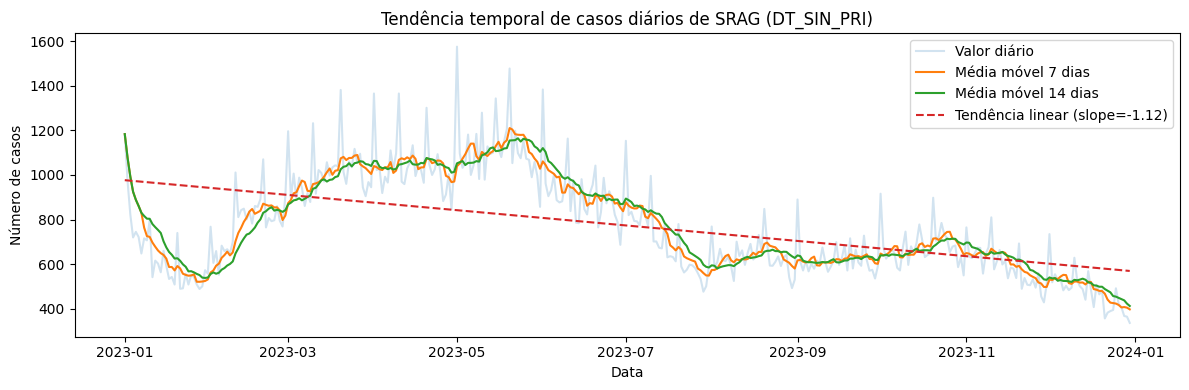

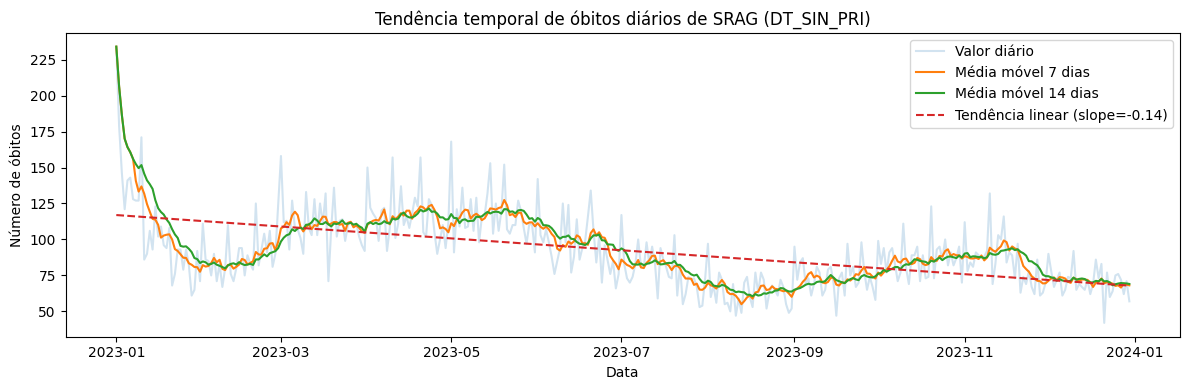

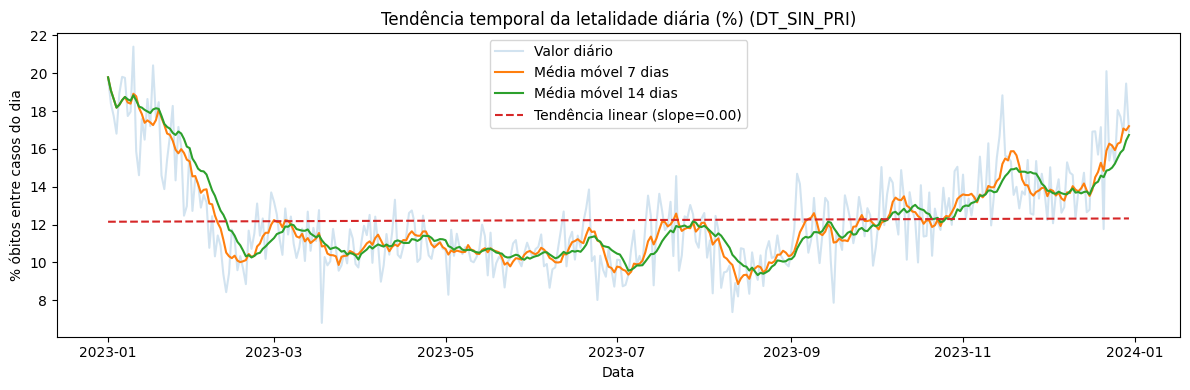

In [69]:
# Casos diários (tendência temporal)
plot_trend_temporal(
    tempo_sin_dia["casos"],
    titulo="Tendência temporal de casos diários de SRAG (DT_SIN_PRI)",
    ylabel="Número de casos"
)

# Óbitos diários (tendência temporal)
plot_trend_temporal(
    tempo_sin_dia["obitos"],
    titulo="Tendência temporal de óbitos diários de SRAG (DT_SIN_PRI)",
    ylabel="Número de óbitos"
)

# Letalidade diária (%) – tendência
plot_trend_temporal(
    tempo_sin_dia["letalidade_pct"],
    titulo="Tendência temporal da letalidade diária (%) (DT_SIN_PRI)",
    ylabel="% óbitos entre casos do dia"
)


#### Gráficos de tendência temporal (casos, óbitos, letalidade)

Para cada série diária (casos, óbitos e letalidade por data de início de sintomas), o gráfico traz:

- **Valor diário** (linha clara): mostra o ruído real do dia a dia.
- **Média móvel de 7 dias**: suaviza variações de fim de semana e picos pontuais.
- **Média móvel de 14 dias**: revela a tendência de médio prazo.
- **Linha de tendência linear sobre a MM7**: uma reta ajustada via regressão simples, que resume se, no período como um todo, a série está:
  - com **slope > 0** → tendência global de alta,
  - com **slope < 0** → tendência global de queda,
  - com **slope ≈ 0** → tendência aproximadamente estável.

Visualmente:
- curvas da MM7/MM14 mostram a dinâmica de subida/descida ao longo do tempo;
- a reta de tendência funciona como um “resumo” do comportamento global da série no período analisado.


### Tendências temporais ao longo de 2023 (por DT_SIN_PRI)

A leitura abaixo está baseada nos gráficos de **casos**, **óbitos** e **letalidade diária (%)** com
média móvel de 7/14 dias e reta de tendência.

---

## 1. Casos diários de SRAG

**Tendência global**

- A reta de tendência tem inclinação negativa: **queda lenta, porém consistente, do número diário de casos ao longo de 2023**.
- Começamos o ano perto da casa de ~1.000 casos/dia e terminamos em algo como ~400–500 casos/dia.

**Fases principais**

1. **Início de janeiro → início de fevereiro**  
   - Queda rápida: os casos saem de um patamar alto e despencam para algo em torno de ~500 casos/dia.  
   - Sugere que o ano já começou na “rabeira” de uma onda anterior.

2. **Fevereiro → maio**  
   - Primeiro um vale em fevereiro, depois **nova subida e um platô alto em março–maio**, na faixa de ~1.000–1.200 casos/dia, com alguns picos acima disso.  
   - É a **principal “barriga” de circulação** de 2023.

3. **Junho → agosto**  
   - **Queda progressiva** e relativamente suave, saindo desse platô alto até a faixa de ~600–700 casos/dia.  
   - Aqui a média móvel 14 dias desce de forma bem clara.

4. **Setembro → novembro**  
   - Período de **estabilização com pequena recrudescência**: casos voltam a subir um pouco (um “ombro” em outubro/novembro), mas sem voltar ao nível de março–maio.

5. **Dezembro**  
   - Nova queda, fechando o ano em patamar **bem menor que o início**.

**Resumo dos casos**  
2023 mostra uma **tendência geral de redução de casos**, com:
- um **grande platô/onda em março–maio**,  
- seguido de queda e um **pequeno ombro** no fim do ano, sem voltar ao pico do meio do ano.

---

## 2. Óbitos diários

**Tendência global**

- A reta de tendência também é negativa:  **óbitos diários caem ao longo do ano**, mas com menos amplitude que os casos.
- O início do ano tem valores mais altos, o meio do ano fica mais “comportado”, e o fim do ano volta a subir um pouco, mas sem chegar ao começo de janeiro.

**Fases principais**

1. **Início de janeiro**  
   - Pico alto de óbitos diários, claramente acima de 200 em alguns dias.  
   - Rapidíssima queda nas primeiras semanas.

2. **Fevereiro → maio**  
   - Depois do vale de fevereiro, os óbitos **sobem junto com os casos**, atingindo um segundo patamar em abril–maio (algo como ~100–130 óbitos/dia).  
   - É a “fase de maior volume estável” de mortes.

3. **Junho → agosto**  
   - **Queda gradual** dos óbitos, acompanhando a descida dos casos.  
   - As médias móveis aproximam-se da faixa de ~60–80 óbitos/dia.

4. **Setembro → novembro**  
   - Pequena **reaceleração**: óbitos voltam a subir modestamente, alinhados com o ombro de casos em outubro/novembro.  
   - Ainda assim, ficam em patamar menor do que no início do ano.

5. **Dezembro**  
   - Leve recuo ou estabilização; o fim do ano não é catastrófico, mas não volta ao “fundo do poço” do meio do ano.

**Resumo dos óbitos**  
Há uma **queda global de mortalidade em número absoluto**, com:
- pico muito alto em janeiro,
- um novo platô intermediário em abril–maio,
- e um **fim de ano com óbitos ainda relevantes**, mas abaixo dos picos.

---

## 3. Letalidade diária (%) – % de óbitos entre casos do dia

Esse é o gráfico mais interessante, porque não segue a mesma cara dos outros dois.

**Tendência global**

- A reta de tendência está praticamente horizontal  **no ano inteiro, a letalidade média fica por volta de um mesmo nível**, algo na casa de ~11–12%.  
- Mas a forma da curva **não é reta**: ela parece um “U”:

  - alta no começo do ano,  
  - baixa no meio,  
  - voltando a subir no fim.

**Fases principais**

1. **Início de janeiro**  
   - Letalidade muito alta, na casa de ~18–20%.  
   - Combinação de:
     - casos muito graves remanescentes da onda anterior,
     - e possivelmente seleção de quem é internado/notificado nesse período.

2. **Fevereiro → início de março**  
   - **Queda acentuada da letalidade**, aterrissando próximo de ~10–11%.  
   - Marca uma transição para uma fase “mais benigna” em termos de proporção de óbitos.

3. **Março → agosto**  
   - Longo período relativamente **estável**, com letalidade em torno de ~10–12%.  
   - Mesmo quando casos e óbitos absolutos sobem (abril–maio), a proporção de óbitos entre casos fica controlada.

4. **Setembro → dezembro**  
   - A partir de fim de agosto/setembro, a letalidade começa a **subir de forma lenta porém consistente**, chegando perto de ~15–17% no fim do ano.  
   - Isso ocorre **mesmo com número de casos não explodindo** como em março–maio.

**Resumo da letalidade**  
- O ano começa com **poucos casos muito graves** (letalidade alta),  
- passa por um longo trecho com **letalidade “moderada”** (~10–12%),  
- e termina com **menos casos, porém proporcionalmente mais graves**, já que a letalidade sobe.

---

## 4. Conclusão

Juntando tudo:

- **Casos**: tendência de **queda global** ao longo de 2023, com uma grande onda em **março–maio** e um ombro menor no fim do ano.  
- **Óbitos absolutos**: caem com o tempo, seguindo a mesma lógica (pico inicial, onda em abril–maio, ombro no fim do ano).  
- **Letalidade**:
  - alta no começo,
  - mais baixa e estável no meio do ano,
  - voltando a subir no fim.

Isso sugere um cenário tipo:

- O **volume bruto de circulação viral vai reduzindo** ao longo do ano;
- Mas o **perfil dos casos que seguem internando/notificando no fim de 2023 é mais pesado**:
  - possivelmente pacientes mais idosos/com múltiplas comorbidades,
  - ou período de pior desempenho do sistema para os casos que chegam,
  - ou mistura dos dois.

Não dá pra afirmar a causa só olhando o tempo, mas a mensagem de produto é clara:

> **“Ao longo de 2023, o sistema atendeu menos casos, mas terminou o ano lidando com um conjunto de pacientes proporcionalmente mais graves, com letalidade em alta.”**


## 3. Hipóteses “cross” (tempo + risco + gravidade)

Isso já conversa com os próximos blocos da EDA:

### H1 – Efeito de UTI e suporte ventilatório muda ao longo do ano
Utilizando a escala de gravidade (sem UTI/suporte → UTI → UTI+suporte invasivo).

Perguntas:
- O **uso de UTI** por caso de SRAG aumenta na alta temporada (outono/inverno)?
- A **letalidade entre os que usam ventilação invasiva** é estável ou muda com a estação?
- Há períodos em que o **uso de UTI é alto mas a letalidade cai** (indício de boa resposta do sistema),
  versus períodos em que UTI está saturada e letalidade dispara.

---

> **O uso de UTI por caso de SRAG aumenta na alta temporada (outono/inverno)?**

Não.  
A proporção em UTI é **ligeiramente menor** em outono/inverno (~29,7%) do que em primavera/verão (~32,3%).  
Ou seja, **não há “explosão” de UTI no frio**; o uso é alto e relativamente estável o ano todo.

---

> **A letalidade entre os que usam ventilação invasiva é estável ou muda com a estação?**

Ela é **sempre muito alta** (≈ 46–52%), mas **piora na primavera/verão**:

- Outono/Inverno: ~**45–47%** de óbito  
- Primavera/Verão: ~**51–52%** de óbito  

Então, é estável num *patamar alto*, com **viés de piora no fim do ano**.

---
> **O uso de UTI por caso de SRAG aumenta na alta temporada (outono/inverno)?**

Não.  
A proporção em UTI é **ligeiramente menor** em outono/inverno (~29,7%) do que em primavera/verão (~32,3%).  
Ou seja, **não há “explosão” de UTI no frio**; o uso é alto e relativamente estável o ano todo.

---

> **A letalidade entre os que usam ventilação invasiva é estável ou muda com a estação?**

Ela é **sempre muito alta** (≈ 46–52%), mas **piora na primavera/verão**:

- Outono/Inverno: ~**45–47%** de óbito  
- Primavera/Verão: ~**51–52%** de óbito  

Então, é estável num *patamar alto*, com **viés de piora no fim do ano**.

---


### H2 – Tempo de evolução da doença muda com a época
Utilizando:
- `DT_SIN_PRI` (início sintomas);  
- `DT_INTERNA`, `DT_UTI`, `DT_EVOLUCA` etc.

Hipóteses:
- No auge dos vírus respiratórios, pacientes chegam **mais tarde** ao hospital (maior atraso sintoma–internação).
- Atraso maior está associado a maior letalidade – e esse efeito pode ser mais forte em determinados períodos.

---


### H2 – Tempos de evolução (sintoma → internação/UTI/desfecho)

#### 1. Resumo global dos tempos (após limpeza de outliers)

Variáveis (em dias):

- `dias_sin_interna_cl` – do início dos sintomas até a **internação**
- `dias_sin_uti_cl` – do início dos sintomas até a **entrada em UTI**
- `dias_sin_evol_cl` – do início dos sintomas até o **desfecho** (alta/óbito)

Resumo geral (`describe`):

- **Sintoma → internação (`dias_sin_interna_cl`)**
  - n = 260.802
  - mediana **2 dias** (P25 = 1, P75 = 5)
  - P10 = 0, P90 = 9

- **Sintoma → UTI (`dias_sin_uti_cl`)**
  - n = 72.455
  - mediana **3 dias** (P25 = 1, P75 = 6)
  - P10 = 0, P90 = 10

- **Sintoma → desfecho (`dias_sin_evol_cl`)**
  - n = 245.293
  - mediana **9 dias** (P25 = 5, P75 = 15)
  - P10 = 2, P90 = 25

**Leitura:**  
A maioria é internada **muito cedo** (mediana 2 dias) e, quando precisa de UTI, isso acontece por volta de **3 dias** após o início dos sintomas. O desfecho (alta/óbito) costuma acontecer em **cerca de 9 dias**, com 80% dos casos encerrando até ~25 dias. É o perfil típico de uma doença aguda grave, sem grandes atrasos médios.

---

#### 2. Tempos por desfecho (Cura x Óbito)

Medianas por desfecho (`tempo_por_desfecho`):

| Desfecho | Sintoma → internação | Sintoma → UTI | Sintoma → desfecho |
|----------|----------------------|---------------|---------------------|
| **Cura** | **3 dias**           | **3 dias**    | **9 dias**          |
| **Óbito**| **2 dias**           | **3 dias**    | **10 dias**         |

**Leitura:**

- Quem **morre** chega em média **1 dia antes** ao hospital (mediana 2 vs 3 dias).
- O tempo até UTI é **igual** (3 dias de mediana) para cura e óbito.
- O tempo total até o desfecho é **apenas 1 dia maior** nos óbitos (10 vs 9 dias).

Ou seja, **não existe diferença grande de tempo de acesso** entre cura e óbito.  
O grupo que morre **não está claramente “atrasado” na chegada**; a diferença parece muito mais ligada à **gravidade intrínseca** (idade/comorbidades/suporte) do que a demora para internação.

---

#### 3. Tempos por estação do ano

Medianas por estação (`tempo_por_estacao`), usando `DT_SIN_PRI_date`:

| Estação   | Sintoma → internação | Sintoma → UTI | Sintoma → desfecho |
|-----------|----------------------|---------------|---------------------|
| **Inverno**   | **3 dias**           | **3 dias**    | **9 dias**          |
| **Outono**    | **3 dias**           | **3 dias**    | **9 dias**          |
| **Primavera** | **2 dias**           | **3 dias**    | **9 dias**          |
| **Verão**     | **2 dias**           | **3 dias**    | **8 dias**          |

**Leitura:**

- Sintoma → internação: oscila entre **2 e 3 dias** de mediana por estação.  
  Primavera/verão têm **1 dia a menos**, mas estamos falando de variação mínima.
- Sintoma → UTI: **3 dias de mediana em todas as estações**, totalmente estável.
- Sintoma → desfecho: entre **8 e 9 dias** de mediana; de novo, variação pequena.

Mesmo nas estações em que a **letalidade é mais alta (primavera/verão)**,  
os tempos sintoma → internação/UTI/desfecho **não se alongam**; se algo, até encurtam 1 dia.

---

#### 4. Conclusão da H2 (checagem da hipótese)

**Pergunta implícita da H2:**  
> *“O tempo de evolução (sintoma → internação/UTI/desfecho) muda com a época do ano e ajuda a explicar a maior letalidade em certos períodos?”*

Com base nos resultados:

- Os tempos **globais** são curtos: 2 dias até internação, 3 até UTI, 9 até desfecho.
- A diferença entre **Cura x Óbito** é **pequena** (1 dia para cada lado).
- Por **estação**, as medianas variam no máximo **1 dia** e permanecem muito próximas.

Então:

> **H2 não se sustenta como explicação principal para a sazonalidade da letalidade.**  
> O tempo de acesso e de evolução é **estável e relativamente rápido** ao longo do ano.  
> A maior letalidade em primavera/verão não parece vir de atraso na internação/UTI,  
> mas sim de **quem** está internando (perfil de risco) e **como** chega (gravidade, etiologia, comorbidades).
---

O que os resultados de H1 e H2 estão gritando é:

> “A gravidade é alta o ano inteiro, o tempo até cuidado é curto,  
> mas a letalidade sobe em determinadas épocas – então **onde** e **em quem** isso está concentrado?”

Próximos passos naturais para o bloco de **Geografia/Inequidades**:

1. **Mapear letalidade por território**
   - Letalidade por **UF**, **região**, **município** e **zona (urbana/rural/periurbana)**.
   - Ver se a letalidade mais alta está:
     - Espalhada de forma homogênea, ou
     - Concentrada em alguns estados/municípios específicos.

2. **Cruzar gravidade/tempo com território**
   - % de casos em **ventilação invasiva** por UF/zona.
   - Mediana de **dias sintoma → internação** por UF/zona.
   - Ver se existem bolsões onde:
     - A gravidade é maior, ou
     - O tempo até internação é discretamente mais longo.

3. **Trazer grupos de risco para dentro do mapa**
   - Letalidade por **raça/cor macro**, por UF e zona.
   - Letalidade por **faixa etária** por UF e zona.
   - Letalidade por **presença de comorbidades** (HAS/diabetes/obesidade, etc.) por UF.

A ideia é transformar o que hoje é “curvas bonitas no tempo” em um **mapa de pressão sobre o sistema de saúde**:  
onde está mais grave, onde morre mais, e onde o paciente eventualmente está mais vulnerável.


Você pode Conferir o Codigo para Essas Hipoteses no EDA_HIPOTESES.ipynb

In [2]:
# %% [markdown]
# # EDA Analítica - Bloco Geografia & Inequidades
# 
# Foco:
# - Distribuição geográfica dos casos e óbitos (UF, região, capital/interior).
# - Zona (urbana/rural/periurbana).
# - Macro-raça + território.

In [7]:
# ## 1. Mapeamento de colunas e variáveis auxiliares

# Coluna de UF de notificação (ou de residência, escolha uma e padronize)
UF_COL = "SG_UF_NOT"      # ajuste se no seu df for outro nome

# Coluna de município (nome) - usada para capital x interior
MUN_COL = "ID_MN_RESI"    # ajuste se for outro nome (ex: NM_MUNICIP, ID_MUNICIP)

# Zona urbana/rural/periurbana
ZONA_LABEL_COL = "CS_ZONA_label"   # se não existir, use CS_ZONA e trate o código

# Macro-raça já criada anteriormente
RACA_MACRO_COL = "CS_RACA_macro"   # ajuste se o nome estiver diferente

# Desfecho binário: 1=óbito, 0=cura
df["EVOLUCAO_BIN"] = pd.to_numeric(df["EVOLUCAO_BIN"], errors="coerce")
df["EVOLUCAO_disponivel"] = pd.to_numeric(df["EVOLUCAO_disponivel"], errors="coerce")

# Garante UF em string "limpa"
df[UF_COL] = df[UF_COL].astype(str).str.upper().str.strip()

# Cria região a partir de UF
REGIAO_MAP = {
    "AC": "N", "AP": "N", "AM": "N", "PA": "N", "RO": "N", "RR": "N", "TO": "N",
    "AL": "NE", "BA": "NE", "CE": "NE", "MA": "NE", "PB": "NE", "PE": "NE",
    "PI": "NE", "RN": "NE", "SE": "NE",
    "ES": "SE", "MG": "SE", "RJ": "SE", "SP": "SE",
    "PR": "S", "RS": "S", "SC": "S",
    "DF": "CO", "GO": "CO", "MS": "CO", "MT": "CO",
}
df["REGIAO"] = df[UF_COL].map(REGIAO_MAP)

df[["SG_UF_NOT", "REGIAO"]].head()


,SG_UF_NOT,REGIAO
0,SP,SE
1,SP,SE
2,PR,S
3,SP,SE
4,MG,SE


In [8]:
# ### 1.1 Capital x interior

CAPITAIS_POR_UF = {
    "AC": "RIO BRANCO",
    "AL": "MACEIO",
    "AM": "MANAUS",
    "AP": "MACAPA",
    "BA": "SALVADOR",
    "CE": "FORTALEZA",
    "DF": "BRASILIA",
    "ES": "VITORIA",
    "GO": "GOIANIA",
    "MA": "SAO LUIS",
    "MG": "BELO HORIZONTE",
    "MS": "CAMPO GRANDE",
    "MT": "CUIABA",
    "PA": "BELEM",
    "PB": "JOAO PESSOA",
    "PE": "RECIFE",
    "PI": "TERESINA",
    "PR": "CURITIBA",
    "RJ": "RIO DE JANEIRO",
    "RN": "NATAL",
    "RO": "PORTO VELHO",
    "RR": "BOA VISTA",
    "RS": "PORTO ALEGRE",
    "SC": "FLORIANOPOLIS",
    "SE": "ARACAJU",
    "SP": "SAO PAULO",
    "TO": "PALMAS",
}

# Normaliza nome do município
df[MUN_COL] = df[MUN_COL].astype(str).str.upper().str.strip()

df["TIPO_MUN"] = np.where(
    (df[UF_COL].isin(CAPITAIS_POR_UF.keys())) &
    (df[MUN_COL] == df[UF_COL].map(CAPITAIS_POR_UF)),
    "capital",
    "interior"
)

df["TIPO_MUN"].value_counts(dropna=False)

TIPO_MUN
interior    204396
capital      75057
Name: count, dtype: int64

In [9]:
# ## 2. Distribuição geográfica por UF e região

def resumo_geo(df_in, group_cols, uf_col=UF_COL):
    """
    Calcula:
    - n_casos
    - n_obitos (EVOLUCAO_BIN == 1)
    - letalidade (%)
    - proporção do total de casos
    """
    d = df_in.copy()
    
    # casos = todos os registros com UF não nula
    d = d[~d[uf_col].isna()].copy()
    
    # define óbito só onde EVOLUCAO_disponivel == 1
    d["obito_flag"] = np.where(
        (d["EVOLUCAO_disponivel"] == 1) & (d["EVOLUCAO_BIN"] == 1),
        1, 0
    )
    d["caso_flag"] = 1

    grp = (
        d.groupby(group_cols, dropna=False)
         .agg(
             n_casos=("caso_flag", "sum"),
             n_obitos=("obito_flag", "sum"),
         )
    )
    grp["letalidade"] = grp["n_obitos"] / grp["n_casos"]
    grp["letalidade_pct"] = grp["letalidade"] * 100

    # proporção dos casos no total
    total_casos = grp["n_casos"].sum()
    grp["pct_casos_total"] = 100 * grp["n_casos"] / total_casos

    return grp.sort_values("n_casos", ascending=False)

In [10]:
resumo_uf = resumo_geo(df, [UF_COL])
print("=== Casos, óbitos e letalidade por UF ===")
display(resumo_uf.head(10))  # top 10 para ver

=== Casos, óbitos e letalidade por UF ===


,n_casos,n_obitos,letalidade,letalidade_pct,pct_casos_total
SG_UF_NOT,,,,,
SP,78819,8889,0.112777,11.277738,28.204743
PR,28314,3268,0.115420,11.541993,10.131936
MG,25339,2877,0.113540,11.354039,9.067357
RJ,19616,4175,0.212836,21.283646,7.019427
RS,15030,2184,0.145309,14.530938,5.378364
CE,13981,1020,0.072956,7.295615,5.002988
SC,12356,1092,0.088378,8.837812,4.421495
BA,11791,1161,0.098465,9.846493,4.219314
DF,11645,729,0.062602,6.260198,4.167069


In [11]:
resumo_regiao = resumo_geo(df, ["REGIAO"])
print("=== Casos, óbitos e letalidade por região ===")
display(resumo_regiao)

=== Casos, óbitos e letalidade por região ===


,n_casos,n_obitos,letalidade,letalidade_pct,pct_casos_total
REGIAO,,,,,
SE,127718,16245,0.127194,12.719429,45.702855
S,55700,6544,0.117487,11.748654,19.931795
NE,50780,5358,0.105514,10.551398,18.171213
CO,28118,2938,0.104488,10.448823,10.061799
N,16990,2146,0.126310,12.630959,6.079734
NaN,147,14,0.095238,9.523810,0.052603


In [12]:
resumo_uf_tipo = resumo_geo(df, [UF_COL, "TIPO_MUN"])
print("=== Casos, óbitos e letalidade por UF e tipo de município ===")
display(resumo_uf_tipo.head(20))


=== Casos, óbitos e letalidade por UF e tipo de município ===


,,n_casos,n_obitos,letalidade,letalidade_pct,pct_casos_total
SG_UF_NOT,TIPO_MUN,,,,,
SP,interior,58400,7231,0.123818,12.381849,20.897969
PR,interior,23728,2853,0.120238,12.023769,8.490873
SP,capital,20419,1658,0.081199,8.119888,7.306774
MG,interior,17864,2081,0.116491,11.649127,6.392488
RS,interior,12633,1907,0.150954,15.095385,4.520617
RJ,interior,12386,2435,0.196593,19.659293,4.432230
DF,interior,11644,728,0.062521,6.252147,4.166711
SC,interior,10896,999,0.091685,9.168502,3.899046
BA,interior,7875,902,0.114540,11.453968,2.818005


In [16]:
resumo_uf.reset_index().to_csv(f"{DATA_PROCESSED}/resumo_geo_uf.csv", index=False)


In [17]:
# ## 3. Zona / contexto territorial (urbana/rural/periurbana)

if ZONA_LABEL_COL in df.columns:
    df[ZONA_LABEL_COL] = df[ZONA_LABEL_COL].fillna("Missing")

    resumo_zona = resumo_geo(df, [ZONA_LABEL_COL])
    print("=== Casos, óbitos e letalidade por zona ===")
    display(resumo_zona)

    # Zona x região
    resumo_zona_regiao = resumo_geo(df, ["REGIAO", ZONA_LABEL_COL])
    print("=== Casos, óbitos e letalidade por região e zona ===")
    display(resumo_zona_regiao)
else:
    print(f"Coluna {ZONA_LABEL_COL} não encontrada; ajuste o nome ou crie os labels de zona.")


=== Casos, óbitos e letalidade por zona ===


,n_casos,n_obitos,letalidade,letalidade_pct,pct_casos_total
CS_ZONA_label,,,,,
1 - Urbana,234799,27953,0.119051,11.905076,84.020927
Missing,22329,2609,0.116844,11.684357,7.990252
2 - Rural,15971,2139,0.133930,13.393025,5.715093
9 - Ignorado,3454,409,0.118413,11.841343,1.235986
3 - Periurbana,2900,135,0.046552,4.655172,1.037742


=== Casos, óbitos e letalidade por região e zona ===


,,n_casos,n_obitos,letalidade,letalidade_pct,pct_casos_total
REGIAO,CS_ZONA_label,,,,,
SE,1 - Urbana,111991,14416,0.128725,12.872463,40.075075
S,1 - Urbana,45482,5381,0.118311,11.831054,16.275367
NE,1 - Urbana,39519,3955,0.100078,10.007844,14.141555
CO,1 - Urbana,25133,2607,0.103728,10.372817,8.993641
N,1 - Urbana,12545,1582,0.126106,12.610602,4.489127
SE,Missing,10059,1111,0.110448,11.044835,3.599532
NE,2 - Rural,6502,782,0.120271,12.027069,2.326688
S,Missing,5034,619,0.122964,12.296385,1.801376
NE,Missing,4082,519,0.127144,12.714356,1.460711


In [18]:
# ## 4. Macro-raça + território (inequidades potenciais)

if RACA_MACRO_COL in df.columns:
    df[RACA_MACRO_COL] = df[RACA_MACRO_COL].fillna("Missing")

    resumo_raca_regiao = resumo_geo(df, ["REGIAO", RACA_MACRO_COL])
    print("=== Casos, óbitos e letalidade por região x macro-raça ===")
    display(resumo_raca_regiao)

    # Se quiser pivotado por região:
    tabela_raca_regiao = (
        resumo_raca_regiao
        .reset_index()
        .pivot(index=RACA_MACRO_COL, columns="REGIAO", values="letalidade_pct")
    )
    print("=== Letalidade (%) por macro-raça x região ===")
    display(tabela_raca_regiao)
else:
    print(f"Coluna {RACA_MACRO_COL} não encontrada; ajuste o nome ou crie a macro-raça.")


=== Casos, óbitos e letalidade por região x macro-raça ===


n_casos  n_obitos  letalidade  \
REGIAO CS_RACA_macro                                              
SE     Branca                       60870      8446    0.138755   
       Preta/Parda                  46579      6135    0.131712   
S      Branca                       42583      5193    0.121950   
NE     Preta/Parda                  36354      3831    0.105380   
SE     Ignorado/Missing             19093      1456    0.076258   
CO     Preta/Parda                  18143      1892    0.104283   
N      Preta/Parda                  13806      1835    0.132913   
NE     Ignorado/Missing              8867       631    0.071163   
S      Preta/Parda                   6436       881    0.136886   
       Ignorado/Missing              6301       420    0.066656   
CO     Branca                        6259       712    0.113756   
NE     Branca                        5022       805    0.160295   
CO     Ignorado/Missing              3198       268    0.083802   
N      Branca                        1323       152    0.114890   
SE     Outras (Amarela/Indígena)     1176       208    0.176871   
N      Ignorado/Missing              1137        79    0.069481   
       Outras (Amarela/Indígena)      724        80    0.110497   
NE     Outras (Amarela/Indígena)      537        91    0.169460   
CO     Outras (Amarela/Indígena)      518        66    0.127413   
S      Outras (Amarela/Indígena)      380        50    0.131579   
NaN    Preta/Parda                    120         7    0.058333   
       Branca                          18         3    0.166667   
       Ignorado/Missing                 5         1    0.200000   
       Outras (Amarela/Indígena)        4         3    0.750000   

                                  letalidade_pct  pct_casos_total  
REGIAO CS_RACA_macro                                               
SE     Branca                          13.875472        21.781838  
       Preta/Parda                     13.171172        16.667919  
S      Branca                          12.195007        15.237983  
NE     Preta/Parda                     10.538043        13.008985  
SE     Ignorado/Missing                 7.625831         6.832276  
CO     Preta/Parda                     10.428264         6.492326  
N      Preta/Parda                     13.291323         4.940366  
NE     Ignorado/Missing                 7.116274         3.172984  
S      Preta/Parda                     13.688626         2.303071  
       Ignorado/Missing                 6.665609         2.254762  
CO     Branca                          11.375619         2.239733  
NE     Branca                          16.029470         1.797082  
CO     Ignorado/Missing                 8.380238         1.144378  
N      Branca                          11.489040         0.473425  
SE     Outras (Amarela/Indígena)       17.687075         0.420822  
N      Ignorado/Missing                 6.948109         0.406866  
       Outras (Amarela/Indígena)       11.049724         0.259078  
NE     Outras (Amarela/Indígena)       16.945996         0.192161  
CO     Outras (Amarela/Indígena)       12.741313         0.185362  
S      Outras (Amarela/Indígena)       13.157895         0.135980  
NaN    Preta/Parda                      5.833333         0.042941  
       Branca                          16.666667         0.006441  
       Ignorado/Missing                20.000000         0.001789  
       Outras (Amarela/Indígena)       75.000000         0.001431

=== Letalidade (%) por macro-raça x região ===


REGIAO,NaN,CO,N,NE,S,SE
CS_RACA_macro,,,,,,
Branca,16.666667,11.375619,11.489040,16.029470,12.195007,13.875472
Ignorado/Missing,20.000000,8.380238,6.948109,7.116274,6.665609,7.625831
Outras (Amarela/Indígena),75.000000,12.741313,11.049724,16.945996,13.157895,17.687075
Preta/Parda,5.833333,10.428264,13.291323,10.538043,13.688626,13.171172


In [19]:
if RACA_MACRO_COL in df.columns:
    resumo_raca_uf = resumo_geo(df, [UF_COL, RACA_MACRO_COL])
    print("=== Casos, óbitos e letalidade por UF x macro-raça ===")
    display(resumo_raca_uf.head(30))


=== Casos, óbitos e letalidade por UF x macro-raça ===


n_casos  n_obitos  letalidade  letalidade_pct  \
SG_UF_NOT CS_RACA_macro                                                     
SP        Branca              47579      5760    0.121062       12.106181   
          Preta/Parda         18750      2158    0.115093       11.509333   
PR        Branca              18325      2287    0.124802       12.480218   
MG        Preta/Parda         15292      1482    0.096913        9.691342   
RS        Branca              12997      1883    0.144880       14.487959   
CE        Preta/Parda         11914       774    0.064966        6.496559   
SP        Ignorado/Missing    11804       841    0.071247        7.124703   
SC        Branca              11261      1023    0.090845        9.084451   
RJ        Preta/Parda         10566      2351    0.222506       22.250615   
BA        Preta/Parda          7822       814    0.104065       10.406546   
DF        Preta/Parda          7742       533    0.068845        6.884526   
MG        Branca               6968      1220    0.175086       17.508611   
PR        Ignorado/Missing     5652       314    0.055556        5.555556   
RJ        Branca               5561      1378    0.247797       24.779716   
PE        Preta/Parda          5311       528    0.099416        9.941631   
GO        Preta/Parda          5018       764    0.152252       15.225189   
MS        Preta/Parda          4190       482    0.115036       11.503580   
PR        Preta/Parda          4104       634    0.154483       15.448343   
PA        Preta/Parda          3833       497    0.129663       12.966345   
PB        Preta/Parda          3593       495    0.137768       13.776788   
RJ        Ignorado/Missing     3316       408    0.123040       12.303981   
AM        Preta/Parda          2993       476    0.159038       15.903775   
BA        Ignorado/Missing     2910       192    0.065979        6.597938   
MG        Ignorado/Missing     2809       147    0.052332        5.233179   
MS        Branca               2420       323    0.133471       13.347107   
AC        Preta/Parda          2352       403    0.171344       17.134354   
AP        Preta/Parda          2244       108    0.048128        4.812834   
PE        Ignorado/Missing     2146       120    0.055918        5.591799   
DF        Branca               2122       117    0.055137        5.513666   
MA        Preta/Parda          2025       266    0.131358       13.135802   

                            pct_casos_total  
SG_UF_NOT CS_RACA_macro                      
SP        Branca                  17.025761  
          Preta/Parda              6.709536  
PR        Branca                   6.557453  
MG        Preta/Parda              5.472119  
RS        Branca                   4.650872  
CE        Preta/Parda              4.263329  
SP        Ignorado/Missing         4.223966  
SC        Branca                   4.029658  
RJ        Preta/Parda              3.780958  
BA        Preta/Parda              2.799040  
DF        Preta/Parda              2.770412  
MG        Branca                   2.493443  
PR        Ignorado/Missing         2.022523  
RJ        Branca                   1.989959  
PE        Preta/Parda              1.900498  
GO        Preta/Parda              1.795651  
MS        Preta/Parda              1.499358  
PR        Preta/Parda              1.468583  
PA        Preta/Parda              1.371608  
PB        Preta/Parda              1.285726  
RJ        Ignorado/Missing         1.186604  
AM        Preta/Parda              1.071021  
BA        Ignorado/Missing         1.041320  
MG        Ignorado/Missing         1.005178  
MS        Branca                   0.865977  
AC        Preta/Parda              0.841644  
AP        Preta/Parda              0.802997  
PE        Ignorado/Missing         0.767929  
DF        Branca                   0.759341  
MA        Preta/Parda              0.724630

In [20]:
if RACA_MACRO_COL in df.columns:
    resumo_raca_tipo = resumo_geo(df, ["TIPO_MUN", RACA_MACRO_COL])
    print("=== Casos, óbitos e letalidade por tipo de município x raça ===")
    display(resumo_raca_tipo)


=== Casos, óbitos e letalidade por tipo de município x raça ===


n_casos  n_obitos  letalidade  \
TIPO_MUN CS_RACA_macro                                              
interior Branca                       94964     12710    0.133840   
         Preta/Parda                  83137      9893    0.118996   
capital  Preta/Parda                  38301      4688    0.122399   
interior Ignorado/Missing             23672      1783    0.075321   
capital  Branca                       21111      2601    0.123206   
         Ignorado/Missing             14929      1072    0.071807   
interior Outras (Amarela/Indígena)     2623       394    0.150210   
capital  Outras (Amarela/Indígena)      716       104    0.145251   

                                    letalidade_pct  pct_casos_total  
TIPO_MUN CS_RACA_macro                                               
interior Branca                          13.384019        33.982101  
         Preta/Parda                     11.899636        29.749904  
capital  Preta/Parda                     12.239889        13.705704  
interior Ignorado/Missing                 7.532105         8.470834  
capital  Branca                          12.320591         7.554401  
         Ignorado/Missing                 7.180655         5.342222  
interior Outras (Amarela/Indígena)       15.020968         0.938619  
capital  Outras (Amarela/Indígena)       14.525140         0.256215

Todas as Informações pode conferir no EDA_MAPA_INTERATIVO.ipynb